<a id='top'></a>

# Training of an Expected Goals Model from Opta Event Data
##### Notebook to train an Expected Goals (xG) model from Opta Event data by Stats Perform,  scraped using [ScraperFC](https://github.com/oseymour/ScraperFC) by [Owen Seymour](https://mobile.twitter.com/owen_seymour)

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 08/03/2021<br>
Notebook last updated: 04/01/2022

![Stats Perform](../../../../img/logos/stats_perform_logo_small.png)

![Opta](../../../../img/logos/opta_sports_logo_small.png)

![Expected Goals](../../../../img/expected_goals_visual.png)

Photo credit to David Sumpter ([@Soccermatics](https://twitter.com/Soccermatics?)).

___

<a id='sectionintro'></a>

## <a id='introduction'>Introduction</a>
This notebook is a short walk-through of how to create an Expected Goals model in [Python](https://www.python.org/) using a sample data of just under 11,00 shot. This notebook uses [pandas](http://pandas.pydata.org/) DataFrames, [scikit-learn](https://scikit-learn.org/stable/), [LightGBM](https://lightgbm.readthedocs.io/en/latest/), [XGBoost](https://xgboost.readthedocs.io/en/latest/), and [CatBoost](https://catboost.ai/) for Machine Learning, and [matplotlib](https://matplotlib.org/contents.html?v=20200411155018) and [Plotly](https://plotly.com/) for visualisations, as well as a few other libraries.

For more information about this notebook and the author, I am available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/);
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster);
*    [kaggle.com/eddwebster](https://www.kaggle.com/eddwebster); and
*    [hackerrank.com/eddwebster](https://www.hackerrank.com/eddwebster).

![Edd Webster](../../../../img/fifa21eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/football_analytics), with the xG modeling  and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/Capology%20Player%20Salary%20Web%20Scraping.ipynb).

___

## <a id='notebook_contents'>Notebook Contents</a>
1.     [Notebook Dependencies](#section1)<br>
2.     [Project Brief](#section2)<br>
3.     [Data Sources](#section3)<br>
       1.    [Data Dictionary](#section3.1)<br>
       2.    [Creating the DataFrame](#section3.2)<br>
       3.    [Initial Data Handling](#section3.3)<br>    
4.     [Data Engineering](#section4)<br>
5.     [Model Selection](#section5)<br>
       1.    [Classification Algorithms](#section5.1)<br>
       2.    [Logistic Regression](#section5.2)<br>
       3.    [The Sigmoid Function](#section5.3)<br>
       4.    [Common Uses of Logistic Regression](#section5.4)<br>
       5.    [XGBoost](#section5.5)<br>
       6.    [Reason for the Selection of Logistic Regression in Submitted (Initial) Notebook](#section5.6)<br>
6.     [Initial Modeling](#section5)<br>
7.     [Metric definition](#section7)<br>
8.     [Treating Outliers](#section8)<br>
       1.    [Shot Position](#section8.1)<br>
       2.    [Body Part](#section8.2)<br>
       3.    [Impact on Log Loss](#section8.3)<br>   
9.     [Univariate Analysis](#section9)<br>
       1.    [Distance](#section9.1)<br>
       2.    [Position Y](#section9.2)<br>
       3.    [Angle](#section9.3)<br>   
       4.    [Body Part](#section9.4)<br>
       5.    [Model Performance](#section9.5)<br>
10.    [Feature Engineering](#section10)<br>
       1.    [Features to Add](#sectio10.1)<br>
       2.    [Wishlist Features](#section10.2)<br>
11.    [Multivariate Analysis](#section11)<br>
12.    [Final Model and Evaluation](#section12)<br>
13.    [Feature Interpretation](#section13)<br>
14.    [Assessment of the Performance of the Teams in a Separate Dataset](#section14)<br>
15.    [Summary](#section15)<br>
16.    [Next Steps](#section16)<br>
17.    [References and Further Reading](#section17)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>
This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation;
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) and [`Plotly`](https://plotly.com/) for data visualisations; and
*    [`scikit-learn`](https://scikit-learn.org/stable/index.html), [`LightGBM`](https://lightgbm.readthedocs.io/en/latest/), [`XGBoost`](https://xgboost.readthedocs.io/en/latest/), and [`CatBoost`](https://catboost.ai/) for Machine Learning.

All packages used for this notebook except can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [1]:
%load_ext autoreload
%autoreload 2

# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
import math
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
import pandas_profiling as pp
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os
from os.path import basename

# Working with JSON
import json
from pandas.io.json import json_normalize

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Arc
from matplotlib.colors import ListedColormap
import plotly
import plotly.graph_objects as go
import ruamel.yaml
import seaborn as sns
import missingno as msno

# Downloading data sources
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile
from tqdm import tqdm

# Football libraries
#import FCPython
#from FCPython import createPitch
import matplotsoccer

# Machine Learning
import scipy as sp
import scipy.spatial
from scipy.spatial import distance
from sklearn.ensemble import RandomForestClassifier
#from sklearn.inspection import permutation_importance
import sklearn.metrics as sk_metrics
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score , roc_curve, average_precision_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scikitplot.metrics import plot_roc_curve, plot_precision_recall_curve, plot_calibration_curve
import pickle
from xgboost import XGBClassifier   # version 1.0.2

# Display in Jupyter
from IPython.display import Image, Video, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action='ignore', message='^internal gelsd')

print('Setup Complete')

Setup Complete


In [2]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))
print('Seaborn: {}'.format(sns.__version__))
print('Plotly: {}'.format(plotly.__version__))

Python: 3.7.6
NumPy: 1.20.3
pandas: 1.3.2
matplotlib: 3.4.2
Seaborn: 0.11.2
Plotly: 5.1.0


### Defined Variables

In [3]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Filepaths

In [39]:
# Set up initial paths to subfolders
#base_dir = os.path.join('..', '..')
base_dir = os.path.join('..', '..', '..','..')
data_dir = os.path.join(base_dir, 'data')
#data_dir = '/Volumes/3TB EXT/2022 work/data'
data_dir_opta = os.path.join(base_dir, 'data', 'opta')
#data_dir_opta = '/Volumes/3TB EXT/2022 work/data/opta'
data_dir_metrica = os.path.join(base_dir, 'data', 'metrica-sports')
models_dir = os.path.join(base_dir, 'models')
models_dir_opta = os.path.join(base_dir, 'models', 'opta')
scripts_dir = os.path.join(base_dir, 'scripts')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
fig_dir_opta = os.path.join(base_dir, 'img', 'fig', 'opta')
video_dir = os.path.join(base_dir, 'video')

### Custom Functions

In [5]:
# Function to create all the features from event data
def data_preparation(df):
    
    ## Define masks - a mix of 'typeId' and 'qualifierTypes' (a very manual process)

    ### Event Type masks
    pass_event_type_mask = df['typeId'] == 1
    offside_pass_event_type_mask = df['typeId'] == 2
    take_on_event_type_mask = df['typeId'] == 3
    foul_event_type_mask = df['typeId'] == 4
    out_event_type_mask = df['typeId'] == 5
    corner_awarded_event_type_mask = df['typeId'] == 6
    tackle_event_type_mask = df['typeId'] == 7
    interception_event_type_mask = df['typeId'] == 8
    turnover_event_type_mask = df['typeId'] == 9
    save_event_type_mask = df['typeId'] == 10
    claim_event_type_mask = df['typeId'] == 11
    clearance_event_type_mask = df['typeId'] == 12
    missed_shots_event_type_mask = df['typeId'] == 13
    shot_on_post_event_type_mask = df['typeId'] == 14
    saved_shot_event_type_mask = df['typeId'] == 15
    goal_event_type_mask = df['typeId'] == 16
    card_event_type_mask = df['typeId'] == 17
    substitution_off_event_type_mask = df['typeId'] == 18
    substitution_on_event_type_mask = df['typeId'] == 19
    player_retired_event_type_mask = df['typeId'] == 20
    player_returns_event_type_mask = df['typeId'] == 21
    player_becomes_goalkeeper_event_type_mask = df['typeId'] == 22
    goalkeeper_becomes_player_event_type_mask = df['typeId'] == 23
    condition_change_event_type_mask = df['typeId'] == 24
    official_change_event_type_mask = df['typeId'] == 25
    # No 'typeId' == 26
    start_delay_event_type_mask = df['typeId'] == 27
    end_delay_event_type_mask = df['typeId'] == 28
    # No 'typeId' == 29
    end_event_type_mask = df['typeId'] == 30
    # No 'typeId' == 31
    start_event_type_mask = df['typeId'] == 32
    # No 'typeId' == 33
    formation_set_event_type_mask = df['typeId'] == 34
    player_changed_position_event_type_mask = df['typeId'] == 35
    player_changed_jersey_number_event_type_mask = df['typeId'] == 36
    collection_end_event_type_mask = df['typeId'] == 37
    temp_goal_event_type_mask = df['typeId'] == 38
    temp_attempt_event_type_mask = df['typeId'] == 39
    formation_change_event_type_mask = df['typeId'] == 40
    punch_event_type_mask = df['typeId'] == 41
    good_skill_event_type_mask = df['typeId'] == 42
    deleted_event_event_type_mask = df['typeId'] == 43
    aerial_event_type_mask = df['typeId'] == 44
    challenge_event_type_mask = df['typeId'] == 45
    # No 'typeId' == 46
    rescinded_card_event_type_mask = df['typeId'] == 47
    # No 'typeId' == 48
    ball_recovery_event_type_mask = df['typeId'] == 49
    dispossessed_event_type_mask = df['typeId'] == 50
    error_event_type_mask = df['typeId'] == 51
    keeper_pickup_event_type_mask = df['typeId'] == 52
    cross_not_claimed_event_type_mask = df['typeId'] == 53
    smother_event_type_mask = df['typeId'] == 54
    offside_provoked_event_type_mask = df['typeId'] == 55
    shield_ball_opp_event_type_mask = df['typeId'] == 56
    foul_throw_in_event_type_mask = df['typeId'] == 57
    penalty_faced_event_type_mask = df['typeId'] == 58
    keeper_sweeper_event_type_mask = df['typeId'] == 59
    chance_missed_event_type_mask = df['typeId'] == 60
    ball_touch_event_type_mask = df['typeId'] == 61
    # No 'typeId' == 62
    temp_save_event_type_mask = df['typeId'] == 63
    resume_event_type_mask = df['typeId'] == 64
    contentious_referee_decision_event_type_mask = df['typeId'] == 65
    possession_data_event_type_mask = df['typeId'] == 66
    fifty_fifty_event_type_mask = df['typeId'] == 67
    referee_drop_ball_event_type_mask = df['typeId'] == 68
    failed_to_block_event_type_mask = df['typeId'] == 69
    injury_time_announcement_event_type_mask = df['typeId'] == 70
    coach_setup_event_type_mask = df['typeId'] == 71
    caught_offside_event_type_mask = df['typeId'] == 72
    other_ball_contact_event_type_mask = df['typeId'] == 73
    blocked_pass_event_type_mask = df['typeId'] == 74
    
    ### Qualifier Type masks
    longball_qualifier_type_mask = df['qualifiers'].str.contains("{'type': {'value': 1, 'displayName': 'Longball'}", na=False)
    cross_qualifier_type_mask = df['qualifiers'].str.contains("{'type': {'value': 2, 'displayName': 'Cross'}", na=False)
    head_pass_qualifier_type_mask = df['qualifiers'].str.contains("{'type': {'value': 3, 'displayName': '}", na=False)
    through_ball_qualifier_type_mask = df['qualifiers'].str.contains("{'type': {'value': 4, 'displayName': 'Throughball'}", na=False)
    free_kick_taken_qualifier_type_mask = df['qualifiers'].str.contains("{'type': {'value': 5, 'displayName': 'FreekickTaken'}", na=False)  
    corner_taken_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 6, 'displayName': 'CornerTaken'}", na=False)
    players_caught_offside_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 7, 'displayName': '}", na=False)
    goal_disallowed_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 8, 'displayName': '}", na=False)
    penalty_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 9, 'displayName': 'Penalty'}", na=False)
    handball_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 10, 'displayName': 'Handball'}", na=False)
    six_seconds_violation_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 11, 'displayName': '}", na=False)
    dangerous_play_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 12, 'displayName': '}", na=False)
    foul_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 13, 'displayName': '}", na=False)
    last_line_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 14, 'displayName': '}", na=False)
    head_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 15, 'displayName': 'Head'}", na=False)
    small_box_centre_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 16, 'displayName': '}", na=False)
    box_centre_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 17, 'displayName': '}", na=False)
    out_of_box_centre_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 18, 'displayName': '}", na=False)
    thirty_five_plus_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 19, 'displayName': '}", na=False)
    right_footed_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 20, 'displayName': '}", na=False)
    other_body_part_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 21, 'displayName': '}", na=False)
    regular_play_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 22, 'displayName': 'RegularPlay'}", na=False)
    fast_break_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 23, 'displayName': '}", na=False)
    set_piece_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 24, 'displayName': 'SetPiece'}", na=False)
    from_corner_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 25, 'displayName': '}", na=False)
    free_kick_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 26, 'displayName': '}", na=False)
    # No 'qualifierId' == 27
    own_goal_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 28, 'displayName': 'OwnGoal'}", na=False)
    assisted_qualifier_type_mask = df['qualifiers'].str.contains("{'type': {'value': 29, 'displayName': 'Assisted'}", na=False)
    involved_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 30, 'displayName': '}", na=False)
    yellow_qualifier_type_mask = df['qualifiers'].str.contains("{'type': {'value': 31, 'displayName': 'Yellow'}", na=False)
    second_yellow_qualifier_type_mask = df['qualifiers'].str.contains("{'type': {'value': 32, 'displayName': '", na=False)    # second_yellow_qualifier_type_mask = df['qualifiers'].str.contains("{'type': {'value': 32, 'displayName': 'Second Yellow'}", na=False)
    red_qualifier_type_mask = df['qualifiers'].str.contains("{'type': {'value': 33, 'displayName'", na=False)         # red_qualifier_type_mask = df['qualifiers'].str.contains("{'type': {'value': 33, 'displayName': 'Red'}", na=False)
    referee_abuse_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 34, 'displayName': '}", na=False)
    argument_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 35, 'displayName': '}", na=False)
    fight_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 36, 'displayName': '}", na=False)
    time_wasting_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 37, 'displayName': '}", na=False)
    excessive_celebration_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 38, 'displayName': '}", na=False)
    crowd_interaction_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 39, 'displayName': '}", na=False)
    other_reason_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 40, 'displayName': '}", na=False)
    injury_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 41, 'displayName': '}", na=False)
    tactical_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 42, 'displayName': '}", na=False)
    # No 'qualifierId' == 43
    player_position_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 44, 'displayName': '}", na=False)
    temperature_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 45, 'displayName': '}", na=False)
    conditions_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 46, 'displayName': '}", na=False)
    field_pitch_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 47, 'displayName': '}", na=False)
    lightings_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 48, 'displayName': '}", na=False)
    attendance_figure_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 49, 'displayName': '}", na=False)
    official_position_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 50, 'displayName': '}", na=False)
    official_id_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 51, 'displayName': '}", na=False)
    # No 'qualifierId' == 52
    injured_player_id_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 53, 'displayName': '}", na=False)
    end_cause_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 54, 'displayName': '}", na=False)
    related_event_id_qualifier_type_mask = df['qualifiers'].str.contains("{'type': {'value': 55, 'displayName': 'RelatedEventId'}", na=False)
    zone_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 56, 'displayName': '}", na=False)
    end_type_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 57, 'displayName': '}", na=False)
    # No 'qualifierId' == 58
    jersey_number_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 59, 'displayName': '}", na=False)
    small_box_right_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 60, 'displayName': '}", na=False)
    small_box_left_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 61, 'displayName': '}", na=False)
    box_deep_right_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 62, 'displayName': '}", na=False)
    box_right_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 63, 'displayName': '}", na=False)
    box_left_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 64, 'displayName': '}", na=False)
    box_deep_left_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 65, 'displayName': '}", na=False)
    out_of_box_deep_right_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 66, 'displayName': '}", na=False)
    out_of_box_right_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 67, 'displayName': '}", na=False)
    out_of_box_left_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 68, 'displayName': '}", na=False)
    out_of_box_deep_left_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 69, 'displayName': '}", na=False)
    thirty_five_plus_right_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 70, 'displayName': '}", na=False)
    thirty_five_plus_left_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 71, 'displayName': '}", na=False)
    left_footed_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 72, 'displayName': '}", na=False)
    left_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 73, 'displayName': '}", na=False)
    high_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 74, 'displayName': '}", na=False)
    right_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 75, 'displayName': '}", na=False)
    low_left_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 76, 'displayName': '}", na=False)
    high_left_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 77, 'displayName': '}", na=False)
    low_centre_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 78, 'displayName': '}", na=False)
    high_centre_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 79, 'displayName': '}", na=False)
    low_right_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 80, 'displayName': '}", na=False)
    high_right_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 81, 'displayName': '}", na=False)
    blocked_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 82, 'displayName': 'Blocked'}", na=False)
    close_left_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 83, 'displayName': '}", na=False)
    close_right_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 84, 'displayName': '}", na=False)
    close_high_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 85, 'displayName': '}", na=False)
    close_left_and_high_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 86, 'displayName': '}", na=False)
    close_right_and_high_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 87, 'displayName': '}", na=False)
    high_claim_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 88, 'displayName': '}", na=False)
    one_on_one_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 89, 'displayName': '}", na=False)
    deflected_save_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 90, 'displayName': '}", na=False)
    dive_and_deflect_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 91, 'displayName': '}", na=False)
    catch_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 92, 'displayName': '}", na=False)
    dive_and_catch_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 93, 'displayName': '}", na=False)
    def_block_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 94, 'displayName': '}", na=False)
    back_pass_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 95, 'displayName': '}", na=False)
    corner_situation_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 96, 'displayName': '}", na=False)
    direct_free_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 97, 'displayName': '}", na=False)
    # No 'qualifierId' == 98
    # No 'qualifierId' == 99
    six_yard_blocked_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 100, 'displayName': '}", na=False)
    saved_off_line_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 101, 'displayName': '}", na=False)
    goal_mouth_y_coordinate_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 102, 'displayName': '}", na=False)
    goal_mouth_z_coordinate_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 103, 'displayName': '}", na=False)
    # No 'qualifierId' == 104
    # No 'qualifierId' == 105
    attacking_pass_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 106, 'displayName': '}", na=False)
    throw_in_qualifier_type_mask = df['qualifiers'].str.contains("{'type': {'value': 107, 'displayName': 'ThrowIn'}", na=False)
    volley_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 108, 'displayName': '}", na=False)
    overhead_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 109, 'displayName': '}", na=False)
    half_volley_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 110, 'displayName': '}", na=False)
    diving_header_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 111, 'displayName': '}", na=False)
    scramble_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 112, 'displayName': '}", na=False)
    strong_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 113, 'displayName': '}", na=False)
    weak_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 114, 'displayName': '}", na=False)
    rising_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 115, 'displayName': '}", na=False)
    dipping_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 116, 'displayName': '}", na=False)
    lob_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 117, 'displayName': '}", na=False)
    one_bounce_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 118, 'displayName': '}", na=False)
    few_bounces_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 119, 'displayName': '}", na=False)
    swerve_left_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 120, 'displayName': '}", na=False)
    swerve_right_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 121, 'displayName': '}", na=False)
    swerve_moving_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 122, 'displayName': '}", na=False)
    keeper_throw_qualifier_type_mask = df['qualifiers'].str.contains("{'type': {'value': 123, 'displayName': 'KeeperThrow'}", na=False)
    goal_kick_qualifier_type_mask = df['qualifiers'].str.contains("{'type': {'value': 124, 'displayName': 'GoalKick'}", na=False)
    # No 'qualifierId' == 125
    # No 'qualifierId' == 126
    direction_of_play_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 127, 'displayName': '}", na=False)
    punch_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 128, 'displayName': '}", na=False)
    # No 'qualifierId' == 129
    team_formation_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 130, 'displayName': '}", na=False)
    team_player_formation_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 131, 'displayName': '}", na=False)
    dive_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 132, 'displayName': '}", na=False)
    deflection_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 133, 'displayName': '}", na=False)
    far_wide_left_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 134, 'displayName': '}", na=False)
    far_wide_right_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 135, 'displayName': '}", na=False)
    keeper_touched_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 136, 'displayName': '}", na=False)
    keeper_saved_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 137, 'displayName': '}", na=False)
    hit_woodwork_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 138, 'displayName': '}", na=False)
    own_player_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 139, 'displayName': '}", na=False)
    pass_end_x_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 140, 'displayName': '}", na=False)
    pass_end_y_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 141, 'displayName': '}", na=False)
    # No 'qualifierId' == 142
    # No 'qualifierId' == 143
    deleted_event_type_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 144, 'displayName': '}", na=False)
    formation_slot_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 145, 'displayName': '}", na=False)
    blocked_x_coordinate_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 146, 'displayName': '}", na=False)
    blocked_y_coordinate_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 147, 'displayName': '}", na=False)
    # No 'qualifierId' == 148
    # No 'qualifierId' == 149
    # No 'qualifierId' == 150
    # No 'qualifierId' == 151
    # No 'qualifierId' == 152
    not_past_goal_line_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 153, 'displayName': '}", na=False)
    intentional_assist_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 154, 'displayName': '}", na=False)
    chipped_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 155, 'displayName': '}", na=False)
    lay_off_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 156, 'displayName': '}", na=False)
    launch_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 157, 'displayName': '}", na=False)
    persistent_infringement_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 158, 'displayName': '}", na=False)
    foul_and_abusive_language_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 159, 'displayName': '}", na=False)
    throw_in_set_piece_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 160, 'displayName': '}", na=False)
    encroachment_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 161, 'displayName': '}", na=False)
    leaving_field_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 162, 'displayName': '}", na=False)
    entering_field_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 163, 'displayName': '}", na=False)
    spitting_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 164, 'displayName': '}", na=False)
    professional_foul_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 165, 'displayName': '}", na=False)
    handling_on_the_line_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 166, 'displayName': '}", na=False)
    out_of_play_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 167, 'displayName': '}", na=False)
    flick_on_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 168, 'displayName': '}", na=False)
    leading_to_attempt_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 169, 'displayName': '}", na=False)
    leading_to_goal_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 170, 'displayName': '}", na=False)
    rescinded_card_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 171, 'displayName': '}", na=False)
    no_impact_on_timing_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 172, 'displayName': '}", na=False)
    parried_safe_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 173, 'displayName': '}", na=False)
    parried_danger_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 174, 'displayName': '}", na=False)
    fingertip_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 175, 'displayName': '}", na=False)
    caught_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 176, 'displayName': '}", na=False)
    collected_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 177, 'displayName': '}", na=False)
    standing_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 178, 'displayName': '}", na=False)
    diving_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 179, 'displayName': '}", na=False)
    stooping_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 180, 'displayName': '}", na=False)
    reaching_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 181, 'displayName': '}", na=False)
    hands_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 182, 'displayName': '}", na=False)
    feet_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 183, 'displayName': '}", na=False)
    dissent_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 184, 'displayName': '}", na=False)
    blocked_cross_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 185, 'displayName': '}", na=False)
    scored_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 186, 'displayName': '}", na=False)
    saved_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 187, 'displayName': '}", na=False)
    missed_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 188, 'displayName': '}", na=False)
    player_not_visible_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 189, 'displayName': '}", na=False)
    from_shot_off_target_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 190, 'displayName': '}", na=False)
    on_the_ball_foul_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 191, 'displayName': '}", na=False)
    block_by_hand_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 192, 'displayName': '}", na=False)
    # No 'qualifierId' == 193
    captain_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 194, 'displayName': '}", na=False)
    pull_back_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 195, 'displayName': '}", na=False)
    switch_of_play_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 196, 'displayName': '}", na=False)
    team_kit_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 197, 'displayName': '}", na=False)
    gk_hoof_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 198, 'displayName': '}", na=False)
    gk_kick_from_hands_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 199, 'displayName': '}", na=False)
    referee_stop_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 200, 'displayName': '}", na=False)
    referee_delay_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 201, 'displayName': '}", na=False)
    weather_problem_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 202, 'displayName': '}", na=False)
    crowd_trouble_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 203, 'displayName': '}", na=False)
    fire_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 204, 'displayName': '}", na=False)
    object_thrown_on_pitch_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 205, 'displayName': '}", na=False)
    spectator_on_pitch_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 206, 'displayName': '}", na=False)
    awaiting_officials_decision_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 207, 'displayName': '}", na=False)
    referee_injury_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 208, 'displayName': '}", na=False)
    game_end_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 209, 'displayName': '}", na=False)
    assist_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 210, 'displayName': '}", na=False)
    overrun_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 211, 'displayName': '}", na=False)
    length_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 212, 'displayName': '}", na=False)
    angle_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 213, 'displayName': '}", na=False)
    big_chance_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 214, 'displayName': '}", na=False)
    individual_play_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 215, 'displayName': '}", na=False)
    second_related_event_id_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 216, 'displayName': '}", na=False)
    second_assisted_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 217, 'displayName': '}", na=False)
    second_assist_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 218, 'displayName': '}", na=False)
    players_on_both_posts_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 219, 'displayName': '}", na=False)
    player_on_near_post_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 220, 'displayName': '}", na=False)
    player_on_far_post_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 221, 'displayName': '}", na=False)
    no_players_on_posts_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 222, 'displayName': '}", na=False)
    inswinger_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 223, 'displayName': '}", na=False)
    outswinger_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 224, 'displayName': '}", na=False)
    straight_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 225, 'displayName': '}", na=False)
    suspended_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 226, 'displayName': '}", na=False)
    resume_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 227, 'displayName': '}", na=False)
    own_shot_blocked_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 228, 'displayName': '}", na=False)
    post_match_complete_qualifier_type_mask = df['qualifiers'].str.contains("{'value': 229, 'displayName': '}", na=False)
    
    ### Satisfied Event Type masks
    big_chance_missed_satisified_event_type_mask = df['satisfiedEventsTypes'].str.contains(', 202,', na=False)
    big_chance_scored_satisified_event_type_mask = df['satisfiedEventsTypes'].str.contains(', 203,', na=False)
    big_chance_created_satisified_event_type_mask = df['satisfiedEventsTypes'].str.contains(', 204,', na=False)
    defensive_third_satisified_event_type_mask = df['satisfiedEventsTypes'].str.contains(', 215,', na=False)
    mid_third_satisified_event_type_mask = df['satisfiedEventsTypes'].str.contains(', 216,', na=False)
    final_third_satisified_event_type_mask = df['satisfiedEventsTypes'].str.contains(', 217,', na=False)
    
    
    ## Apply defined masks

    ### Event Types
    df['isPass'] = np.where(pass_event_type_mask, 1, 0)
    df['isOffsidePass'] = np.where(offside_pass_event_type_mask, 1, 0)
    df['isTakeOn'] = np.where(take_on_event_type_mask, 1, 0)
    df['isFoul'] = np.where(foul_event_type_mask, 1, 0)
    df['isOut'] = np.where(out_event_type_mask, 1, 0)
    df['isCorner'] = np.where(corner_awarded_event_type_mask, 1, 0)
    df['isTackle'] = np.where(tackle_event_type_mask, 1, 0)
    df['isInterception'] = np.where(interception_event_type_mask, 1, 0)
    df['isTurnover'] = np.where(turnover_event_type_mask, 1, 0)
    df['isSave'] = np.where(save_event_type_mask , 1, 0)
    df['isClaim'] = np.where(claim_event_type_mask, 1, 0)
    df['isClearance'] = np.where(clearance_event_type_mask, 1, 0)
    df['isMissedShots'] = np.where(missed_shots_event_type_mask, 1, 0)
    df['isShotOnPost'] = np.where(shot_on_post_event_type_mask, 1, 0)
    df['isSavedShot'] = np.where(saved_shot_event_type_mask, 1, 0)
    df['isGoal'] = np.where(goal_event_type_mask, 1, 0)
    df['isCard'] = np.where(card_event_type_mask, 1, 0)
    df['isSubsitutionOff'] = np.where(substitution_off_event_type_mask, 1, 0)
    df['isSubstitutionOn'] = np.where(substitution_on_event_type_mask, 1, 0)
    df['isPlayerRetured'] = np.where(player_retired_event_type_mask, 1, 0)
    df['isPlayerReturns'] = np.where(player_returns_event_type_mask, 1, 0)
    df['isPlayerBecomesGoalkeeper'] = np.where(player_becomes_goalkeeper_event_type_mask, 1, 0)
    df['isGoalkeeperBecomesPlayer'] = np.where(goalkeeper_becomes_player_event_type_mask, 1, 0)
    df['isConditionChange'] = np.where(condition_change_event_type_mask, 1, 0)
    df['isOfficialChange'] = np.where(official_change_event_type_mask, 1, 0)
    df['isStartDelay'] = np.where(start_delay_event_type_mask, 1, 0)
    df['isEndDelay'] = np.where(end_delay_event_type_mask, 1, 0)
    df['isEnd'] = np.where(end_event_type_mask, 1, 0)
    df['isStart'] = np.where(start_event_type_mask, 1, 0)
    df['isFormationSet'] = np.where(formation_set_event_type_mask, 1, 0)
    df['isPlayerChangedPosition'] = np.where(player_changed_position_event_type_mask, 1, 0)
    df['isPlayerChangedJerseyNumber'] = np.where(player_changed_jersey_number_event_type_mask, 1, 0)
    df['isCollectionEndEvent'] = np.where(collection_end_event_type_mask, 1, 0)
    df['isTempAttempt'] = np.where(temp_attempt_event_type_mask, 1, 0)
    df['isFormationChange'] = np.where(formation_change_event_type_mask, 1, 0)
    df['isPunch'] = np.where(punch_event_type_mask, 1, 0)
    df['isGoodSkill'] = np.where(good_skill_event_type_mask, 1, 0)
    df['isDeletedEvent'] = np.where(deleted_event_event_type_mask, 1, 0)
    df['isAerial'] = np.where(aerial_event_type_mask, 1, 0)
    df['isChallenge'] = np.where(challenge_event_type_mask, 1, 0)
    df['isRescindedCard'] = np.where(rescinded_card_event_type_mask, 1, 0)
    df['isBallRecovery'] = np.where(ball_recovery_event_type_mask, 1, 0)
    df['isDispossessed'] = np.where(dispossessed_event_type_mask, 1, 0)
    df['isError'] = np.where(error_event_type_mask, 1, 0)
    df['isKeeperPickup'] = np.where(keeper_pickup_event_type_mask, 1, 0)
    df['isCrossNotClaimed'] = np.where(cross_not_claimed_event_type_mask, 1, 0)
    df['isSmother'] = np.where(smother_event_type_mask, 1, 0)
    df['isOffsideProvoke'] = np.where(offside_provoked_event_type_mask, 1, 0)
    df['isShieldBallOpp'] = np.where(shield_ball_opp_event_type_mask, 1, 0)
    df['isFoulThrowIn'] = np.where(foul_throw_in_event_type_mask, 1, 0)
    df['isPenaltyFaced'] = np.where(penalty_faced_event_type_mask, 1, 0)
    df['isKeeperSweeper'] = np.where(keeper_sweeper_event_type_mask, 1, 0)
    df['isChanceMissed'] = np.where(chance_missed_event_type_mask, 1, 0)
    df['isBallTouch'] = np.where(ball_touch_event_type_mask, 1, 0)
    df['isTempSave'] = np.where(temp_save_event_type_mask, 1, 0)
    df['isResume'] = np.where(resume_event_type_mask, 1, 0)
    df['isContentiousRefereeDecision'] = np.where(contentious_referee_decision_event_type_mask, 1, 0)
    df['isPossessionData'] = np.where(possession_data_event_type_mask, 1, 0)
    df['is5050'] = np.where(fifty_fifty_event_type_mask, 1, 0)
    df['isRefereeDropBall'] = np.where(referee_drop_ball_event_type_mask, 1, 0)
    df['isFailedToBlock'] = np.where(failed_to_block_event_type_mask, 1, 0)
    df['isInjuryTimeAnnouncement'] = np.where(injury_time_announcement_event_type_mask, 1, 0)
    df['isCoachSetup'] = np.where(coach_setup_event_type_mask, 1, 0)
    df['isCaughtOffside'] = np.where(caught_offside_event_type_mask, 1, 0)
    df['isOtherBallContact'] = np.where(other_ball_contact_event_type_mask, 1, 0)
    df['isBlockedPass'] = np.where(blocked_pass_event_type_mask, 1, 0)
    
    ### Qualifier Types
    df['isLongball'] = np.where(longball_qualifier_type_mask, 1, 0)
    df['isCross'] = np.where(cross_qualifier_type_mask, 1, 0)
    df['isHeadPass'] = np.where(head_pass_qualifier_type_mask, 1, 0)
    df['isThroughBall'] = np.where(through_ball_qualifier_type_mask, 1, 0)
    df['isFreeKickTaken'] = np.where(free_kick_taken_qualifier_type_mask, 1, 0)
    df['isCornerTaken'] = np.where(corner_taken_qualifier_type_mask, 1, 0)
    df['isPlayerCaughtOffside'] = np.where(players_caught_offside_qualifier_type_mask, 1, 0)
    df['isGoalDisallowed'] = np.where(goal_disallowed_qualifier_type_mask, 1, 0)
    df['isPenalty'] = np.where(corner_taken_qualifier_type_mask, 1, 0)
    df['isHandball'] = np.where(handball_qualifier_type_mask, 1, 0)
    df['is6SecondsBiolation'] = np.where(six_seconds_violation_qualifier_type_mask, 1, 0)
    df['isDangerousPlay'] = np.where(dangerous_play_qualifier_type_mask, 1, 0)
    df['isFoul'] = np.where(foul_qualifier_type_mask, 1, 0)
    df['isLastLine'] = np.where(last_line_qualifier_type_mask, 1, 0)
    df['isHead'] = np.where(head_qualifier_type_mask, 1, 0)
    df['isSmallBoxCentre'] = np.where(small_box_centre_qualifier_type_mask, 1, 0)
    df['isBoxCentre'] = np.where(box_centre_qualifier_type_mask, 1, 0)
    df['isOutOfBoxCentre'] = np.where(out_of_box_centre_qualifier_type_mask, 1, 0)
    df['35+'] = np.where(thirty_five_plus_qualifier_type_mask, 1, 0)
    df['isRightFooted'] = np.where(right_footed_qualifier_type_mask, 1, 0)
    df['isOtherBodyPart'] = np.where(other_body_part_qualifier_type_mask, 1, 0)
    df['isRegularPlay'] = np.where(regular_play_qualifier_type_mask, 1, 0)
    df['isFastBreak'] = np.where(fast_break_qualifier_type_mask, 1, 0)
    df['isSetPiece'] = np.where(set_piece_qualifier_type_mask, 1, 0)
    df['isFromCorner'] = np.where(from_corner_qualifier_type_mask, 1, 0)
    df['isFreeKick'] = np.where(free_kick_qualifier_type_mask, 1, 0)
    # No 'qualifierId' == 27
    df['isOwnGoal'] = np.where(own_goal_qualifier_type_mask, 1, 0)
    df['isAssisted'] = np.where(assisted_qualifier_type_mask, 1, 0)
    df['isInvolved'] = np.where(involved_qualifier_type_mask, 1, 0)
    df['isYellow'] = np.where(yellow_qualifier_type_mask, 1, 0)
    df['isSecondYellow'] = np.where(second_yellow_qualifier_type_mask, 1, 0)
    df['isRed'] = np.where(red_qualifier_type_mask, 1, 0)
    df['isRefereeAbuse'] = np.where(referee_abuse_qualifier_type_mask, 1, 0)
    df['isArgument'] = np.where(argument_qualifier_type_mask, 1, 0)
    df['isFight'] = np.where(fight_qualifier_type_mask, 1, 0)
    df['isTimeWasting'] = np.where(time_wasting_qualifier_type_mask, 1, 0)
    df['isExcessiveCelebration'] = np.where(excessive_celebration_qualifier_type_mask, 1, 0)
    df['isCrowdInteraction'] = np.where(crowd_interaction_qualifier_type_mask, 1, 0)
    df['isOtherReason'] = np.where(other_reason_qualifier_type_mask, 1, 0)
    df['isInjury'] = np.where(injury_qualifier_type_mask, 1, 0)
    df['isTactical'] = np.where(tactical_qualifier_type_mask, 1, 0)
    # No 'qualifierId' == 43
    df['isPlayerPosition'] = np.where(player_position_qualifier_type_mask, 1, 0)
    df['iaTemperature'] = np.where(temperature_qualifier_type_mask, 1, 0)
    df['isConditions'] = np.where(conditions_qualifier_type_mask, 1, 0)
    df['isFieldPitch'] = np.where(field_pitch_qualifier_type_mask, 1, 0)
    df['isLightings'] = np.where(lightings_qualifier_type_mask, 1, 0)
    df['isAttendanceFigure'] = np.where(attendance_figure_qualifier_type_mask, 1, 0)
    df['isOfficialPosition'] = np.where(official_position_qualifier_type_mask, 1, 0)
    df['isOfficialId'] = np.where(official_id_qualifier_type_mask, 1, 0)
    # No 'qualifierId' == 52
    df['isInjuredPlayerId'] = np.where(injured_player_id_qualifier_type_mask, 1, 0)
    df['isEndCause'] = np.where(end_cause_qualifier_type_mask, 1, 0)
    df['isRelatedEventId'] = np.where(related_event_id_qualifier_type_mask, 1, 0)
    df['isZoneQualifier'] = np.where(zone_qualifier_type_mask, 1, 0)
    df['isEndType'] = np.where(end_type_qualifier_type_mask, 1, 0)
    # No 'qualifierId' == 58
    df['isJerseyNumber'] = np.where(jersey_number_qualifier_type_mask, 1, 0)
    df['isSmallBoxRightQualifier'] = np.where(small_box_right_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(small_box_left_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(box_deep_right_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(box_right_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(box_left_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(box_deep_left_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(out_of_box_deep_right_qualifier_type_mask
    #df['...'] = np.where(out_of_box_right_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(out_of_box_left_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(out_of_box_deep_left_qualifier_type_mask
    #df['...'] = np.where(thirty_five_plus_right_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(thirty_five_plus_left_qualifier_type_mask, 1, 0)
    df['isLeftFooted'] = np.where(left_footed_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(left_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(high_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(right_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(low_left_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(high_left_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(low_centre_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(high_centre_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(low_right_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(high_right_qualifier_type_mask, 1, 0)
    df['isBlocked'] = np.where(blocked_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(close_left_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(close_right_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(close_high_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(close_left_and_high_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(close_right_and_high_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(high_claim_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(one_on_one_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(deflected_save_qualifier_type_mask
    #df['...'] = np.where(dive_and_deflect_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(catch_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(dive_and_catch_qualifier_type_mask, 1, 0)
    df['isDefBlock'] = np.where(def_block_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(back_pass_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(corner_situation_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(direct_free_qualifier_type_mask, 1, 0)
    # No 'qualifierId' == 98
    # No 'qualifierId' == 99
    #df['...'] = np.where(six_yard_blocked_qualifier_type_mask, 1, 0) 
    #df['...'] = np.where(saved_off_line_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(goal_mouth_y_coordinate_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(goal_mouth_z_coordinate_qualifier_type_mask, 1, 0)
    # No 'qualifierId' == 104
    # No 'qualifierId' == 105
    #df['...'] = np.where(attacking_pass_qualifier_type_mask, 1, 0)
    df['isThrowIn'] = np.where(throw_in_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(volley_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(overhead_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(half_volley_qualifier_type_mask, 1, 0), 1, 0)
    #df['...'] = np.where(diving_header_qualifier_type_mask
    #df['...'] = np.where(scramble_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(strong_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(weak_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(rising_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(dipping_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(lob_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(one_bounce_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(few_bounces_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(swerve_left_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(swerve_right_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(swerve_moving_qualifier_type_mask, 1, 0)
    df['isKeeperThrow'] = np.where(keeper_throw_qualifier_type_mask, 1, 0)
    df['isGoalKick'] = np.where(goal_kick_qualifier_type_mask, 1, 0)
    # No 'qualifierId' == 125
    # No 'qualifierId' == 126
    #df['...'] = np.where(direction_of_play_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(punch_qualifier_type_mask, 1, 0)
    # No 'qualifierId' == 129
    #df['...'] = np.where(team_formation_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(team_player_formation_qualifier_type_mask, 1, 0)
    df['isDive'] = np.where(dive_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(deflection_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(far_wide_left_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(far_wide_right_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(keeper_touched_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(keeper_saved_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(hit_woodwork_qualifier_type_mlask, 1, 0)
    #df['...'] = np.where(own_player_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(pass_end_x_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(pass_end_y_qualifier_type_mask, 1, 0)
    # No 'qualifierId' == 142
    # No 'qualifierId' == 143
    #df['...'] = np.where(deleted_event_type_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(formation_slot_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(blocked_x_coordinate_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(blocked_y_coordinate_qualifier_type_mask, 1, 0)
    # No 'qualifierId' == 148
    # No 'qualifierId' == 149
    # No 'qualifierId' == 150
    # No 'qualifierId' == 151
    # No 'qualifierId' == 152
    #df['...'] = np.where(not_past_goal_line_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(intentional_assist_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(chipped_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(lay_off_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(launch_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(persistent_infringement_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(foul_and_abusive_language_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(throw_in_set_piece_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(encroachment_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(leaving_field_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(entering_field_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(spitting_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(professional_foul_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(handling_on_the_line_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(out_of_play_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(flick_on_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(leading_to_attempt_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(leading_to_goal_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(rescinded_card_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(no_impact_on_timing_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(parried_safe_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(parried_danger_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(fingertip_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(caught_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(collected_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(standing_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(diving_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(stooping_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(reading_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(hands_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(feet_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(dissent_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(blocked_cross_qualifier_type_mask, 1, 0), 1, 0)
    #df['...'] = np.where(scored_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(saved_qualifier_type_mask
    #df['...'] = np.where(missed_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(player_not_visible_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(from_shot_off_target_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(on_the_ball_foul_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(block_by_hand_qualifier_type_mask, 1, 0)
    # No 'qualifierId' == 193
    #df['...'] = np.where(captain_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(pull_back_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(switch_of_play_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(team_kit_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(gk_hoof_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(gk_kick_from_hands_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(referee_stop_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(referee_delay_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(weather_problem_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(crowd_trouble_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(fire_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(object_thrown_on_pitch_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(spectator_on_pitch_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(awaiting_officials_decision_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(referee_injury_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(game_end_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(assist_qualifier_type_mask, 1, 0)
    df['isOverrun'] = np.where(overrun_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(length_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(angle_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(big_chance_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(individual_play_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(second_related_event_id_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(second_assisted_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(second_assist_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(players_on_both_posts_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(player_on_near_post_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(player_on_far_post_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(no_players_on_posts_qualifier_type_mask
    #df['...'] = np.where(inswinger_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(outswinger_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(straight_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(suspended_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(resume_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(own_shot_blocked_qualifier_type_mask, 1, 0)
    #df['...'] = np.where(post_match_complete_qualifier_type_mask, 1, 0)
    
    ### Combined Event Type and Qualifier Type masks - based on the CPL Player Events data
    df['isSubOn'] = np.where(substitution_on_event_type_mask, 1, 0)
    df['isSubOff'] = np.where(substitution_off_event_type_mask, 1, 0)
    #df['isGWG'] = np.where(gwg_mask, 1, 0)
    df['isSOG'] = np.where( saved_shot_event_type_mask |
                                        goal_event_type_mask &
                                       (df['isBlocked']==0)
                                       , 1, 0
                                      )
    df['isSOTInBox'] = np.where((saved_shot_event_type_mask | goal_event_type_mask) &                                           offside_pass_event_type_mask |
                                            (small_box_centre_qualifier_type_mask |
                                             box_centre_qualifier_type_mask |
                                             small_box_right_qualifier_type_mask |
                                             small_box_left_qualifier_type_mask |
                                             box_deep_right_qualifier_type_mask |
                                             box_right_qualifier_type_mask |
                                             box_left_qualifier_type_mask |
                                             box_deep_left_qualifier_type_mask
                                            ) & 
                                            (df['isBlocked']==0)
                                            , 1, 0
                                           )
    df['isSOTOBox'] = np.where((saved_shot_event_type_mask | goal_event_type_mask) &                                           offside_pass_event_type_mask |
                                           (out_of_box_centre_qualifier_type_mask |
                                            thirty_five_plus_qualifier_type_mask |
                                            out_of_box_deep_right_qualifier_type_mask |
                                            out_of_box_right_qualifier_type_mask |
                                            out_of_box_left_qualifier_type_mask |
                                            out_of_box_deep_left_qualifier_type_mask |
                                            thirty_five_plus_right_qualifier_type_mask |
                                            thirty_five_plus_left_qualifier_type_mask
                                           ) & 
                                           (df['isBlocked']==0)
                                           , 1, 0
                                          )
    df['isBlkdInBox'] = np.where((saved_shot_event_type_mask | goal_event_type_mask) &                                           offside_pass_event_type_mask |
                                             (small_box_centre_qualifier_type_mask |
                                              box_centre_qualifier_type_mask |
                                              small_box_right_qualifier_type_mask |
                                              small_box_left_qualifier_type_mask |
                                              box_deep_right_qualifier_type_mask |
                                              box_right_qualifier_type_mask |
                                              box_left_qualifier_type_mask |
                                              box_deep_left_qualifier_type_mask
                                             ) & 
                                             (df['isBlocked']==1)
                                             , 1, 0
                                            )
    df['isBlkdOutBox'] = np.where((saved_shot_event_type_mask | goal_event_type_mask) &                                           offside_pass_event_type_mask |
                                              (out_of_box_centre_qualifier_type_mask |
                                               thirty_five_plus_qualifier_type_mask |
                                               out_of_box_deep_right_qualifier_type_mask |
                                               out_of_box_right_qualifier_type_mask |
                                               out_of_box_left_qualifier_type_mask |
                                               out_of_box_deep_left_qualifier_type_mask |
                                               thirty_five_plus_right_qualifier_type_mask |
                                               thirty_five_plus_left_qualifier_type_mask
                                              ) & 
                                              (df['isBlocked']==1)
                                              , 1, 0
                                             )
    df['isOff'] = np.where((missed_shots_event_type_mask | shot_on_post_event_type_mask) , 1, 0)
    df['isOffTgtOBox'] = np.where((missed_shots_event_type_mask | shot_on_post_event_type_mask) &                                           offside_pass_event_type_mask |
                                              (out_of_box_centre_qualifier_type_mask |
                                               thirty_five_plus_qualifier_type_mask |
                                               out_of_box_deep_right_qualifier_type_mask |
                                               out_of_box_right_qualifier_type_mask |
                                               out_of_box_left_qualifier_type_mask |
                                               out_of_box_deep_left_qualifier_type_mask |
                                               thirty_five_plus_right_qualifier_type_mask |
                                               thirty_five_plus_left_qualifier_type_mask
                                              )
                                              , 1, 0
                                             )
    df['isOffTgtInBox'] = np.where((missed_shots_event_type_mask | shot_on_post_event_type_mask) &                                           offside_pass_event_type_mask |
                                               (small_box_centre_qualifier_type_mask |
                                                box_centre_qualifier_type_mask |
                                                small_box_right_qualifier_type_mask |
                                                small_box_left_qualifier_type_mask |
                                                box_deep_right_qualifier_type_mask |
                                                box_right_qualifier_type_mask |
                                                box_left_qualifier_type_mask |
                                                box_deep_left_qualifier_type_mask
                                               )
                                               , 1, 0
                                              )
    df['isPenTaken'] = np.where(penalty_qualifier_type_mask, 1, 0)
    df['isPenGoal'] = np.where( goal_event_type_mask &
                                           (df['outcomeTypeId']==1) &
                                            penalty_qualifier_type_mask
                                           , 1, 0
                                          )
    df['isShotDirFK'] = np.where((missed_shots_event_type_mask |
                                              shot_on_post_event_type_mask |
                                              saved_shot_event_type_mask |
                                              goal_event_type_mask
                                             ) & free_kick_qualifier_type_mask
                                             , 1, 0
                                            )
    df['isGoalDirFK'] = np.where(goal_event_type_mask & 
                                             free_kick_qualifier_type_mask
                                             , 1, 0
                                            )
    df['isGoalInBx'] = np.where( goal_event_type_mask &
                                            (df['outcomeTypeId']==1) &
                                            (small_box_centre_qualifier_type_mask |
                                             box_centre_qualifier_type_mask |
                                             small_box_right_qualifier_type_mask |
                                             small_box_left_qualifier_type_mask |
                                             box_deep_right_qualifier_type_mask |
                                             box_right_qualifier_type_mask |
                                             box_left_qualifier_type_mask |
                                             box_deep_left_qualifier_type_mask
                                            )
                                            , 1, 0
                                           )
    df['isGoalOBx'] = np.where( goal_event_type_mask &
                                           (df['outcomeTypeId']==1) &
                                           (out_of_box_centre_qualifier_type_mask |
                                            thirty_five_plus_qualifier_type_mask |
                                            out_of_box_deep_right_qualifier_type_mask |
                                            out_of_box_right_qualifier_type_mask |
                                            out_of_box_left_qualifier_type_mask |
                                            out_of_box_deep_left_qualifier_type_mask |
                                            thirty_five_plus_right_qualifier_type_mask |
                                            thirty_five_plus_left_qualifier_type_mask
                                           )
                                           , 1, 0
                                          )
    df['isGoalOP']  = np.where( goal_event_type_mask &
                                           (df['outcomeTypeId']==1)  &
                                            regular_play_qualifier_type_mask
                                           , 1, 0
                                          )
    df['isGoalHead']  = np.where( goal_event_type_mask &
                                             (df['outcomeTypeId']==1) &
                                              head_qualifier_type_mask
                                             , 1, 0
                                            )
    df['isOffTgtHead'] = np.where((missed_shots_event_type_mask | shot_on_post_event_type_mask) &                                           offside_pass_event_type_mask |
                                              head_qualifier_type_mask
                                              , 1, 0
                                             )
    df['isSOTHead'] = np.where((saved_shot_event_type_mask | goal_event_type_mask) &                                           offside_pass_event_type_mask |
                                            head_qualifier_type_mask & 
                                           (df['isBlocked']==0)
                                           , 1, 0
                                          )
    df['isGoalLF'] = np.where( goal_event_type_mask &
                                          (df['outcomeTypeId']==1) &
                                           left_footed_qualifier_type_mask
                                          , 1, 0
                                         )
    df['isGoalRF'] = np.where( goal_event_type_mask &
                                          (df['outcomeTypeId']==1) &
                                           right_footed_qualifier_type_mask
                                          , 1, 0
                                         )

    df['isShotLF'] = np.where((missed_shots_event_type_mask |
                                           shot_on_post_event_type_mask |
                                           saved_shot_event_type_mask |
                                           goal_event_type_mask
                                          ) &
                                           left_footed_qualifier_type_mask
                                          , 1, 0
                                         )
    df['isShotRF'] = np.where((missed_shots_event_type_mask |
                                           shot_on_post_event_type_mask |
                                           saved_shot_event_type_mask |
                                           goal_event_type_mask
                                          ) &
                                           right_footed_qualifier_type_mask
                                          , 1, 0
                                         )
    """
    df['isPsOpHfFl'] = np.where( pass_event_type_mask &
                                            (df['outcomeTypeId']==0) &
                                            (df['isCross']==0) &
                                            (df['isFreeKickTaken']==0) &
                                            (df['isCornerTaken']==0) &
                                            (df['isThrowIn']==0) &
                                            (df['isKeeperThrow']==0) &
                                            (df['isGoalKick']==0) &
                                            # ADD LOGIC FOR OPPOSITION HALF HERE
                                            , 1, 0
                                           )
    """
    """
    df['isPsOnHfFl'] = np.where( pass_event_type_mask &
                                            (df['outcomeTypeId']==0) &
                                            (df['isCross']==0) &
                                            (df['isFreeKickTaken']==0) &
                                            (df['isCornerTaken']==0) &
                                            (df['isThrowIn']==0) &
                                            (df['isKeeperThrow']==0) &
                                            (df['isGoalKick']==0) &
                                            # ADD LOGIC FOR OWN HALF HERE
                                            , 1, 0
                                           )
    """
    df['isPsAtt'] = np.where( pass_event_type_mask &
                                         (df['isCross']==0) &
                                         (df['isFreeKickTaken']==0) &
                                         (df['isCornerTaken']==0) &
                                         (df['isThrowIn']==0) &
                                         (df['isKeeperThrow']==0) &
                                         (df['isGoalKick']==0)
                                         , 1, 0
                                        )

    df['isPsScs'] = np.where( pass_event_type_mask &
                                         (df['outcomeTypeId']==1) &
                                         (df['isCross']==0) &
                                         (df['isFreeKickTaken']==0) &
                                         (df['isCornerTaken']==0) &
                                         (df['isThrowIn']==0) &
                                         (df['isKeeperThrow']==0) &
                                         (df['isGoalKick']==0)
                                         , 1, 0
                                        )
    """
    df['isPsOnHfScs'] = np.where( pass_event_type_mask &
                                             (df['outcomeTypeId']==1) &
                                             (df['isCross']==0) &
                                             (df['isFreeKickTaken']==0) &
                                             (df['isCornerTaken']==0) &
                                             (df['isThrowIn']==0) &
                                             (df['isKeeperThrow']==0) &
                                             (df['isGoalKick']==0) &
                                             # ADD LOGIC FOR OPPOSITION HALF HERE
                                             , 1, 0
                                            )
    """
    """
    df['isPsOnHfScs'] = np.where( pass_event_type_mask &
                                             (df['outcomeTypeId']==1) &
                                             (df['isCross']==0) &
                                             (df['isFreeKickTaken']==0) &
                                             (df['isCornerTaken']==0) &
                                             (df['isThrowIn']==0) &
                                             (df['isKeeperThrow']==0) &
                                             (df['isGoalKick']==0) &
                                             # ADD LOGIC FOR OWN HALF HERE
                                             , 1, 0
                                            )
    """
    #df['isExpG'] = np.where(exp_goal_mask, 1, 0)
    df['isGoal'] = np.where( goal_event_type_mask &
                                        (df['outcomeTypeId']==1)
                                        , 1, 0
                                       )
    df['isAst'] = np.where( goal_event_type_mask &
                                       (df['outcomeTypeId']==1) &
                                        assisted_qualifier_type_mask &
                                        related_event_id_qualifier_type_mask
                                       , 1, 0
                                      )
    #df['isExpA'] = np.where(exp_ast_mask, 1, 0)
    df['isBgChnc'] = np.where(big_chance_qualifier_type_mask, 1, 0)    
    #df['isBgChncCrtd'] = np.where(bg_chnc_crtd_mask, 1, 0)            
    #df['isChncSetPl'] = np.where(chnc_set_pieces_mask, 1, 0)    # What is the defition of chance?
    #df['isChncOpnPl'] = np.where(chnc_op_mask, 1, 0)            # What is the defition of chance?
    #df['isChance'] = np.where(chnc_mask, 1, 0)                  # What is the defition of chance?
    df['is1v1'] = np.where( take_on_event_type_mask #&
                                      #(df['isOverrun']==0) &
                                       , 1, 0
                                      )
    df['is1v1InBox'] = np.where( take_on_event_type_mask &
                                           #(df['isOverrun']==0) #&
                                            (small_box_centre_qualifier_type_mask |
                                             box_centre_qualifier_type_mask |
                                             small_box_right_qualifier_type_mask |
                                             small_box_left_qualifier_type_mask |
                                             box_deep_right_qualifier_type_mask |
                                             box_right_qualifier_type_mask |
                                             box_left_qualifier_type_mask |
                                             box_deep_left_qualifier_type_mask
                                            )
                                            , 1, 0
                                           )
    df['isScs1v1InBox'] = np.where( take_on_event_type_mask &
                                               (df['outcomeTypeId']==1) &
                                               (df['isOverrun']==1) &
                                               (small_box_centre_qualifier_type_mask |
                                                box_centre_qualifier_type_mask |
                                                small_box_right_qualifier_type_mask |
                                                small_box_left_qualifier_type_mask |
                                                box_deep_right_qualifier_type_mask |
                                                box_right_qualifier_type_mask |
                                                box_left_qualifier_type_mask |
                                                box_deep_left_qualifier_type_mask
                                               )
                                               , 1, 0
                                              )
    df['isSucflDuels'] = np.where((take_on_event_type_mask |
                                               foul_event_type_mask |
                                               tackle_event_type_mask |
                                               challenge_event_type_mask |
                                               smother_event_type_mask
                                              ) &
                                              (df['outcomeTypeId']==1)
                                              , 1, 0
                                             )
    df['isSuccess1v1'] = np.where( take_on_event_type_mask &
                                              (df['outcomeTypeId']==1) &
                                              (df['isOverrun']==0)
                                              , 1, 0
                                             )
    df['isThrghBalls'] = np.where(through_ball_qualifier_type_mask, 1, 0)
    df['isThrghBlCmp'] = np.where( through_ball_qualifier_type_mask &
                                              (df['outcomeTypeId']==1)
                                              , 1, 0
                                             )
    df['isTouches'] = np.where((pass_event_type_mask & (df['isKeeperThrow']==0)) |
                                            offside_pass_event_type_mask |
                                            take_on_event_type_mask |
                                            tackle_event_type_mask |
                                            interception_event_type_mask |
                                            turnover_event_type_mask |
                                            save_event_type_mask |
                                            claim_event_type_mask |
                                            clearance_event_type_mask |
                                            missed_shots_event_type_mask |
                                            shot_on_post_event_type_mask |
                                            saved_shot_event_type_mask |
                                            goal_event_type_mask |
                                            rescinded_card_event_type_mask |
                                            ball_recovery_event_type_mask |
                                            foul_throw_in_event_type_mask |
                                            keeper_sweeper_event_type_mask |
                                            ball_touch_event_type_mask |
                                            failed_to_block_event_type_mask
                                           , 1, 0
                                          )
    df['isDuelLs']  = np.where((take_on_event_type_mask |
                                            foul_event_type_mask |
                                            tackle_event_type_mask |
                                            challenge_event_type_mask |
                                            smother_event_type_mask
                                           ) &
                                           (df['outcomeTypeId']==0)
                                           , 1, 0
                                          )
    df['isFailTackle'] = np.where( challenge_event_type_mask &
                                              (df['outcomeTypeId']==0)
                                              , 1, 0
                                             )
    df['isSucflTkls'] = np.where( tackle_event_type_mask &
                                             (df['outcomeTypeId']==1) |
                                             (df['outcomeTypeId']==0)
                                             , 1, 0
                                            )
    df['isInt'] = np.where(interception_event_type_mask, 1, 0)
    #df['isDefTouch'] = np.where(def_touch_mask, 1, 0)
    df['isClrnce'] = np.where( clearance_event_type_mask &
                                          (df['outcomeTypeId']==1)
                                          , 1, 0
                                         )
    df['isHeadClear'] = np.where( clearance_event_type_mask &
                                              head_qualifier_type_mask &
                                             (df['outcomeTypeId']==1)
                                             , 1, 0
                                            )
    df['isRecovery'] = np.where( ball_recovery_event_type_mask &
                                            (df['outcomeTypeId']==1)
                                            , 1, 0
                                           )
    #df['isFlComA3'] = np.where(fl_com_a3_mask, 1, 0)
    #df['isFlComD3'] = np.where(fl_com_d3_mask, 1, 0)
    #df['isFlComM3'] = np.where(fl_com_m3_mask, 1, 0)
    #df['isFlSufA3'] = np.where(fl_suf_a3_mask, 1, 0)
    #df['isFlSufD3'] = np.where(fl_suf_d3_mask, 1, 0)
    #df['isFlSufM3'] = np.where(fl_suf_m3_mask, 1, 0)
    df['isOffsides'] = np.where(caught_offside_event_type_mask, 1, 0)
    #df['isCleanSheet'] = np.where(clean_sheet_mask, 1, 0)
    df['isCrossPunch'] = np.where( punch_event_type_mask &
                                               punch_qualifier_type_mask &
                                              (df['outcomeTypeId']==1)
                                              , 1, 0
                                             )
    df['isErrShot'] = np.where(claim_event_type_mask &
                                           leading_to_attempt_qualifier_type_mask
                                           , 1, 0
                                          )
    df['isErrGoal'] = np.where(claim_event_type_mask &
                                           leading_to_goal_qualifier_type_mask
                                           , 1, 0
                                          )
    #df['isCleared'] = np.where(cleared_mask, 1, 0)
    df['isKeeperCtch'] = np.where( claim_event_type_mask &
                                              (df['outcomeTypeId']==1)
                                              , 1, 0
                                             )
    #df['isGoalCncd'] = np.where(goal_cncd_mask, 1, 0)
    #df['isGoalCnIBx'] = np.where(goal_cncd_mask & goal_not_cncd_out_box_mask, 1, 0)
    #df['isGoalCnOBx'] = np.where(goal_cncd_out_box_mask, 1, 0)
    df['isPensWon'] = np.where( foul_event_type_mask &
                                           (df['outcomeTypeId']==1) &
                                            penalty_qualifier_type_mask
                                           , 1, 0
                                          )
    df['isSaves'] = np.where( save_event_type_mask &
                                         (df['outcomeTypeId']==1)
                                         , 1, 0
                                        )
    #df['isSvBody'] = np.where(saves_body_mask , 1, 0)
    df['isSvCght'] = np.where( save_event_type_mask &
                                           caught_qualifier_type_mask &
                                          (df['outcomeTypeId']==1)
                                          , 1, 0
                                         )
    df['isSvClct'] = np.where( save_event_type_mask &
                                           collected_qualifier_type_mask &
                                          (df['outcomeTypeId']==1)
                                          , 1, 0
                                         )
    df['isSvDive'] = np.where( save_event_type_mask &
                                           diving_qualifier_type_mask &
                                          (df['outcomeTypeId']==1)
                                          , 1, 0
                                         )
    df['isSvFeet'] = np.where( save_event_type_mask &
                                           feet_qualifier_type_mask &
                                          (df['outcomeTypeId']==1)
                                          , 1, 0
                                         )
    df['isSvFTip'] = np.where( save_event_type_mask &
                                           fingertip_qualifier_type_mask &
                                          (df['outcomeTypeId']==1)
                                          , 1, 0
                                         )
    df['isSvHands'] = np.where( save_event_type_mask &
                                            hands_qualifier_type_mask &
                                           (df['outcomeTypeId']==1)
                                           , 1, 0
                                          )
    df['isSaves'] = np.where( save_event_type_mask &
                                         (df['outcomeTypeId']==1)
                                         , 1, 0
                                        )
    df['isSvInBox'] = np.where( save_event_type_mask &
                                           (df['outcomeTypeId']==1) &
                                           (small_box_centre_qualifier_type_mask |
                                            box_centre_qualifier_type_mask |
                                            small_box_right_qualifier_type_mask |
                                            small_box_left_qualifier_type_mask |
                                            box_deep_right_qualifier_type_mask |
                                            box_right_qualifier_type_mask |
                                            box_left_qualifier_type_mask |
                                            box_deep_left_qualifier_type_mask
                                           )
                                           , 1, 0
                                          )
    df['isSvOutBox'] = np.where( save_event_type_mask &
                                            (df['outcomeTypeId']==1) &
                                            (out_of_box_centre_qualifier_type_mask |
                                             thirty_five_plus_qualifier_type_mask |
                                             out_of_box_deep_right_qualifier_type_mask |
                                             out_of_box_right_qualifier_type_mask |
                                             out_of_box_left_qualifier_type_mask |
                                             out_of_box_deep_left_qualifier_type_mask |
                                             thirty_five_plus_right_qualifier_type_mask |
                                             thirty_five_plus_left_qualifier_type_mask
                                            )
                                            , 1, 0
                                           )
    df['isSvPrdDng'] = np.where( save_event_type_mask &
                                              parried_danger_qualifier_type_mask &
                                             (df['outcomeTypeId']==1)
                                             , 1, 0
                                            )
    df['isSvPrdSaf'] = np.where( save_event_type_mask &
                                             parried_safe_qualifier_type_mask &
                                            (df['outcomeTypeId']==1)
                                            , 1, 0
                                           )
    df['isSvReach'] = np.where( save_event_type_mask &
                                            reaching_qualifier_type_mask &
                                           (df['outcomeTypeId']==1)
                                           , 1, 0
                                          )
    df['isSvStand'] = np.where( save_event_type_mask &
                                            standing_qualifier_type_mask &
                                           (df['outcomeTypeId']==1)
                                           , 1, 0
                                          )
    df['isSvStoop'] = np.where( save_event_type_mask &
                                            stooping_qualifier_type_mask &
                                           (df['outcomeTypeId']==1)
                                           , 1, 0
                                          )
    df['is2ndYellow'] = np.where(card_event_type_mask &
                                             second_yellow_qualifier_type_mask
                                             , 1, 0
                                            )
    df['isRed'] = np.where(card_event_type_mask &
                                       red_qualifier_type_mask
                                       , 1, 0
                                      )
    df['isYellow'] = np.where(card_event_type_mask &
                                          yellow_qualifier_type_mask
                                          , 1, 0
                                         )
    #df['isBgChncFace'] = np.where(bg_chnc_cncd_mask, 1, 0)    # to create this, need to assign big chance to other team
    df['isTurnover'] = np.where(ball_touch_event_type_mask &
                                            overrun_qualifier_type_mask
                                            , 1, 0
                                           )
    df['isDisposs']= np.where(dispossessed_event_type_mask, 1, 0)
    df['isTchsA3'] = np.where(((pass_event_type_mask & (df['isKeeperThrow']==0) |
                                            offside_pass_event_type_mask | 
                                            take_on_event_type_mask |
                                            tackle_event_type_mask |
                                            interception_event_type_mask |
                                            turnover_event_type_mask |
                                            save_event_type_mask |
                                            claim_event_type_mask |
                                            clearance_event_type_mask |
                                            missed_shots_event_type_mask |
                                            shot_on_post_event_type_mask |
                                            saved_shot_event_type_mask |
                                            goal_event_type_mask |
                                            rescinded_card_event_type_mask |
                                            ball_recovery_event_type_mask |
                                            foul_throw_in_event_type_mask |
                                            keeper_sweeper_event_type_mask |
                                            ball_touch_event_type_mask |
                                            failed_to_block_event_type_mask
                                           )
                                          ) &
                                            final_third_satisified_event_type_mask
                                          , 1, 0
                                         )
    df['isTchsD3'] = np.where(((pass_event_type_mask & (df['isKeeperThrow']==0) |
                                            offside_pass_event_type_mask | 
                                            take_on_event_type_mask |
                                            tackle_event_type_mask |
                                            interception_event_type_mask |
                                            turnover_event_type_mask |
                                            save_event_type_mask |
                                            claim_event_type_mask |
                                            clearance_event_type_mask |
                                            missed_shots_event_type_mask |
                                            shot_on_post_event_type_mask |
                                            saved_shot_event_type_mask |
                                            goal_event_type_mask |
                                            rescinded_card_event_type_mask |
                                            ball_recovery_event_type_mask |
                                            foul_throw_in_event_type_mask |
                                            keeper_sweeper_event_type_mask |
                                            ball_touch_event_type_mask |
                                            failed_to_block_event_type_mask
                                           )
                                          ) &
                                            defensive_third_satisified_event_type_mask
                                          , 1, 0
                                         )
    df['isTchsM3'] = np.where(((pass_event_type_mask & (df['isKeeperThrow']==0) |
                                            offside_pass_event_type_mask | 
                                            take_on_event_type_mask |
                                            tackle_event_type_mask |
                                            interception_event_type_mask |
                                            turnover_event_type_mask |
                                            save_event_type_mask |
                                            claim_event_type_mask |
                                            clearance_event_type_mask |
                                            missed_shots_event_type_mask |
                                            shot_on_post_event_type_mask |
                                            saved_shot_event_type_mask |
                                            goal_event_type_mask |
                                            rescinded_card_event_type_mask |
                                            ball_recovery_event_type_mask |
                                            foul_throw_in_event_type_mask |
                                            keeper_sweeper_event_type_mask |
                                            ball_touch_event_type_mask |
                                            failed_to_block_event_type_mask
                                           )
                                          ) &
                                            mid_third_satisified_event_type_mask
                                          , 1, 0
                                         )
    #df['isTouchOpBox'] = 
    df['isPsFwd'] = np.where( pass_event_type_mask &
                                         (df['endX'] < df['endX']) &
                                         (df['isCross']==0) &
                                         (df['isFreeKickTaken']==0) &
                                         (df['isCornerTaken']==0) &
                                         (df['isThrowIn']==0) &
                                         (df['isKeeperThrow']==0) &
                                         (df['isGoalKick']==0)
                                         , 1, 0
                                        )
    df['isPsCmpA3'] = np.where( pass_event_type_mask &
                                           (df['outcomeTypeId']==1) &
                                            final_third_satisified_event_type_mask &
                                           (df['isCross']==0) &
                                           (df['isFreeKickTaken']==0) &
                                           (df['isCornerTaken']==0) &
                                           (df['isThrowIn']==0) &
                                           (df['isKeeperThrow']==0) &
                                           (df['isGoalKick']==0)
                                           , 1, 0
                                          )
    df['isPsCmpM3'] = np.where( pass_event_type_mask &
                                           (df['outcomeTypeId']==1) &
                                            mid_third_satisified_event_type_mask &
                                           (df['isCross']==0) &
                                           (df['isFreeKickTaken']==0) &
                                           (df['isCornerTaken']==0) &
                                           (df['isThrowIn']==0) &
                                           (df['isKeeperThrow']==0) &
                                           (df['isGoalKick']==0)
                                           , 1, 0
                                          )
    df['isPsCmpD3'] = np.where( pass_event_type_mask &
                                           (df['outcomeTypeId']==1) &
                                            defensive_third_satisified_event_type_mask &
                                           (df['isCross']==0) &
                                           (df['isFreeKickTaken']==0) &
                                           (df['isCornerTaken']==0) &
                                           (df['isThrowIn']==0) &
                                           (df['isKeeperThrow']==0) &
                                           (df['isGoalKick']==0)
                                           , 1, 0
                                          )
    df['isPsAttA3'] = np.where( pass_event_type_mask &
                                            final_third_satisified_event_type_mask &
                                           (df['isCross']==0) &
                                           (df['isFreeKickTaken']==0) &
                                           (df['isCornerTaken']==0) &
                                           (df['isThrowIn']==0) &
                                           (df['isKeeperThrow']==0) &
                                           (df['isGoalKick']==0)
                                           , 1, 0
                                          )
    df['isPsAttM3'] = np.where( pass_event_type_mask &
                                            mid_third_satisified_event_type_mask &
                                           (df['isCross']==0) &
                                           (df['isFreeKickTaken']==0) &
                                           (df['isCornerTaken']==0) &
                                           (df['isThrowIn']==0) &
                                           (df['isKeeperThrow']==0) &
                                           (df['isGoalKick']==0)
                                           , 1, 0
                                          )
    df['isPsAttD3'] = np.where( pass_event_type_mask &
                                            defensive_third_satisified_event_type_mask &
                                           (df['isCross']==0) &
                                           (df['isFreeKickTaken']==0) &
                                           (df['isCornerTaken']==0) &
                                           (df['isThrowIn']==0) &
                                           (df['isKeeperThrow']==0) &
                                           (df['isGoalKick']==0)
                                           , 1, 0
                                          )
    df['isAerialTotal'] = np.where(aerial_event_type_mask, 1, 0)

    df['isAerialScs'] = np.where( aerial_event_type_mask &
                                             (df['outcomeTypeId']==1)
                                             , 1, 0
                                            )
    df['isAerialFl'] = np.where( aerial_event_type_mask &
                                            (df['outcomeTypeId']==0)
                                            , 1, 0
                                           )
    df['isAerials'] = np.where(aerial_event_type_mask, 1, 0)
    #df['isExpGAg'] = 
    df['isBgChncGoal']  = np.where( goal_event_type_mask &
                                               (df['outcomeTypeId']==1) &
                                                big_chance_qualifier_type_mask
                                               , 1, 0
                                              )
    df['isCrosses'] = np.where( pass_event_type_mask &
                                            cross_qualifier_type_mask
                                           , 1, 0
                                          )
    df['isCrossScs'] = np.where( pass_event_type_mask &
                                             cross_qualifier_type_mask &
                                            (df['outcomeTypeId']==1)
                                            , 1, 0
                                           )
    df['isCrossFl'] = np.where( pass_event_type_mask &
                                            cross_qualifier_type_mask &
                                           (df['outcomeTypeId']==0)
                                           , 1, 0
                                          )
    df['isCrossOpnPl'] = np.where( pass_event_type_mask &
                                               cross_qualifier_type_mask &
                                              (df['isFreeKickTaken']==0) &
                                              (df['isCornerTaken']==0)
                                              , 1, 0
                                             )
    df['isCrossScsOpnPl'] = np.where( pass_event_type_mask &
                                                  cross_qualifier_type_mask &
                                                 (df['outcomeTypeId']==1) &
                                                 (df['isFreeKickTaken']==0) &
                                                 (df['isCornerTaken']==0)
                                                 , 1, 0
                                                )
    df['isCrossFlOpnPl'] = np.where( pass_event_type_mask &
                                                 cross_qualifier_type_mask &
                                                (df['outcomeTypeId']==0) &
                                                (df['isFreeKickTaken']==0) &
                                                (df['isCornerTaken']==0)
                                                , 1, 0
                                               )
    #df['isDefTouchD3'] = 
    #df['isDefTouchM3'] = 
    #df['isDefTouchA3'] = 
    #df['isOpenPlayxG'] = 
    #df['isSetPiecexG'] = 
    #df['isNonPenxG'] = 
    df['isKeyPasses'] = np.where( missed_shots_event_type_mask |
                                              shot_on_post_event_type_mask |
                                              saved_shot_event_type_mask &
                                              assisted_qualifier_type_mask &
                                              related_event_id_qualifier_type_mask
                                             , 1, 0
                                            )
    df['isDefBlocks'] = np.where(save_event_type_mask &
                                             def_block_qualifier_type_mask
                                             , 1, 0
                                            )
    #df['isxGPerShot'] = df['isExpG'] / df['isShot']
    df['isShotsTotal'] = np.where(missed_shots_event_type_mask |
                                              shot_on_post_event_type_mask |
                                              saved_shot_event_type_mask |
                                              goal_event_type_mask
                                              , 1, 0
                                             )

    #df['isPctRegainsWithin6S'] =
    #df['isRecoveriesOppositionHalf'] =
    #df['isOpponentPossessionsStartingAndEndingInTheirOwnHalf'] =
    #df['isConcededPassesIntoBox'] =
    #df['isPassesIntoBox'] = 
    
    return df

In [6]:
# Custom function to draw a football pitch in Plotly by Clemens Krause (@CleKraus). See: https://github.com/CleKraus/soccer_analytics/blob/master/helper/plotly.py
def draw_pitch_plotly(below=False,
                      colour='city-blue',
                      line_colour=None,
                      size=1,
                      len_field=105,
                      wid_field=68
                     ):
    """
    Function returns a plotly figure of a soccer field.
    :param below: (bool) If true, any additional traces will overlay the field; otherwise, the field will overlay the
                         additional traces
    :param colour: (str) Colour of the field; currently only "green" and "white" are supported
    :param line_colour: (str) Colour of the line; if none it is automatically set based on the field colour
    :param size: (float) Size relative to the standard size
    :param len_field: (int) Length of soccer field in meters (needs to be between 90m and 120m)
    :param wid_field: (int) Width of soccer field in meters (needs to be between 60m and 90m)
    :return: go.Figure with a soccer field
    """

    # check the input for correctness
    assert 90 <= len_field <= 120
    assert 60 <= wid_field <= 90
    assert colour in ['city-blue', 'green', 'white']
    assert type(below) is bool

    # size for center point and penalty points
    size_point = 0.5

    field_colour = "rgba(240,248,255)" if colour == "city-blue" else "white"

    if line_colour is None:
        line_colour = "midnightblue" if colour == "city-blue" else "black"

    # set the overall layout of the field
    layout = go.Layout(
        # make sure the field is green
        plot_bgcolor=field_colour,
        xaxis=dict(
            range=[-5, len_field + 5],
            zeroline=False,
            showgrid=False,
            showticklabels=False,
        ),
        yaxis=dict(
            range=[-5, wid_field + 5],
            zeroline=False,
            showgrid=False,
            showticklabels=False,
        ),
    )

    # create an empty figure for which only the layout is set
    fig = go.Figure(layout=layout)

    # add the halfway line
    ######################
    fig.add_shape(
        dict(
            type="line",
            x0=len_field / 2,
            y0=0,
            x1=len_field / 2,
            y1=wid_field,
            line=dict(color=line_colour, width=2),
        )
    )

    # add left penalty area
    ########################
    y_box = (wid_field - 40.32) / 2
    x_vals = [0, 16, 16, 0]
    y_vals = [wid_field - y_box, wid_field - y_box, y_box, y_box]

    for i in range(len(x_vals) - 1):
        fig.add_shape(
            # Line Vertical
            dict(
                type="line",
                x0=x_vals[i],
                y0=y_vals[i],
                x1=x_vals[i + 1],
                y1=y_vals[i + 1],
                line=dict(color=line_colour, width=2),
            )
        )

    # add left goal area
    ####################
    y_small_box = 7.32 / 2 + 5.5
    x_vals = [0, 5.5, 5.5, 0]
    y_vals = [
        wid_field / 2 - y_small_box,
        wid_field / 2 - y_small_box,
        wid_field / 2 + y_small_box,
        wid_field / 2 + y_small_box,
    ]

    for i in range(len(x_vals) - 1):
        fig.add_shape(
            # Line Vertical
            dict(
                type="line",
                x0=x_vals[i],
                y0=y_vals[i],
                x1=x_vals[i + 1],
                y1=y_vals[i + 1],
                line=dict(color=line_colour, width=2),
            )
        )

    # add right penalty area
    ########################
    x_vals = [len_field, len_field - 16, len_field - 16, len_field]
    y_vals = [wid_field - y_box, wid_field - y_box, y_box, y_box]

    for i in range(len(x_vals) - 1):
        fig.add_shape(
            # Line Vertical
            dict(
                type="line",
                x0=x_vals[i],
                y0=y_vals[i],
                x1=x_vals[i + 1],
                y1=y_vals[i + 1],
                line=dict(color=line_colour, width=2),
            )
        )

    # add right goal area
    #####################
    y_small_box = 7.32 / 2 + 5.5
    x_vals = [len_field, len_field - 5.5, len_field - 5.5, len_field]
    y_vals = [
        wid_field / 2 - y_small_box,
        wid_field / 2 - y_small_box,
        wid_field / 2 + y_small_box,
        wid_field / 2 + y_small_box,
    ]

    for i in range(len(x_vals) - 1):
        fig.add_shape(
            # Line Vertical
            dict(
                type="line",
                x0=x_vals[i],
                y0=y_vals[i],
                x1=x_vals[i + 1],
                y1=y_vals[i + 1],
                line=dict(color=line_colour, width=2),
            )
        )

    # add left penalty point
    ########################
    pen_point = (11, wid_field / 2)
    x_vals = [pen_point[0] - size_point, pen_point[0] + size_point]
    y_vals = [pen_point[1] - size_point, pen_point[1] + size_point]

    fig.add_shape(
        # unfilled circle
        dict(
            type="circle",
            xref="x",
            yref="y",
            x0=x_vals[0],
            y0=y_vals[0],
            x1=x_vals[1],
            y1=y_vals[1],
            line_color=line_colour,
            fillcolor=line_colour,
        )
    )

    # add right penalty point
    #########################
    pen_point = (len_field - 11, wid_field / 2)
    x_vals = [pen_point[0] - size_point, pen_point[0] + size_point]
    y_vals = [pen_point[1] - size_point, pen_point[1] + size_point]

    fig.add_shape(
        # unfilled circle
        dict(
            type="circle",
            xref="x",
            yref="y",
            x0=x_vals[0],
            y0=y_vals[0],
            x1=x_vals[1],
            y1=y_vals[1],
            line_color=line_colour,
            fillcolor=line_colour,
        )
    )

    # add center spot
    #################
    pen_point = (len_field / 2, wid_field / 2)
    x_vals = [pen_point[0] - size_point, pen_point[0] + size_point]
    y_vals = [pen_point[1] - size_point, pen_point[1] + size_point]

    fig.add_shape(
        dict(
            type="circle",
            xref="x",
            yref="y",
            x0=x_vals[0],
            y0=y_vals[0],
            x1=x_vals[1],
            y1=y_vals[1],
            line_color=line_colour,
            fillcolor=line_colour,
        )
    )

    # add center circle
    ###################

    # radius of the center circle (in meters)
    rad_circle = 9.15

    circle_y = wid_field / 2 - rad_circle
    circle_x = len_field / 2 - rad_circle

    fig.add_shape(
        dict(
            type="circle",
            xref="x",
            yref="y",
            x0=circle_x,
            y0=circle_y,
            x1=len_field - circle_x,
            y1=wid_field - circle_y,
            line_color=line_colour,
        )
    )

    # add outer lines
    ###################

    fig.add_shape(
        dict(
            type="line",
            x0=0,
            y0=0,
            x1=len_field,
            y1=0,
            line=dict(color=line_colour, width=2),
        )
    )

    # add the out lines
    fig.add_shape(
        dict(
            type="line",
            x0=0,
            y0=0,
            x1=0,
            y1=wid_field,
            line=dict(color=line_colour, width=2),
        )
    )

    # add the out lines
    fig.add_shape(
        dict(
            type="line",
            x0=0,
            y0=wid_field,
            x1=len_field,
            y1=wid_field,
            line=dict(color=line_colour, width=2),
        )
    )

    # add the out lines
    fig.add_shape(
        dict(
            type="line",
            x0=len_field,
            y0=0,
            x1=len_field,
            y1=wid_field,
            line=dict(color=line_colour, width=2),
        )
    )

    # add goals
    ###########

    goal_width = 7.32

    # left goal
    fig.add_shape(
        dict(
            type="line",
            x0=0,
            y0=(wid_field - goal_width) / 2,
            x1=-2,
            y1=(wid_field - goal_width) / 2,
            line=dict(color=line_colour, width=2),
        )
    )

    fig.add_shape(
        dict(
            type="line",
            x0=0,
            y0=(wid_field + goal_width) / 2,
            x1=-2,
            y1=(wid_field + goal_width) / 2,
            line=dict(color=line_colour, width=2),
        )
    )

    fig.add_shape(
        dict(
            type="line",
            x0=-2,
            y0=(wid_field - goal_width) / 2,
            x1=-2,
            y1=(wid_field + goal_width) / 2,
            line=dict(color=line_colour, width=2),
        )
    )

    # right goal
    fig.add_shape(
        dict(
            type="line",
            x0=len_field,
            y0=(wid_field - goal_width) / 2,
            x1=len_field + 2,
            y1=(wid_field - goal_width) / 2,
            line=dict(color=line_colour, width=2),
        )
    )

    fig.add_shape(
        dict(
            type="line",
            x0=len_field,
            y0=(wid_field + goal_width) / 2,
            x1=len_field + 2,
            y1=(wid_field + goal_width) / 2,
            line=dict(color=line_colour, width=2),
        )
    )

    fig.add_shape(
        dict(
            type="line",
            x0=len_field + 2,
            y0=(wid_field - goal_width) / 2,
            x1=len_field + 2,
            y1=(wid_field + goal_width) / 2,
            line=dict(color=line_colour, width=2),
        )
    )

    # configure the layout such that additional traces overlay the field
    if below:
        for shape in fig.layout["shapes"]:
            shape["layer"] = "below"

    # update the layout such that the field looks symmetrical
    fig.update_layout(
        autosize=False, width=len_field * 8 * size, height=wid_field * 9 * size
    )

    return fig

In [7]:
# Custom function to draw a football pitch in matplotlib by Peter McKeever. See: http://petermckeever.com/2020/10/how-to-draw-a-football-pitch/
def draw_pitch_mpl(x_min=0,
                   x_max=106,
                   y_min=0,
                   y_max=68,
                   pitch_color="w",
                   line_color="grey",
                   line_thickness=1.5,
                   point_size=20,
                   orientation="horizontal",
                   aspect="full",
                   ax=None
                  ):

    if not ax:
        raise TypeError("This function is intended to be used with an existing fig and ax in order to allow flexibility in plotting of various sizes and in subplots.")


    if orientation.lower().startswith("h"):
        first = 0
        second = 1
        arc_angle = 0

        if aspect == "half":
            ax.set_xlim(x_max / 2, x_max + 5)

    elif orientation.lower().startswith("v"):
        first = 1
        second = 0
        arc_angle = 90

        if aspect == "half":
            ax.set_ylim(x_max / 2, x_max + 5)

    
    else:
        raise NameError("You must choose one of horizontal or vertical")

    
    ax.axis("off")

    rect = plt.Rectangle((x_min, y_min),
                         x_max, y_max,
                         facecolor=pitch_color,
                         edgecolor="none",
                         zorder=-2)

    ax.add_artist(rect)

    x_conversion = x_max / 100
    y_conversion = y_max / 100

    pitch_x = [0,5.8,11.5,17,50,83,88.5,94.2,100] # pitch x markings
    pitch_x = [x * x_conversion for x in pitch_x]

    pitch_y = [0, 21.1, 36.6, 50, 63.2, 78.9, 100] # pitch y markings
    pitch_y = [x * y_conversion for x in pitch_y]

    goal_y = [45.2, 54.8] # goal posts
    goal_y = [x * y_conversion for x in goal_y]

    # side and goal lines
    lx1 = [x_min, x_max, x_max, x_min, x_min]
    ly1 = [y_min, y_min, y_max, y_max, y_min]

    # outer boxed
    lx2 = [x_max, pitch_x[5], pitch_x[5], x_max]
    ly2 = [pitch_y[1], pitch_y[1], pitch_y[5], pitch_y[5]]

    lx3 = [0, pitch_x[3], pitch_x[3], 0]
    ly3 = [pitch_y[1], pitch_y[1], pitch_y[5], pitch_y[5]]

    # goals
    lx4 = [x_max, x_max+2, x_max+2, x_max]
    ly4 = [goal_y[0], goal_y[0], goal_y[1], goal_y[1]]

    lx5 = [0, -2, -2, 0]
    ly5 = [goal_y[0], goal_y[0], goal_y[1], goal_y[1]]

    # 6 yard boxes
    lx6 = [x_max, pitch_x[7], pitch_x[7], x_max]
    ly6 = [pitch_y[2],pitch_y[2], pitch_y[4], pitch_y[4]]

    lx7 = [0, pitch_x[1], pitch_x[1], 0]
    ly7 = [pitch_y[2],pitch_y[2], pitch_y[4], pitch_y[4]]


    # Halfway line, penalty spots, and kickoff spot
    lx8 = [pitch_x[4], pitch_x[4]]
    ly8 = [0, y_max]

    lines = [
        [lx1, ly1],
        [lx2, ly2],
        [lx3, ly3],
        [lx4, ly4],
        [lx5, ly5],
        [lx6, ly6],
        [lx7, ly7],
        [lx8, ly8],
        ]

    points = [
        [pitch_x[6], pitch_y[3]],
        [pitch_x[2], pitch_y[3]],
        [pitch_x[4], pitch_y[3]]
        ]

    circle_points = [pitch_x[4], pitch_y[3]]
    arc_points1 = [pitch_x[6], pitch_y[3]]
    arc_points2 = [pitch_x[2], pitch_y[3]]


    for line in lines:
        ax.plot(line[first], line[second],
                color=line_color,
                lw=line_thickness,
                zorder=-1)

    for point in points:
        ax.scatter(point[first], point[second],
                   color=line_color,
                   s=point_size,
                   zorder=-1)

    circle = plt.Circle((circle_points[first], circle_points[second]),
                        x_max * 0.088,
                        lw=line_thickness,
                        color=line_color,
                        fill=False,
                        zorder=-1)

    ax.add_artist(circle)

    arc1 = Arc((arc_points1[first], arc_points1[second]),
               height=x_max * 0.088 * 2,
               width=x_max * 0.088 * 2,
               angle=arc_angle,
               theta1=128.75,
               theta2=231.25,
               color=line_color,
               lw=line_thickness,
               zorder=-1)

    ax.add_artist(arc1)

    arc2 = Arc((arc_points2[first], arc_points2[second]),
               height=x_max * 0.088 * 2,
               width=x_max * 0.088 * 2,
               angle=arc_angle,
               theta1=308.75,
               theta2=51.25,
               color=line_color,
               lw=line_thickness,
               zorder=-1)

    ax.add_artist(arc2)

    ax.set_aspect("equal")

    return ax

### Create Directory Structure
Create folders and subfolders for data, if not already created.

In [8]:
"""
# Make the data directory structure
for folder in lst_folders:
    path = os.path.join(folder)
    if not os.path.exists(path):
        os.mkdir(path)
        for league in lst_leagues:
            league = league.replace(' ', '_').lower()
            path = os.path.join(folder, league)
            if not os.path.exists(path):
                os.mkdir(path)
                for season in lst_seasons:
                    path = os.path.join(folder, league, season)
                    if not os.path.exists(path):
                        os.mkdir(path)
                        for data_type in lst_data_types:
                            path = os.path.join(folder, league, season, data_type)
                            if not os.path.exists(path):
                                os.mkdir(path)
path = os.path.join('reference')
if not os.path.exists(path):
    os.mkdir(path)
path = os.path.join('archive')
if not os.path.exists(path):
    os.mkdir(path)
"""

"\n# Make the data directory structure\nfor folder in lst_folders:\n    path = os.path.join(folder)\n    if not os.path.exists(path):\n        os.mkdir(path)\n        for league in lst_leagues:\n            league = league.replace(' ', '_').lower()\n            path = os.path.join(folder, league)\n            if not os.path.exists(path):\n                os.mkdir(path)\n                for season in lst_seasons:\n                    path = os.path.join(folder, league, season)\n                    if not os.path.exists(path):\n                        os.mkdir(path)\n                        for data_type in lst_data_types:\n                            path = os.path.join(folder, league, season, data_type)\n                            if not os.path.exists(path):\n                                os.mkdir(path)\npath = os.path.join('reference')\nif not os.path.exists(path):\n    os.mkdir(path)\npath = os.path.join('archive')\nif not os.path.exists(path):\n    os.mkdir(path)\n"

### Notebook Settings

In [9]:
# Display all columns of displayed pandas DataFrames
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

___

<a id='section2'></a>

## <a id='#section2'>2. Project Brief</a>

<a id='section2.1'></a>

### <a id='#section2.1'>2.1. About this notebook</a>
This notebook is the first in a series of notebooks to create a Expected Goals model from the Event data of just under 11,000 shots, using [pandas](http://pandas.pydata.org/) DataFrames for data manipulation, [scikit-learn](https://scikit-learn.org/stable/), [LightGBM](https://lightgbm.readthedocs.io/en/latest/), [XGBoost](https://xgboost.readthedocs.io/en/latest/), and [CatBoost](https://catboost.ai/) for Machine Learning, and [matplotlib](https://matplotlib.org/contents.html?v=20200411155018) for data visualisation.

**Notebook Conventions**:<br>
*    Variables that refer a `DataFrame` object are prefixed with `df_`.
*    Variables that refer to a collection of `DataFrame` objects (e.g., a list, a set or a dict) are prefixed with `dfs_`.

<a id='section2.2'></a>

### <a id='#section2.2'>2.2. What is xG?</a>
["Expected goals"](https://en.wikipedia.org/wiki/Expected_goals), more commonly known as 'xG', is a derived football metric, which allows you to evaluate team and player performance. In a low-scoring game such as football, final match score does not provide a clear picture of performance. More and more professional clubs and sports analytics teams are now turning to the advanced models like xG, which is a statistical measure of the quality of chances created and conceded.

As a metric, xG assesses every chance, essentially answering the question of whether a player should have scored from a certain opportunity. Put simply, it is a way of assigning a "quality" value (xG) to every attempt based on what we know about it. The higher the xG - with 1 being the maximum - the more likelihood of the opportunity being taken. So if a chance is 0.5xG, it should be scored 50% of the time.

xG was created by [Sam Green](https://twitter.com/aSamGreen) from [Opta](https://www.optasports.com/) after analysing over 300,000 shots to calculate the likelihood of an attempt being scored from a specific position on the pitch during a particular phase of play.

The factors taken into account when assessing the quality of a chance include:
*    Distance from goal
*    Angle of the shot
*    Did the chance fall at the player's feet or was it a header?
*    Was it a one on one?
*    What was the assist like? (eg long ball, cross, through ball, pull-back)
*    In what passage of play did it happen? (eg open play, direct free-kick, corner kick)
*    Has the player just beaten an opponent?
*    Is it a rebound?

The expected goals value reveals a number of things including:
*    Whether a chance really is as good as we think. While football is still a game that where debate and opinion make a huge part of the build up and analysis of matches, using xG we can now say with some certainty whether an opportunity should have been taken.
*    How many goals an individual player should be scoring from the chances their have. A striker might be top of the scoring charts, but does that necessarily mean he is the best finisher in the league? Previously we might have simply looked at their conversion rate (how many of their chances ended up as goals), but this did not provide the whole picture, as someone with a high conversion rate might just be the beneficiary of their team creating really clear-cut chances.
*    Team performance. If a team is performing above or below expectations at the start of the new season, a look at their expected goals difference could tell you whether that run is likely to last.

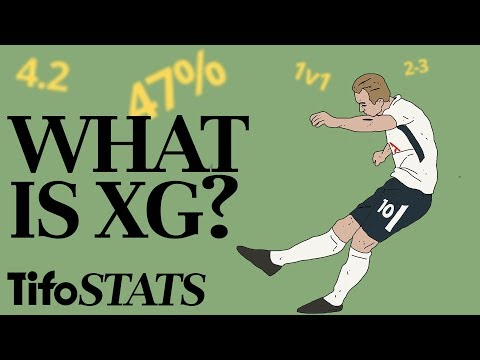

In [10]:
# What is xG? presented by Alex Stewart (@AFHStewart) for Tifo Football
YouTubeVideo('zSaeaFcm1SY')

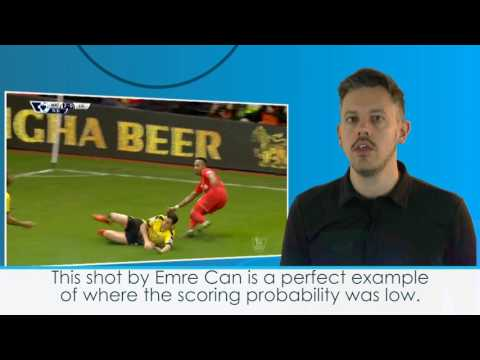

In [11]:
# Opta Expected Goals presented by Duncan Alexander (@oilysailor) for Opta
YouTubeVideo('w7zPZsLGK18')

<a id='section2.3'></a>

### <a id='#section2.3'>2.3. Modelling Approach</a>
This model will first create Logistic Regression model, for which the approach taken in this notebook can be defined as the following:

*    <b>Import data and initial data handling</b>: import CSV file as a pandas DataFrame and conduct basic data exploration ([section 3](#section3));
*    <b>Data Engineering</b>: convert pitch dimensions to match those used with Metrica Sports data, clean the data, and subset the data for Open Play shots i.e. shots that are not Penalties or Free Kicks ([section 4](#section4));
*    <b>Model selection:</b> selection of the Machine Learning algorithms used for this Expected Goals model ([section 5](#section5));
*    <b>Initial modeling:</b> build first logistic model as a baseline ([section 6](#section6));
*    <b>Bias detection:</b> understand the inherit bias of the dataset provided ([section 7](#section7));
*    <b>Metric definition:</b> define appropriate metrics for a Logistic Regression model to predict probabilities of goals scored and rule out inappropriate metrics ([section 8](#section8));
*    <b>Treating outliers:</b> find and treat outliers in the dataset to improve model ([section 9](#section9));
*    <b>Univariate analysis:</b> engineer the first set of features to be usable in our logistic regression approach ([section 10](#section10));
*    <b>Feature engineering:</b> createe additional features for dataset and evaluate as to whether their inclusion improves the model performance ([section 11](#section11));
*    <b>Multivariate analysis:</b> analysis the complete set of features and their correlations. ([section 12](#section12));
*    <b>Final model:</b> productionise final model and assess for performance performance ([section 13](#section13)); and
*    <b>Feature interpretation:</b> Interpret model features ([section 14](#section14)).

---

<a id='section3'></a>

## <a id='#section3'>3. Data Sources</a>
The following cells read in the Opta Event data and 

<a id='section3.1'></a>

### <a id='#section3.1'>3.1. Data Dictionary</a>
The raw Events DataFrame has sixty eight features (columns). Each row consists of a event.

Each feature in the datasets has the following definitions and data types, as per the official documentation:

| No.      | Feature                    | Data Type     | Description                                            |
|----------|----------------------------|---------------|--------------------------------------------------------|
| 1.       | `id`                       | float64       |                                                        |
| 2.       | `eventId`                  | float64       |                                                        |
| 3.       | `minute`                   | float64       | minute of the match in which the event took place      |
| 4.       | `second`                   | float64       | second of match_minute in which the shot was taken     |
| 5.       | `teamId`                   | float64       |                                                        |
| 6.       | `x`                        | float64       |                                                        |
| 7.       | `y`                        | float64       |                                                        |
| 8.       | `expandedMinute`           | float64       |                                                        |
| 9.       | `period`                   | object        |                                                        |
| 10.      | `type`                     | object        |                                                        |
| 11.      | `outcomeType`              | object        |                                                        |
| 12.      | `qualifiers`               | object        |                                                        |
| 13.      | `satisfiedEventsTypes`     | object        |                                                        |
| 14.      | `isTouch`                  | bool          |                                                        |
| 15.      | `playerId`                 | float64       |                                                        |
| 16.      | `endX`                     | float64       |                                                        |
| 17.      | `endY`                     | float64       |                                                        |
| 18.      | `blockedX`                 | float64       |                                                        |
| 19.      | `blockedY`                 | float64       |                                                        |
| 20.      | `goalMouthZ`               | float64       |                                                        |
| 21.      | `goalmouthY`               | float64       |                                                        |
| 22.      | `isShot`                   | object        |                                                        |
| 23.      | `relatedEventId`           | float64       |                                                        |
| 24.      | `relatedPlayerId`          | float64       |                                                        |
| 25.      | `cardType`                 | object        |                                                        |
| 26.      | `isGoal`                   | object        |                                                        |
| 27.      | `periodId`                 | float64       |                                                        |
| 28.      | `typeId`                   | float64       |                                                        |
| 29.      | `outcomeTypeId`            | float64       |                                                        |
| 30.      | `periodName`               | object        |                                                        |
| 31.      | `typeName `                | object        |                                                        |
| 32.      | `outcomeTypeName`          | object        |                                                        |
| 33.      | `matchId`                  | int64         |                                                        |
| 34.      | `timeStamp`                | float64       |                                                        |
| 35.      | `attendance`               | float64       |                                                        |
| 36.      | `venueName`                | object        |                                                        |
| 37.      | `refereeName`              | object        |                                                        |
| 38.      | `weatherCode`              | object        |                                                        |
| 39.      | `startTime`                | object        |                                                        |
| 40.      | `matchDate`                | object        |                                                        |
| 41.      | `finalScore`               | object        |                                                        |
| 42.      | `htScore`                  | object        |                                                        |
| 43.      | `ftScore`                  | object        |                                                        |
| 44.      | `etScore`                  | float64       |                                                        |
| 45.      | `pkScore`                  | float64       |                                                        |
| 46.      | `homeGoals`                | int64         |                                                        |
| 47.      | `awayGoals`                | int64         |                                                        |
| 48.      | `statusCode`               | int64         |                                                        |
| 49.      | `periodCode`               | int64         |                                                        |
| 50.      | `homeTeamId`               | int64         |                                                        |
| 51.      | `homeTeamName`             | object        |                                                        |
| 52.      | `awayTeamId`               | int64         |                                                        |
| 53.      | `awayTeamName`             | object        |                                                        |
| 54.      | `fullFixture`              | object        |                                                        |
| 55.      | `homeFormationId`          | float64       |                                                        |
| 56.      | `homeFormationName`        | float64       |                                                        |
| 57.      | `awayFormationId`          | float64       |                                                        |
| 58.      | `awayFormationName`        | float64       |                                                        |
| 59.      | `name`                     | object        |                                                        |
| 60.      | `number`                   | float64       |                                                        |
| 61.      | `position`                 | object        |                                                        |
| 62.      | `isStarter`                | object        |                                                        |
| 63.      | `isManOfTheMatch`          | object        |                                                        |
| 64.      | `finalPlayerRating`        | float64       |                                                        |
| 65.      | `finalTeamRating`          | float64       |                                                        |
| 66.      | `relatedPlayerName`        | object        |                                                        |
| 67.      | `relatedPlayerNumber`      | float64       |                                                        |
| 68.      | `relatedPlayerPosition`    | object        |                                                        |

Three features that contain a lot of information, to be defined:
*     Event Types (`type`)
*     Qualifier Types (`qualifiers`)
*     Satisfied Event Types (`satisfiedEventsTypes`)

###### Event Types
Specifically with the `typeName` attribute (Event Type) of the Event data, there are 74 different types (65 as oer the Opta F24 Appendices documentation).

**Note:** there are 7 event types missing from the definitions list as they are not observed in the event data . The IDs of these Events are: 26, 29, 31, 33, 46, 48, 62.

For the event types that were available in the documentation and observed in the event data, they have the following Ids and definitions ((see the Opta F24 Appendices document [[link](https://github.com/eddwebster/football_analytics/blob/master/docs/opta/f24_appendices.docx)] and also the WhoScored! glossary [[link](https://www.whoscored.com/Glossary)]). 

| No.       | `typeName`                          | `typeId`       | Definition                                    |
|-----------|-------------------------------------|----------------|-----------------------------------------------|
| 1.        | `Pass`                              | `1`            | Any pass attempted from one player to another – free kicks, corners, throw ins, goal kicks and goal assists    |
| 2.        | `Offside Pass`                      | `2`            | Attempted pass made to a player who is in an offside position    |
| 3.        | `Take On`                           | `3`            | Attempted dribble past an opponent (excluding when qualifier 211 is present as this is ‘overrun’ and is not always a duel event)    |
| 4.        | `Foul`                              | `4`            | This event is shown when a foul is committed resulting in a free kick    |
| 5.        | `Out`                               | `5`            | Shown each time the ball goes out of play for a throw-in or goal kick    |
| 6.        | `Corner Awarded`                    | `6`            | Ball goes out of play for a corner kick    |
| 7.        | `Tackle`                            | `7`            | Tackle = dispossesses an opponent of the ball - Outcome 1 = win & retain possession or out of play, 0 = win tackle but not possession    |
| 8.        | `Interception`                      | `8`            | When a player intercepts any pass event between opposition players and prevents the ball reaching its target. Cannot be a clearance.    |
| 9.        | `Turnover`                          | `9`            | Unforced error / loss of possession - i.e. bad control of ball – NO LONGER USED (Replaced with Unsuccessful Touch + Overrun)    |
| 10.        | `Save`                             | `10`            | Goalkeeper event; saving a shot on goal. Can also be an outfield player event with qualifier 94 for blocked shot    |
| 11.        | `Claim`                            | `11`            | Goalkeeper event; catching a crossed ball    |
| 12.        | `Clearance`                        | `12`            | Player under pressure hits the ball clear of the defensive zone or/and out of play    |
| 13.        | `MissedShots` or `Miss`            | `13`            | Any shot on goal which goes wide or over the goal    |
| 14.        | `ShotOnPost` or `Post`             | `14`            | Whenever the ball hits the frame of the goal    |
| 15.        | `SavedShot` or `Attempt Saved`     | `15`            | Shot saved - this event is for the player who made the shot. Qualifier 82 can be added for blocked shot.    |
| 16.        | `Goal`                             | `16`            | All goals    |
| 17.        | `Card`                             | `17`            | Bookings; will have red, yellow or 2nd yellow qualifier plus a reason    |
| 18.        | `SubstitutionOff` or`Player off`   | `18`            | Player is substituted off    |
| 19.        | `SubstitutionOn` or `Player on`    | `19`            | Player comes on as a substitute    |
| 20.        | `Player retired`                   | `20`            | Player is forced to leave the pitch due to injury and the team have no substitutions left    |
| 21.        | `Player returns`                   | `21`            | Player comes back on the pitch    |
| 22.        | `Player becomes goalkeeper`        | `22`            | When an outfield player has to replace the goalkeeper    |
| 23.        | `Goalkeeper becomes player`        | `23`            | If goalkeeper becomes an outfield player    |
| 24.        | `Condition change`                 | `24`            | Change in playing conditions    |
| 25.        | `Official change`                  | `25`            | Referee or linesman is replaced    |
| 26.        |                                    | `26`            |        |
| 27.        | `Start delay`                      | `27`            | Used when there is a stoppage in play such as a player injury    |
| 28.        | `End delay`                        | `28`            | Used when the stoppage ends and play resumes    |
| 29.        |                                    |                 |        |
| 30.        | `End`                              | `30`            | End of a match period    |
| 31.        |                                    |                 |        |
| 32.        | `Start`                            | `32`            | Start of a match period    |
| 33.        |                                    |                 |        |
| 34.        | `FormationSet` or `Team set up`    | `34`            | Team line up; qualifiers 30, 44, 59, 130, 131 will show player line up and formation    |
| 35.        | `Player changed position`          | `35`            | Player moved to a different position but the team formation remained the same    |
| 36.        | `Player changed Jersey number`     | `36`            | Player is forced to change jersey number, qualifier will show the new number    |
| 37.        | `Collection End`                   | `37`            | Event 30 signals end of half. This signals end of the match and thus data collection.    |
| 38.        | `Temp_Goal`                        | `38`            | Goal has occurred but it is pending additional detail qualifiers from Opta. Will change to event 16.    |
| 39.        | `Temp_Attempt`                     | `39`            | Shot on goal has occurred but is pending additional detail qualifiers from Opta. Will change to event 15.    |
| 40.        | `FormationChange` or `Formation change`      | `40`            | Team alters its formation    |
| 41.        | `Punch`                            | `41`            | Goalkeeper event; ball is punched clear    |
| 42.        | `GoodSkill` or `Good Skill`        | `42`            | A player shows a good piece of skill on the ball Ð such as a step over or turn on the ball Ð NO LONGER USED    |
| 43.        | `Deleted event`                    | `43`            | Event has been deleted Ð the event will remain as it was originally with the same ID but will be resent with the type altered to 43.    |
| 44.        | `Aerial`                           | `44`            | Aerial duel Ð 50/50 when the ball is in the air Ð outcome will represent whether the duel was won or lost    |
| 45.        | `Challenge`                        | `45`            | When a player fails to win the ball as an opponent successfully dribbles past them    |
| 46.        |                                    |                 |        |
| 47.        | `Rescinded card`                   | `47`            | This can occur post match if the referee rescinds a card he has awarded    |
| 48.        |                                    | `48`            |        |
| 49.        | `BallRecovery` or `Ball recovery`                    | `49`            | Team wins the possession of the ball and successfully keeps possession for at least two passes or an attacking play    |
| 50.        | `Dispossessed`                     | `50`            | Player is successfully tackled and loses possession of the ball    |
| 51.        | `Error`                            | `51`            | Mistake by player losing the ball. Leads to a shot or goals as described with qualifier 169 or 170    |
| 52.        | `KeeperPickup` or `Keeper pick-up`                   | `52`            | Goalkeeper event; picks up the ball    |
| 53.        | `CrossNotClaimed` or `Cross not claimed`                | `53`            | Goalkeeper event; cross not successfully caught    |
| 54.        | `Smother`                          | `54`            | Goalkeeper event; comes out and covers the ball in the box winning possession    |
| 55.        | `OffsideProvoked` or `Offside provoked`                 | `55`            | Awarded to last defender when an offside decision is given against an attacker    |
| 56.        | `ShieldBallOpp` or `Shield ball opp`                  | `56`            | Defender uses his body to shield the ball from an opponent as it rolls out of play    |
| 57.        | `Foul throw-in`                    | `57`            | A throw-in not taken correctly resulting in the throw being awarded to the opposing team    |
| 58.        | `PenaltyFaced` or `Penalty faced`     | `58`            | Goalkeeper event; penalty by opposition team    |
| 59.        | `KeeperSweeper` or `Keeper Sweeper`     | `59`            | When keeper comes off his line and/or out of his box to clear the ball    |
| 60.        | `ChanceMissed` or `Chance missed`  | `60`            | Used when a player does not actually make a shot on goal but was in a good position to score and on`ly just missed receiving a pass    |
| 61.        | `BallTouch` or `Ball touch`        | `61            | Used when a player makes a bad touch on the ball and loses possession. Outcome 1 Ð ball simply hit the player unintentionally. Outcome 0 Ð Player unsuccessfully controlled the ball.    |
| 62.        |                                    |                 |        |
| 63.        | `Temp_Save`                        | `63`            | An event indicating a save has occurred but without full details. Event 10 will follow shortly afterwards with full details.    |
| 64.        | `Resume`                           | `64`            | Match resumes on a new date after being abandoned mid game.    |
| 65.        | `Contentious referee decision`     | `65`            | Any major talking point or error made by the referee Ð decision will be assigned to the relevant team    |
| 66.        | `Possession Data`                  | `66`            | Possession event will appear every 5 mins    |
| 67.        | `50/50`                            | `67`            | 	New duel - 2 players running for a loose ball - GERMAN ONLY. Outcome 1 or 0.    |
| 68.        | `Referee Drop Ball`                | `68`            | Delay - ref stops - this to event given to both teams on restart. No Outcome    |
| 69.        | `Failed to Block`                  | `69`            | New duel (put through-Q266 is the winning duel event). Attempt to block a shot or pass - challenge lost    |
| 70.        | `Injury Time Announcement`         | `70`            | Injury Time awarded by Referee    |
| 71.        | `Coach Setup`                      | `71`            | Coach Type; 1,2,18,30,32,54,57,58,59    |
| 72.        | `Caught Offside`                   | `72`            | 	New event to just show player who is offside instead of offside pass event    |
| 73.        | `Other Ball Contact`               | `73`            | This is an automated extra event for DFL. It comes with a tackle or an interception and indicates if the player who made the tackle/interception retained the ball after this action or if the tackle/interception was a single ball touch (other ball contact with type “interception”, type “Defensive Clearance” or type “ TackleRetainedBall).    |
| 74.        | `Blocked Pass`                     | `74`            | Defender is close to player in possession and blocks a pass. Different from interception which is where the player has moved to intercept.    |

In [12]:
"""
# Code to display all the event types observed in the event data

## Define columns
cols_event_types = ['typeName',
                    'typeId'
                   ]

## Select columns of interest
df_opta_events_types_select = df_opta_events[cols_event_types]

## Drop duplicates
df_opta_events_types_select = df_opta_events_types_select.drop_duplicates()

## Order rows by Id
df_opta_events_types_select = df_opta_events_types_select.sort_values(['typeId'], ascending=[True])

## Display DataFrame
df_opta_events_types_select
"""

"\n# Code to display all the event types observed in the event data\n\n## Define columns\ncols_event_types = ['typeName',\n                    'typeId'\n                   ]\n\n## Select columns of interest\ndf_opta_events_types_select = df_opta_events[cols_event_types]\n\n## Drop duplicates\ndf_opta_events_types_select = df_opta_events_types_select.drop_duplicates()\n\n## Order rows by Id\ndf_opta_events_types_select = df_opta_events_types_select.sort_values(['typeId'], ascending=[True])\n\n## Display DataFrame\ndf_opta_events_types_select\n"

###### Qualifier Types
There are 229 different qualifiers with the following Ids and definitions (see the Opta F24 Appendices document [[link](https://github.com/eddwebster/football_analytics/blob/master/docs/opta/f24_appendices.docx)]). Also see the definitions on the Stats Perform website [[link](https://www.statsperform.com/opta-event-definitions/)])

**Note:** these Qualifier Types are not to be confused with the 219 Satisified Event Types (see below), that are available in the JSON string extracted from [WhoScored!](https://www.whoscored.com/).

**Note:** there are 19 qualifier types missing from the definitions list as they are not observed in the event data. The IDs of these Events are: 27, 43, 52, 58, 98, 99, 104, 105, 125, 126, 129, 142, 143, 148, 149, 150, 151, 152, 193.


| No.      | `qualifierTypeName`               | `qualifierTypeId`     | Values                        | Definition                                                                                                                                 | Qualifier Category             | Associated Event Type (`typeName`)      |
|----------|-----------------------------------|-----------------------|-------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------|-----------------------------------------|
| 1.       | `Long ball`                       | `1`                   |                               | Long pass over 35 yards                                                                                                                    | Pass Events                    | 1                                       |
| 2.       | `Cross`                           | `2`                   |                               | A ball played in from wide areas into the box                                                                                              | Pass Events                    | 1                                       |
| 3.       | `Head pass`                       | `3`                   |                               | Pass made with a players head                                                                                                              | Pass Events                    | 1                                       |
| 4.       | `Through ball`                    | `4`                   |                               | Ball played through for player making an attacking run to create a chance on goal                                                          | Pass Events                    | 1                                       |
| 5.       | `Free kick taken`                 | `5`                   |                               | Any free kick; direct or indirect                                                                                                          | Pass Events                    | 1                                       |
| 6.       | `Corner taken`                    | `6`                   |                               | All corners. Look for qualifier 6 but excluding qualifier 2 for short corners                                                              | Pass Events                    | 1                                       |
| 7.       | `Players caught offside`          | `7`                   | Player ID                     | Player who was in an offside position when pass was made.                                                                                  | Pass Events                    | 1                                       |
| 8.       | `Goal disallowed`                 | `8`                   |                               | Pass led to a goal disallowed for a foul or offside                                                                                        | Pass Events                    | 1                                       |
| 9.       | `Penalty`                         | `9`                   |                               | When attempt on goal was a penalty kick. ALSO used on Event type 4 to indicate a penalty was awarded                                       | Shot Descriptors               | 13, 14, 15, 16                          |
| 10.      | `Hand`                            | `10`                  |                               | Handball                                                                                                                                   | Foul & Card Events             | 4                                       |
| 11.      | `6-seconds violation`             | `11`                  |                               | Goalkeeper held onto the ball longer than 6 seconds resulting in a free kick                                                               | Foul & Card Events             | 4                                       |
| 12.      | `Dangerous play`                  | `12`                  |                               | A foul due to dangerous play                                                                                                               | Foul & Card Events             | 4                                       |
| 13.      | `Foul`                            | `13`                  |                               | All fouls                                                                                                                                  | Foul & Card Events             | 4                                       |
| 14.      | `Last line`                       | `14`                  |                               | When a player makes a defensive action and they are the last person between the opponent and the goal                                      | Defensive Events               |                                         |
| 15.      | `Head`                            | `15`                  |                               | Any event where the player used their head such as a shot or a clearance                                                                   | Body Part                      |                                         |
| 16.      | `Small box-centre`                | `16`                  |                               | Zone of the pitch - See appendix 7                                                                                                         | Shot Location Descriptors      |                                         |
| 17.      | `Box-centre`                      | `17`                  |                               | Zone of the pitch - See appendix 7                                                                                                         | Shot Location Descriptors      |                                         |
| 18.      | `Out of box-centre`               | `18`                  |                               | Zone of the pitch - See appendix 7                                                                                                         | Shot Location Descriptors      |                                         |
| 19.      | `35+ centre`                      | `19`                  |                               | Zone of the pitch - See appendix 7                                                                                                         | Shot Location Descriptors      |                                         |
| 20.      | `Right footed`                    | `20`                  |                               | Player shot with right footed                                                                                                              | Body Part                      |                                         |
| 21.      | `Other body part`                 | `21`                  |                               | Shot was neither via a player’s head or foot for example knee or chest                                                                     | Body Part                      |                                         |
| 22.      | `Regular play`                    | `22`                  |                               | Shot during open play as opposed to from a set play                                                                                        | Pattern of Play                | 13, 14, 15, 16                          |
| 23.      | `Fast break`                      | `23`                  |                               | Shot occurred following a fast break situation                                                                                             | Pattern of Play                | 13, 14, 15, 16                          |
| 24.      | `Set piece`                       | `24`                  |                               | Shot occurred from a crossed free kick                                                                                                     | Pattern of Play                | 13, 14, 15, 16                          |
| 25.      | `From corner`                     | `25`                  |                               | Shot occurred from a corner                                                                                                                | Pattern of Play                | 13, 14, 15, 16                          |
| 26.      | `Free kick`                       | `26`                  |                               | Shot occurred directly from a free kick                                                                                                    | Pattern of Play                | 13, 14, 15, 16                          |
| 27.      |                                   |                       |                               |                                                                                                                                            |                                |                                         |
| 28.      | `own goal`                        | `28`                  |                               | Own goal. Note: Use the inverse coordinates of the goal location                                                                           | Shot Descriptors               | 13, 14, 15, 16                          |
| 29.      | `Assisted`                        | `29`                  |                               | Indicates that there was a pass (assist) from another player to set up the goal opportunity                                                | Line Up / Subs / Formation     | 13, 14, 15, 16                          |
| 30.      | `Involved`                        | `30`                  |                               | Player ID's in line up                                                                                                                     | Foul & Card Events             | 32, 34, 35, 36, 40                      |
| 31.      | `Yellow Card`                     | `31`                  |                               | Player shown a yellow card                                                                                                                 | Foul & Card Events             |                                         |
| 32.      | `Second yellow`                   | `32`                  |                               | Player receives a 2nd yellow card which automatically results in a red card                                                                | Foul & Card Events             |                                         |
| 33.      | `Red Card`                        | `33`                  |                               | Player shown a straight red card                                                                                                           | Foul & Card Events             |                                         |
| 34.      | `Referee abuse`                   | `34`                  |                               | Card shown to player because of abuse to the referee                                                                                       | Foul & Card Events             | 4                                       |
| 35.      | `Argument`                        | `35`                  |                               | Card shown to player because of an argument                                                                                                | Foul & Card Events             | 4                                       |
| 36.      | `Fight`                           | `36`                  |                               | Card shown to player because of their involvement in a fight                                                                               | Foul & Card Events             | 4                                       |
| 37.      | `Time wasting`                    | `37`                  |                               | Card shown to player for time wasting                                                                                                      | Foul & Card Events             | 4                                       |
| 38.      | `Excessive celebration`           | `38`                  |                               | Card shown to player for excessively celebrating a goal                                                                                    | Foul & Card Events             | 4                                       |
| 39.      | `Crowd interaction`               | `39`                  |                               | Card shown to player because of contact or communication with the crowd                                                                    | Foul & Card Events             | 4                                       |
| 40.      | `Other reason`                    | `40`                  |                               | Card shown for unknown reason                                                                                                              | Foul & Card Events             | 4                                       |
| 41.      | `Injury`                          | `41`                  |                               | Substitution, event 18, because of injury                                                                                                  | Line Up / Subs / Formation     | 32, 34, 35, 36, 40                      |
| 42.      | `Tactical`                        | `42`                  |                               | Substitution, event 18 for tactical reasons                                                                                                | Line Up / Subs / Formation     | 32, 34, 35, 36, 40                      |
| 43.      |                                   |                       |                               |                                                                                                                                            |                                |                                         |
| 44.      | `Player Position`                 | `44`                  | Dynamic                       | Goalkeeper, Defender, Midfielder, Forward or Substitute. These are the default / natural positions associated with each player and not necessarily the position they played in the match; see qualifier 131 for this.                           | Line Up / Subs / Formation     | 32, 34, 35, 36, 40                     |
| 45.      | `Temperature`                     | `45`                  |                               | ...                                                                                                                                        | ...                            |                                         |
| 46.      | `Conditions`                      | `46`                  |                               | ...                                                                                                                                        | ...                            |                                         |
| 47.      | `Field Pitch`                     | `47`                  |                               | ...                                                                                                                                        | ...                            |                                         |
| 48.      | `Lightings`                       | `48`                  |                               | ...                                                                                                                                        | ...                            |                                         |
| 49.      | `Attendance figure`               | `49`                  | Dynamic                       | Number of people in the crowd                                                                                                              | Attendance                     |                                         |
| 50.      | `Official position`               | `50`                  | 1, 2, 3, 4                    | Referee, Linesman#1, Linesman#2, Forth official                                                                                            | Referee                        |                                         |
| 51.      | `Official Id`                     | `51`                  | Official ID                   | Unique ID for the official                                                                                                                 | Referee                        |                                         |
| 52.      |                                   |                       |                               |                                                                                                                                            |                                |                                         |
| 53.      | `Injured player id`               | `53`                  | ID of player injured          | ID of the player who is injured and causing a delay in the game                                                                            | Stoppages                      | 27                                      |
| 54.      | `End cause`                       | `54`                  | 1,2,3,4,5,6,7,99,100          | Golden goal, weather, crowd, insufficient players, floodlight failure, frozen pitch, waterlogged pitch, other, unknown                     | General                        |                                         |
| 55.      | `Related event ID`                | `55`                  | Event_id                      | This will appear for goals or shots, the related event_id will be that of the assist and thus show the assisting player ID                 | Pattern of Play                | 13, 14, 15, 16                          |
| 56.      | `Zone`                            | `56`                  | Back, left, centre, right     | Area on the pitch - see appendix 7                                                                                                         | General                        |                                         |
| 57.      | `End type`                        | `57`                  | End of the match              | This will be shown for substitutions, line ups, line up changes                                                                            | General                        |                                         |
| 58.      |                                   |                       |                               |                                                                                                                                            |                                |                                         |
| 59.      | `Jersey Number`                   | `59`                  | Shirt number of player(s)     | This will be shown for substitutions, line ups, line up changes                                                                            | Line Up / Subs / Formation     | 32, 34, 35, 36, 40                      |
| 60.      | `Small box-right`                 | `60`                  |                               | Zone of the pitch - See appendix 7                                                                                                         | Shot Location Descriptors      |                                         |
| 61.      | `Small box-left`                  | `61`                  |                               | Zone of the pitch - See appendix 7                                                                                                         | Shot Location Descriptors      |                                         |
| 62.      | `Box-deep right`                  | `62`                  |                               | Zone of the pitch - See appendix 7                                                                                                         | Shot Location Descriptors      |                                         |
| 63.      | `Box-right`                       | `63`                  |                               | Zone of the pitch - See appendix 7                                                                                                         | Shot Location Descriptors      |                                         |
| 64.      | `Box-left`                        | `64`                  |                               | Zone of the pitch - See appendix 7                                                                                                         | Shot Location Descriptors      |                                         |
| 65.      | `Box-deep left`                   | `65`                  |                               | Zone of the pitch - See appendix 7                                                                                                         | Shot Location Descriptors      |                                         |
| 66.      | `Out of box-deep right`           | `66`                  |                               | Zone of the pitch - See appendix 7                                                                                                         | Shot Location Descriptors      |                                         |
| 67.      | `Out of box-right`                | `67`                  |                               | Zone of the pitch - See appendix 7                                                                                                         | Shot Location Descriptors      |                                         |
| 68.      | `Out of box-left`                 | `68`                  |                               | Zone of the pitch - See appendix 7                                                                                                         | Shot Location Descriptors      |                                         |
| 69.      | `Out of box-deep left`            | `69`                  |                               | Zone of the pitch - See appendix 7                                                                                                         | Shot Location Descriptors      |                                         |
| 70.      | `35+ right`                       | `70`                  |                               | Zone of the pitch - See appendix 7                                                                                                         | Shot Location Descriptors      |                                         |
| 71.      | `35+ left`                        | `71`                  |                               | Zone of the pitch - See appendix 7                                                                                                         | Shot Location Descriptors      |                                         |
| 72.      | `Left footed`                     | `72`                  |                               | Player shot with their left foot                                                                                                           | Body Part                      |                                         |
| 73.      | `Left`                            | `73`                  |                               | Hit the left post or missed left                                                                                                           | Shot Location Descriptors      |                                         |
| 74.      | `High`                            | `74`                  |                               | Hit crossbar or missed over                                                                                                                | Shot Location Descriptors      |                                         |
| 75.      | `Right`                           | `75`                  |                               | Hit right post or missed right                                                                                                             | Shot Location Descriptors      |                                         |
| 76.      | `Low Left`                        | `76`                  |                               | Zone of the goalmouth - See appendix 6                                                                                                     | Shot Location Descriptors      |                                         |
| 77.      | `High Left`                       | `77`                  |                               | Zone of the goalmouth - See appendix 6                                                                                                     | Shot Location Descriptors      |                                         |
| 78.      | `Low Centre`                      | `78`                  |                               | Zone of the goalmouth - See appendix 6                                                                                                     | Shot Location Descriptors      |                                         |
| 79.      | `High Centre`                     | `79`                  |                               | Zone of the goalmouth - See appendix 6                                                                                                     | Shot Location Descriptors      |                                         |
| 80.      | `Low Right`                       | `80`                  |                               | Zone of the goalmouth - See appendix 6                                                                                                     | Shot Location Descriptors      |                                         |
| 81.      | `High Right`                      | `81`                  |                               | Zone of the goalmouth - See appendix 6                                                                                                     | Shot Location Descriptors      |                                         |
| 82.      | `Blocked`                         | `82`                  |                               | Zone of the goalmouth - See appendix 6                                                                                                     | Shot Location Descriptors      |                                         |
| 83.      | `Close Left`                      | `83`                  |                               | Zone of the goalmouth - See appendix 6                                                                                                     | Shot Location Descriptors      |                                         |
| 84.      | `Close Right`                     | `84`                  |                               | Zone of the goalmouth - See appendix 6                                                                                                     | Shot Location Descriptors      |                                         |
| 85.      | `Close High`                      | `85`                  |                               | Zone of the goalmouth - See appendix 6                                                                                                     | Shot Location Descriptors      |                                         |
| 86.      | `Close Left and High`             | `86`                  |                               | Zone of the goalmouth - See appendix 6                                                                                                     | Shot Location Descriptors      |                                         |
| 87.      | `Close Right and High`            | `87`                  |                               | Zone of the goalmouth - See appendix 6                                                                                                     | Shot Location Descriptors      |                                         |
| 88.      | `High claim`                      | `88`                  |                               | Event 11 Claim - Goalkeeper claims possession of a crossed ball                                                                            | Goalkeeper Events              | 10, 11, 12                              |
| 89.      | `1 on 1`                          | `89`                  |                               | Event 10 Save; when attacker was clear with no defenders between him and the goalkeeper                                                    | Goalkeeper Events              | 10, 11, 12                              |
| 90.      | `Deflected save`                  | `90`                  |                               | Event 10 Save; when goalkeeper saves a shot but does not catch the ball                                                                    | Goalkeeper Events              | 10, 11, 12                              |
| 91.      | `Dive and deflect`                | `91`                  |                               | Event 10 Save; when goalkeeper saves a shot while diving but does not catch the ball                                                       | Goalkeeper Events              | 10, 11, 12                              |
| 92.      | `Catch`                           | `92`                  |                               | Event 10 Save; when goalkeeper saves a shot and catches it                                                                                 | Goalkeeper Events              | 10, 11, 12                              |
| 93.      | `Dive and catch`                  | `93`                  |                               | Event 10 Save; when goalkeeper saves a shot while diving and catches it                                                                    | Goalkeeper Events              | 10, 11, 12                              |
| 94.      | `Def block`                       | `94`                  |                               | Defender blocks an opposition shot. Shown with event 10.                                                                                   | Defensive Events               |                                         |
| 95.      | `Back pass`                       | `95`                  |                               | Free kick given for an illegal pass to the goalkeeper which was collected by his hands or picked up                                        | Foul & Card Events             | 4                                       |
| 96.      | `Corner situation`                | `96`                  |                               | Pass or shot event in corner situation. 25 is used when the goal is direct from corner, 96 relates to 2nd phase attack.                    | Pattern of Play                | 13, 14, 15, 16                          |
| 97.      | `Direct free`                     | `97`                  |                               | 26 will be used for shot directly from a free kick. 97 only used with Opta GoalData (game system 4) but not with full data.                | Pattern of Play                | 13, 14, 15, 16                          |
| 98.      |                                   |                       |                               |                                                                                                                                            |                                |                                         |
| 99.      |                                   |                       |                               |                                                                                                                                            |                                |                                         |
| 100.     | `Six Yard Blocked`                | `100`                 |                               | Shot blocked on the 6 yard line                                                                                                            | Shot Location Descriptors      |                                         |
| 101.     | `Saved Off Line`                  | `101`                 |                               | Shot saved on the goal line                                                                                                                | Shot Location Descriptors      |                                         |
| 102.     | `Goal Mouth Y Coordinate`         | `102`                 | 0-100                         | Y Co-ordinate of where a shot crossed goal line - see Appendix 4                                                                           | Shot Location Descriptors      |                                         |
| 103.     | `Goal Mouth Z Coordinate`         | `103`                 | 0-100                         | Z Co-ordinate for height at which a shot crossed the goal line - see Appendix 4                                                            | Shot Location Descriptors      |                                         |
| 104.     |                                   |                       |                               |                                                                                                                                            |                                |                                         |
| 105.     |                                   |                       |                               |                                                                                                                                            |                                |                                         |
| 106.     | `Attacking Pass`                  | `106`                 |                               | A pass in the opposition’s half of the pitch                                                                                               | Pass Events                    | 1                                       |
| 107.     | `Throw In`                        | `107`                 |                               | Throw-in taken                                                                                                                             | Pass Events                    | 1                                       |
| 108.     | `Volley`                          | `108`                 |                               |                                                                                                                                            | ...                            |                                         |
| 109.     | `Overhead`                        | `109`                 |                               |                                                                                                                                            | ...                            |                                         |
| 110.     | `Half Volley`                     | `110`                 |                               |                                                                                                                                            | ...                            |                                         |
| 111.     | `Diving Header`                   | `111`                 |                               |                                                                                                                                            | ...                            |                                         |
| 112.     | `Scramble`                        | `112`                 |                               | Goal where there was a scramble for possession of the ball and the defence had an opportunity to clear                                     | Pattern of Play                | 13, 14, 15, 16                          |
| 113.     | `Strong`                          | `113`                 |                               | Shot was subjectively classed as strong                                                                                                    | Shot Descriptors               | 13, 14, 15, 16                          |
| 114.     | `Weak`                            | `114`                 |                               | Shot was subjectively classed as weak                                                                                                      | Shot Descriptors               | 13, 14, 15, 16                          |
| 115.     | `Rising`                          | `115`                 |                               | Shot was rising in the air                                                                                                                 | Shot Descriptors               | 13, 14, 15, 16                          |
| 116.     | `Dipping`                         | `116`                 |                               | Shot was dipping towards the ground                                                                                                        | Shot Descriptors               | 13, 14, 15, 16                          |
| 117.     | `Lob`                             | `117`                 |                               | Shot was an attempt by the attacker to play the ball over the goalkeeper and into the goal                                                 | Shot Descriptors               | 13, 14, 15, 16                          |
| 118.     | `One Bounce`                      | `118`                 |                               |                                                                                                                                            | Shot Descriptors               | 13, 14, 15, 16                          |
| 119.     | `Few Bounces`                     | `119`                 |                               |                                                                                                                                            | Shot Descriptors               | 13, 14, 15, 16                          |
| 120.     | `Swerve Left`                     | `120`                 |                               | Shot which swerves to the left - from attackers perspective                                                                                | Shot Descriptors               | 13, 14, 15, 16                          |
| 121.     | `Swerve Right`                    | `121`                 |                               | Shot which swerves to the right - from attackers perspective                                                                               | Shot Descriptors               | 13, 14, 15, 16                          |
| 122.     | `Swerve Moving`                   | `122`                 |                               | Shot which swerves in several directions                                                                                                   | Shot Descriptors               | 13, 14, 15, 16                          |
| 123.     | `Keeper Throw`                    | `123`                 |                               | Pass event - goalkeeper throws the ball out                                                                                                | Goalkeeper Events              | 10, 11, 12                              |
| 124.     | `Goal Kick`                       | `124`                 |                               | Pass event – goal kick                                                                                                                     | Goalkeeper Events              | 10, 11, 12                              |
| 125.     |                                   |                       |                               |                                                                                                                                            |                                |                                         |
| 126.     |                                   |                       |                               |                                                                                                                                            |                                |                                         |
| 127.     | `Direction of play`               | `127`                 | Right to Left                 | Event type 32 - Actual direction of play in relation to TV camera. X/Y coordinates however are ALWAYS all normalized to Left to Right.     | General                        |                                         |
| 128.     |  `Punch`                          | `128`                 |                               | Clearance by goalkeeper where he punches the ball clear                                                                                    | Goalkeeper Events              | 10, 11, 12                              |
| 129.     |                                   |                       |                               |                                                                                                                                            |                                |                                         |
| 130.     | `Team Formation`                  | `130`                 | Formation ID                  | See appendix 8                                                                                                                             | Line Up / Subs / Formation     | 32, 34, 35, 36, 40                      |
| 131.     | `Team Player Formation`           | `131`                 | 1 to 11                       | Player position within a formation - 'See appendix 8                                                                                       | Line Up / Subs / Formation     | 32, 34, 35, 36, 40                      |
| 132.     | `Dive`                            | `132`                 |                               | Free kick or card event; player penalised for simulation                                                                                   | Foul & Card Events             | 4                                       |
| 133.     | `Deflection`                      | `133`                 |                               | Shot deflected off another player                                                                                                          | Shot Descriptors               | 13, 14, 15, 16                          |
| 134.     | `Far Wide Left`                   | `134`                 |                               |                                                                                                                                            | ...                            |                                         |
| 135.     | `Far Wide Right`                  | `135`                 |                               |                                                                                                                                            | ...                            |                                         |
| 136.     | `Keeper Touched`                  | `136`                 |                               | Goal where the goalkeeper got a touch on the ball as it went in                                                                            | Shot Descriptors               | 13, 14, 15, 16                          |
| 137.     | `Keeper Saved`                    | `137`                 |                               | Shot going wide or over the goal but still collected/saved by the goalkeeper with event type 15                                            | Shot Descriptors               | 13, 14, 15, 16                          |
| 138.     | `Hit Woodwork`                    | `138`                 |                               | Any shot which hits the post or crossbar                                                                                                   | Shot Descriptors               | 13, 14, 15, 16                          |
| 139.     | `Own Player`                      | `139`                 |                               | Shot saved by goalkeeper that was deflected by a defender                                                                                  | Goalkeeper Events              | 13, 14, 15, 16                          |
| 140.     | `Pass End X`                      | `140`                 | 0-100                         | The x pitch coordinate for the end point of a pass - See Appendix 5                                                                        | Pass Events                    | 1                                       |
| 141.     | `Pass End Y`                      | `141`                 | 0-100                         | The y pitch coordinate for the end point of a pass - See Appendix 5                                                                        | Pass Events                    | 1                                       |
| 142.     |                                   |                       |                               |                                                                                                                                            |                                |                                         |
| 143.     |                                   |                       |                               |                                                                                                                                            |                                |                                         |
| 144.     | `Deleted Event Type`              | `144`                 | Event ID                      | An event which should be removed. Value will show the ID of this event                                                                     | General                        |                                         |
| 145.     | `Formation slot`                  | `145`                 | 1 to 11                       | Formation position of a player coming on - see appendix 8                                                                                  | Line Up / Subs / Formation     | 32, 34, 35, 36, 40                      |
| 146.     | `Blocked X Coordinate`            | `146`                 | 0-100                         | The x pitch coordinate for where a shot was blocked                                                                                        | Shot Location Descriptors      |                                         |
| 147.     | `Blocked Y Coordinate`            | `147`                 | 0-100                         | The y pitch coordinate for where a shot was blocked                                                                                        | Shot Location Descriptors      |                                         |
| 148.     |                                   |                       |                               |                                                                                                                                            |                                |                                         |
| 149.     |                                   |                       |                               |                                                                                                                                            |                                |                                         |
| 150.     |                                   |                       |                               |                                                                                                                                            |                                |                                         |
| 151.     |                                   |                       |                               |                                                                                                                                            |                                |                                         |
| 152.     |                                   |                       |                               |                                                                                                                                            |                                |                                         |
| 153.     | `Not past goal line`              | `153`                 |                               | Shot missed which does not  pass the goal line                                                                                             | Shot Descriptors               | 13, 14, 15, 16                          |
| 154.     | `Intentional Assist`              | `154`                 |                               | Shot from an intentional assist i.e. The assisting player intended the pass, no deflection etc                                             | Pattern of Play                | 13, 14, 15, 16                          |
| 155.     | `Chipped`                         | `155`                 |                               | Pass which was chipped into the air                                                                                                        | Pass Events                    | 1                                       |
| 156.     | `Lay-off`                         | `156`                 |                               | Pass where player laid the ball into the path of a teammates run                                                                           | Pass Events                    | 1                                       |
| 157.     | `Launch`                          | `157`                 |                               | Pass played from a player’s own half up towards front players. Aimed to hit a zone rather than a specific player                           | Pass Events                    | 1                                       |
| 158.     | `Persistent Infringement`         | `158`                 |                               | Card shown to player for persistent fouls                                                                                                  | Foul & Card Events             | 4                                       |
| 159.     | `Foul and Abusive Language`       | `159`                 |                               | Card shown for player using foul language                                                                                                  | Foul & Card Events             | 4                                       |
| 160.     | `Throw In set piece`              | `160`                 |                               | Shot came from a throw-in set piece                                                                                                        | Pattern of Play                | 13, 14, 15, 16                          |
| 161.     | `Encroachment`                    | `161`                 |                               | Card shown for player who moves within 10 yards of an opponent’s free kick                                                                 | Foul & Card Events             | 4                                       |
| 162.     | `Leaving field`                   | `162`                 |                               | Card shown for player leaving the field without permission                                                                                 | Foul & Card Events             | 4                                       |
| 163.     | `Entering field`                  | `163`                 |                               | Card shown for player entering the field during play without referee's permission                                                          | Foul & Card Events             | 4                                       |
| 164.     | `Spitting`                        | `164`                 |                               | Card shown for spitting                                                                                                                    | Foul & Card Events             | 4                                       |
| 165.     | `Professional foul`               | `165`                 |                               | Card shown for a deliberate tactical foul                                                                                                  | Foul & Card Events             | 4                                       |
| 166.     | `Handling on the line`            | `166`                 |                               | Card shown to an outfield player for using their hand to keep the ball out of the goal                                                     | Foul & Card Events             | 4                                       |
| 167.     | `Out of play`                     | `167`                 |                               | Tackle or clearance event sent the ball out of play                                                                                        | Defensive Events               |                                         |
| 168.     | `Flick-on`                        | `168`                 |                               | Pass where a player has "flicked" the ball forward using their head                                                                        | Pass Events                    | 1                                       |
| 169.     | `Leading to attempt`              | `169`                 |                               | A player error, event 51, which leads to an opponent shot on goal                                                                          | Defensive Events               |                                         |
| 170.     | `Leading to goal`                 | `170`                 |                               | A player error, event 51, which lead to an opponent scoring a goal                                                                         | Defensive Events               |                                         |
| 171.     | `Rescinded Card`                  | `171`                 |                               | Referee rescind a card post match                                                                                                          | Foul & Card Events             | 4                                       |
| 172.     | `No impact on timing`             | `172`                 |                               | Player booked on bench but who hasn't played any minutes in the match                                                                      | Foul & Card Events             | 4                                       |
| 173.     | `Parried safe`                    | `173`                 |                               | Goalkeeper save where shot is parried to safety                                                                                            | Goalkeeper Events              | 10, 11, 12                              |
| 174.     | `Parried danger`                  | `174`                 |                               | Goalkeeper save where shot is parried but only to another opponent                                                                         | Goalkeeper Events              | 10, 11, 12                              |
| 175.     | `Fingertip`                       | `175`                 |                               | Goalkeeper save using his fingertips                                                                                                       | Goalkeeper Events              | 10, 11, 12                              |
| 176.     | `Caught`                          | `176`                 |                               | Goalkeeper catches the ball                                                                                                                | Goalkeeper Events              | 10, 11, 12                              |
| 177.     | `Collected`                       | `177`                 |                               | Goalkeeper save and collects possession of the ball                                                                                        | Goalkeeper Events              | 10, 11, 12                              |
| 178.     | `Standing`                        | `178`                 |                               | Goalkeeper save while standing                                                                                                             | Goalkeeper Events              | 10, 11, 12                              |
| 179.     | `Diving`                          | `179`                 |                               | Goalkeeper save while diving                                                                                                               | Goalkeeper Events              | 10, 11, 12                              |
| 180.     | `Stooping`                        | `180`                 |                               | Goalkeeper saves while stooping                                                                                                            | Goalkeeper Events              | 10, 11, 12                              |
| 181.     | `Reaching`                        | `181`                 |                               | Goalkeeper save where goalkeeper reaches for the ball                                                                                      | Goalkeeper Events              | 10, 11, 12                              |
| 182.     | `Hands`                           | `182`                 |                               | Goalkeeper saves with his hands                                                                                                            | Goalkeeper Events              | 10, 11, 12                              |
| 183.     | `Feet`                            | `183`                 |                               | Goalkeeper save using his feet                                                                                                             | Goalkeeper Events              | 10, 11, 12                              |
| 184.     | `Dissent`                         | `184`                 |                               | Cad shown when a player does not obey referee instructions                                                                                 | Foul & Card Events             | 4                                       |
| 185.     | `Blocked cross`                   | `185`                 |                               | Clearance; cross is blocked                                                                                                                | Defensive Events               |                                         |
| 186.     | `Scored`                          | `186`                 |                               | Goalkeeper event - shots faced and not saved resulting in goal                                                                             | Goalkeeper Events              | 10, 11, 12                              |
| 187.     | `Saved`                           | `187`                 |                               | Goalkeeper event - shots faced and saved                                                                                                   | Goalkeeper Events              | 10, 11, 12                              |
| 188.     | `Missed`                          | `188`                 |                               | Goalkeeper event - shot faced which went wide or over. Did not require a save.                                                             | Goalkeeper Events              | 10, 11, 12                              |
| 189.     | `Player Not Visible`              | `189`                 |                               | Broadcast footage showing replay and not live footage – this event is what Opta analysts believe occurred.                                 | General                        |                                         |
| 190.     | `From shot off target`            | `190`                 |                               | Used with Event 10. Indicates a shot was saved by the goalkeeper but in fact the shot was going wide and not on target                     | Goalkeeper Events              | 10, 11, 12                              |
| 191.     | `Off the ball foul`               | `191`                 |                               | Foul committed by and on a player who is not in possession of the ball                                                                     | Foul & Card Events             | 4                                       |
| 192.     | `Block by hand`                   | `192`                 |                               | Outfield player blocks a shot with their hand                                                                                              | Foul & Card Events             | 4                                       |
| 193.     |                                   |                       |                               |                                                                                                                                            |                                |                                         |
| 194.     | `Captain`                         | `194`                 | Player ID                     | ID of the player who is the team captain                                                                                                   | Line Up / Subs / Formation     | 32, 34, 35, 36, 40                      |
| 195.     | `Pull Back`                       | `195`                 |                               | Player in opposition’s penalty box reaches the by-line and passes (cuts) the ball backwards to a teammate                                  | Pass Events                    | 1                                       |
| 196.     | `Switch of play`                  | `196`                 |                               | Any pass which crosses the centre zone of the pitch and in length is greater than 60 on the y axis of the pitch                            | Pass Events                    | 1                                       |
| 197.     | `Team kit`                        | `197`                 | Kit ID                        | Kit of the team                                                                                                                            | Line Up / Subs / Formation     | 32, 34, 35, 36, 40                      |
| 198.     | `GK hoof`                         | `198`                 |                               | Goalkeeper drops the ball on the ground and kicks it long towards a position rather than a specific player                                 | Goalkeeper Events              | 10, 11, 12                              |
| 199.     | `Gk kick from hands`              | `199`                 |                               | Goalkeeper kicks the ball forward straight out of his hands                                                                                | Goalkeeper Events              | 10, 11, 12                              |
| 200.     | `Referee stop`                    | `200`                 |                               | Referee stops play                                                                                                                         | Referee                        |                                         |
| 201.     | `Referee delay`                   | `201`                 |                               | Delay in play instructed by referee                                                                                                        | Referee                        |                                         |
| 202.     | `Weather problem`                 | `202`                 |                               | Bad weather stops or interrupts play                                                                                                       | Stoppages                      | 27                                      |
| 203.     | `Crowd trouble`                   | `203`                 |                               | Trouble within the crowd stops or delays play                                                                                              | Stoppages                      | 27                                      |
| 204.     | `Fire`                            | `204`                 |                               | Fire with the stadium stops or delays play                                                                                                 | Stoppages                      | 27                                      |
| 205.     | `Object thrown on pitch`          | `205`                 |                               | Object throw from the crowd lands on the pitch and delays play                                                                             | Stoppages                      | 27                                      |
| 206.     | `Spectator on pitch`              | `206`                 |                               | Spectator comes onto the pitch and forces a delay in play                                                                                  | Stoppages                      | 27                                      |
| 207.     | `Awaiting officials decision`     | `207`                 |                               | Given to an event/delay where the referee still has to make a decision                                                                     | Stoppages                      | 27                                      |
| 208.     | `Referee Injury`                  | `208`                 |                               | Referee sustained injury causing stoppage in play                                                                                          | Referee / Stoppages            | 27                                      |
| 209.     | `Game end`                        | `209`                 |                               | The game is finished                                                                                                                       | General                        |                                         |
| 210.     | `Assist`                          | `210`                 |                               | The pass was an assist for a shot. The type of shot then dictates whether it was a goal assist or just key pass.                           | Pass Events                    | 1                                       |
| 211.     | `Overrun`                         | `211`                 |                               | TAKE ON (3) – where a player takes on an opponent but the ball runs away from them out of play or to an opponent.                          | General                        |                                         |
| 212.     | `Length`                          | `212`                 | Dynamic - yards of pitch      | The estimated length the ball has travelled during the associated event.                                                                   | Pass Events                    | 1                                       |
| 213.     | `Angle`                           | `213`                 | 0 to 6.28 (Radians)           | The angle the ball travels at during an event relative to the direction of play. Shown in radians.                                         | Pass Events                    | 1                                       |
| 214.     | `Big Chance`                      | `214`                 |                               | Shot was deemed by Opta analysts an excellent opportunity to score – clear cut chance eg one on one                                        | Shot Descriptors               | 13, 14, 15, 16                          |
| 215.     | `Individual Play`                 | `215`                 |                               | Player created the chance to shoot by himself, not assisted. For example he dribbled to create space for himself and shot.                 | Shot Descriptors               | 13, 14, 15, 16                          |
| 216.     | `2nd related event ID`            | `216`                 | Event_id                      | If there was a 2nd assist, i.e a pass to create the opportunity for the player making the assist. MLS and German Bundesliga 1 & 2.         | Pattern of Play                | 13, 14, 15, 16                          |
| 217.     | `2nd assited`                     | `217`                 |                               | Indicates that this shot had a significant pass to create the opportunity for the pass which led to a goal                                 | Shot Descriptors               | 13, 14, 15, 16                          |
| 218.     | `2nd assist`                      | `218`                 |                               | Pass was deemed a 2nd assist - created the opportunity for another player to assist a goal                                                 | Pass Events                    | 1                                       |
| 219.     | `Players on both posts`           | `219`                 |                               | Assigned to event 6 indicating there were defensive players on both posts when a corner was taken                                          | Pass Events                    | 1                                       |
| 220.     | `Player on near post`             | `220`                 |                               | Assigned to event 6 indicating there was a defensive player on only the near post when a corner was taken                                  | Pass Events                    | 1                                       |
| 221.     | `Player on far post`              | `221`                 |                               | Assigned to event 6 indicating there was a defensive player on only the far post when corner was taken                                     | Pass Events                    | 1                                       |
| 222.     | `No players on posts`             | `222`                 |                               | Assigned to event 6 indicating there were no defensive players on either post when a corner was taken                                      | Pass Events                    | 1                                       |
| 223.     | `Inswinger`                       | `223`                 |                               | Corner was crossed into the box swerving towards the goal                                                                                  | Pass Events                    | 1                                       |
| 224.     | `Outswinger`                      | `224`                 |                               | Corner was crossed into the  box swerving away from the goal                                                                               | Pass Events                    | 1                                       |
| 225.     | `Straight`                        | `225`                 |                               | Corner was crossed into the box with a straight ball flight                                                                                | Pass Events                    | 1                                       |
| 226.     | `Suspended`                       | `226`                 |                               | Game is has not finished but is suspended                                                                                                  | Stoppages                      | 27                                      |
| 227.     | `Resume`                          | `227`                 |                               | Game has resumed after being suspended mid-way through on a previous date                                                                  | Stoppages                      | 27                                      |
| 228.     | `Own shot blocked`                | `228`                 |                               | Player blocks an attacking shot  unintentionally from their teammate                                                                       | Shot Descriptors               | 13, 14, 15, 16                          |
| 229.     | `Post match complete`             | `229`                 |                               | Opta post match quality control has been completed on this match                                                                           | General                        |                                         |

###### Satisfied Event types
Finally, the `satisfiedEventsTypes` attribute of the Event data has 219 different values with the following Id. **Note**: that this information is available int he JSOnstring extracted from [WhoScored!](https://www.whoscored.com/), however, no definitions are included.

| No.       | `satisfiedEventsTypeName`              | `satisfiedEventsTypeId`     |
|-----------|----------------------------------------|-----------------------------|
| 1.        | `shotSixYardBox`                       | `0`                         |
| 2.        | `shotPenaltyArea`                      | `1`                         |
| 3.        | `shotOboxTotal`                        | `2`                         |
| 4.        | `shotOpenPlay`                         | `3`                         |
| 5.        | `shotCounter`                          | `4`                         |
| 6.        | `shotSetPiece`                         | `5`                         |
| 7.        | `shotDirectCorner`                     | `6`                         |
| 8.        | `shotOffTarget`                        | `7`                         |
| 9.        | `shotOnPost`                           | `8`                         |
| 10.       | `shotOnTarget`                         | `9`                         |
| 11.       | `shotsTotal`                           | `10`                        |
| 12.       | `shotBlocked`                          | `11`                        |
| 13.       | `shotRightFoot`                        | `12`                        |
| 14.       | `shotLeftFoot`                         | `13`                        |
| 15.       | `shotHead`                             | `14`                        |
| 16.       | `shotObp`                              | `15`                        |
| 17.       | `goalSixYardBox`                       | `16`                        |
| 18.       | `goalPenaltyArea`                      | `17`                        |
| 19.       | `goalObox`                             | `18`                        |
| 20.       | `goalOpenPlay`                         | `19`                        |
| 21.       | `goalCounter`                          | `20`                        |
| 22.       | `goalSetPiece`                         | `21`                        |
| 23.       | `penaltyScored`                        | `22`                        |
| 24.       | `goalOwn`                              | `23`                        |
| 25.       | `goalNormal`                           | `24`                        |
| 26.       | `goalRightFoot`                        | `25`                        |
| 27.       | `goalLeftFoot`                         | `26`                        |
| 28.       | `goalHead`                             | `27`                        |
| 29.       | `goalObp`                              | `28`                        |
| 30.       | `shortPassInaccurate`                  | `29`                        |
| 31.       | `shortPassAccurate`                    | `30`                        |
| 32.       | `passCorner`                           | `31`                        |
| 33.       | `passCornerAccurate`                   | `32`                        |
| 34.       | `passCornerInaccurate`                 | `33`                        |
| 35.       | `passFreekick`                         | `34`                        |
| 36.       | `passBack`                             | `35`                        |
| 37.       | `passForward`                          | `36`                        |
| 38.       | `passLeft`                             | `37`                        |
| 39.       | `passRight`                            | `38`                        |
| 40.       | `keyPassLong`                          | `39`                        |
| 41.       | `keyPassShort`                         | `40`                        |
| 42.       | `keyPassCross`                         | `41`                        |
| 43.       | `keyPassCorner`                        | `42`                        |
| 44.       | `keyPassThroughball`                   | `43`                        |
| 45.       | `keyPassFreekick`                      | `44`                        |
| 46.       | `keyPassThrowin`                       | `45`                        |
| 47.       | `keyPassOther`                         | `46`                        |
| 48.       | `assistCross`                          | `47`                        |
| 49.       | `assistCorner`                         | `48`                        |
| 50.       | `assistThroughball`                    | `49`                        |
| 51.       | `assistFreekick`                       | `50`                        |
| 52.       | `assistThrowin`                        | `51`                        |
| 53.       | `assistOther`                          | `52`                        |
| 54.       | `dribbleLost`                          | `53`                        |
| 55.       | `dribbleWon`                           | `54`                        |
| 56.       | `challengeLost`                        | `55`                        |
| 57.       | `interceptionWon`                      | `56`                        |
| 58.       | `clearanceHead`                        | `57`                        |
| 59.       | `outfielderBlock`                      | `58`                        |
| 60.       | `passCrossBlockedDefensive`            | `59`                        |
| 61.       | `outfielderBlockedPass`                | `60`                        |
| 62.       | `offsideGiven`                         | `61`                        |
| 63.       | `offsideProvoked`                      | `62`                        |
| 64.       | `foulGiven`                            | `63`                        |
| 65.       | `foulCommitted`                        | `64`                        |
| 66.       | `yellowCard`                           | `65`                        |
| 67.       | `voidYellowCard`                       | `66`                        |
| 68.       | `secondYellow`                         | `67`                        |
| 69.       | `redCard`                              | `68`                        |
| 70.       | `turnover`                             | `69`                        |
| 71.       | `dispossessed`                         | `70`                        |
| 72.       | `saveLowLeft`                          | `71`                        |
| 73.       | `saveHighLeft`                         | `72`                        |
| 74.       | `saveLowCentre`                        | `73`                        |
| 75.       | `saveHighCentre`                       | `74`                        |
| 76.       | `saveLowRight`                         | `75`                        |
| 77.       | `saveHighRight`                        | `76`                        |
| 78.       | `saveHands`                            | `77`                        |
| 79.       | `saveFeet`                             | `78`                        |
| 80.       | `saveObp`                              | `79`                        |
| 81.       | `saveSixYardBox`                       | `80`                        |
| 82.       | `savePenaltyArea`                      | `81`                        |
| 83.       | `saveObox`                             | `82`                        |
| 84.       | `keeperDivingSave`                     | `83`                        |
| 85.       | `standingSave`                         | `84`                        |
| 86.       | `closeMissHigh`                        | `85`                        |
| 87.       | `closeMissHighLeft`                    | `86`                        |
| 88.       | `closeMissHighRight`                   | `87`                        |
| 89.       | `closeMissLeft`                        | `88`                        |
| 90.       | `closeMissRight`                       | `89`                        |
| 91.       | `shotOffTargetInsideBox`               | `90`                        |
| 92.       | `touches`                              | `91`                        |
| 93.       | `assist`                               | `92`                        |
| 94.       | `ballRecovery`                         | `93`                        |
| 95.       | `clearanceEffective`                   | `94`                        |
| 96.       | `clearanceTotal`                       | `95`                        |
| 97.       | `clearanceOffTheLine`                  | `96`                        |
| 98.       | `dribbleLastman`                       | `97`                        |
| 99.       | `errorLeadsToGoal`                     | `98`                        |
| 100.      | `errorLeadsToShot`                     | `99`                        |
| 101.      | `intentionalAssist`                    | `100`                       |
| 102.      | `interceptionAll`                      | `101`                       |
| 103.      | `interceptionIntheBox`                 | `102`                       |
| 104.      | `keeperClaimHighLost`                  | `103`                       |
| 105.      | `keeperClaimHighWon`                   | `104`                       |
| 106.      | `keeperClaimLost`                      | `105`                       |
| 107.      | `keeperClaimWon`                       | `106`                       |
| 108.      | `keeperOneToOneWon`                    | `107`                       |
| 109.      | `parriedDanger`                        | `108`                       |
| 110.      | `parriedSafe`                          | `109`                       |
| 111.      | `collected`                            | `110`                       |
| 112.      | `keeperPenaltySaved`                   | `111`                       |
| 113.      | `keeperSaveInTheBox`                   | `112`                       |
| 114.      | `keeperSaveTotal`                      | `113`                       |
| 115.      | `keeperSmother`                        | `114`                       |
| 116.      | `keeperSweeperLost`                    | `115`                       |
| 117.      | `keeperMissed`                         | `116`                       |
| 118.      | `passAccurate`                         | `117`                       |
| 119.      | `passBackZoneInaccurate`               | `118`                       |
| 120.      | `passForwardZoneAccurate`              | `119`                       |
| 121.      | `passInaccurate`                       | `120`                       |
| 122.      | `passAccuracy`                         | `121`                       |
| 123.      | `cornerAwarded`                        | `122`                       |
| 124.      | `passKey`                              | `123`                       |
| 125.      | `passChipped`                          | `124`                       |
| 126.      | `passCrossAccurate`                    | `125`                       |
| 127.      | `passCrossInaccurate`                  | `126`                       |
| 128.      | `passLongBallAccurate`                 | `127`                       |
| 129.      | `passLongBallInaccurate`               | `128`                       |
| 130.      | `passThroughBallAccurate`              | `129`                       |
| 131.      | `passThroughBallInaccurate`            | `130`                       |
| 132.      | `passThroughBallInacurate`             | `131`                       |
| 133.      | `passFreekickAccurate`                 | `132`                       |
| 134.      | `passFreekickInaccurate`               | `133`                       |
| 135.      | `penaltyConceded`                      | `134`                       |
| 136.      | `penaltyMissed`                        | `135`                       |
| 137.      | `penaltyWon`                           | `136`                       |
| 138.      | `passRightFoot`                        | `137`                       |
| 139.      | `passLeftFoot`                         | `138`                       |
| 140.      | `passHead`                             | `139`                       |
| 141.      | `sixYardBlock`                         | `140`                       |
| 142.      | `tackleLastMan`                        | `141`                       |
| 143.      | `tackleLost`                           | `142`                       |
| 144.      | `tackleWon`                            | `143`                       |
| 145.      | `cleanSheetGK`                         | `144`                       |
| 146.      | `cleanSheetDL`                         | `145`                       |
| 147.      | `cleanSheetDC`                         | `146`                       |
| 148.      | `cleanSheetDR`                         | `147`                       |
| 149.      | `cleanSheetDML`                        | `148`                       |
| 150.      | `cleanSheetDMC`                        | `149`                       |
| 151.      | `cleanSheetDMR`                        | `150`                       |
| 152.      | `cleanSheetML`                         | `151`                       |
| 153.      | `cleanSheetMC`                         | `152`                       |
| 154.      | `cleanSheetMR`                         | `153`                       |
| 155.      | `cleanSheetAML`                        | `154`                       |
| 156.      | `cleanSheetAMC`                        | `155`                       |
| 157.      | `cleanSheetAMR`                        | `156`                       |
| 158.      | `cleanSheetFWL`                        | `157`                       |
| 159.      | `cleanSheetFW`                         | `158`                       |
| 160.      | `cleanSheetFWR`                        | `159`                       |
| 161.      | `cleanSheetSub`                        | `160`                       |
| 162.      | `goalConcededByTeamGK`                 | `161`                       |
| 163.      | `goalConcededByTeamDL`                 | `162`                       |
| 164.      | `goalConcededByTeamDC`                 | `163`                       |
| 165.      | `goalConcededByTeamDR`                 | `164`                       |
| 166.      | `goalConcededByTeamDML`                | `165`                       |
| 167.      | `goalConcededByTeamDMC`                | `166`                       |
| 168.      | `goalConcededByTeamDMR`                | `167`                       |
| 169.      | `goalConcededByTeamML`                 | `168`                       |
| 170.      | `goalConcededByTeamMC`                 | `169`                       |
| 171.      | `goalConcededByTeamMR`                 | `170`                       |
| 172.      | `goalConcededByTeamAML`                | `171`                       |
| 173.      | `goalConcededByTeamAMC`                | `172`                       |
| 174.      | `goalConcededByTeamAMR`                | `173`                       |
| 175.      | `goalConcededByTeamFWL`                | `174`                       |
| 176.      | `goalConcededByTeamFW`                 | `175`                       |
| 177.      | `goalConcededByTeamFWR`                | `176`                       |
| 178.      | `goalConcededByTeamSub`                | `177`                       |
| 179.      | `goalConcededOutsideBoxGoalkeeper`     | `178`                       |
| 180.      | `goalScoredByTeamGK`                   | `179`                       |
| 181.      | `goalScoredByTeamDL`                   | `180`                       |
| 182.      | `goalScoredByTeamDC`                   | `181`                       |
| 183.      | `goalScoredByTeamDR`                   | `182`                       |
| 184.      | `goalScoredByTeamDML`                  | `183`                       |
| 185.      | `goalScoredByTeamDMC`                  | `184`                       |
| 186.      | `goalScoredByTeamDMR`                  | `185`                       |
| 187.      | `goalScoredByTeamML`                   | `186`                       |
| 188.      | `goalScoredByTeamMC`                   | `187`                       |
| 189.      | `goalScoredByTeamMR`                   | `188`                       |
| 190.      | `goalScoredByTeamAML`                  | `189`                       |
| 191.      | `goalScoredByTeamAMC`                  | `190`                       |
| 192.      | `goalScoredByTeamAMR`                  | `191`                       |
| 193.      | `goalScoredByTeamFWL`                  | `192`                       |
| 194.      | `goalScoredByTeamFW`                   | `193`                       |
| 195.      | `goalScoredByTeamFWR`                  | `194`                       |
| 196.      | `goalScoredByTeamSub`                  | `195`                       |
| 197.      | `aerialSuccess`                        | `196`                       |
| 198.      | `duelAerialWon`                        | `197`                       |
| 199.      | `duelAerialLost`                       | `198`                       |
| 200.      | `offensiveDuel`                        | `199`                       |
| 201.      | `defensiveDuel`                        | `200`                       |
| 202.      | `bigChanceMissed`                      | `201`                       |
| 203.      | `bigChanceScored`                      | `202`                       |
| 204.      | `bigChanceCreated`                     | `203`                       |
| 205.      | `overrun`                              | `204`                       |
| 206.      | `successfulFinalThirdPasses`           | `205`                       |
| 207.      | `punches`                              | `206`                       |
| 208.      | `penaltyShootoutScored`                | `207`                       |
| 209.      | `penaltyShootoutMissedOffTarget`       | `208`                       |
| 210.      | `penaltyShootoutSaved`                 | `209`                       |
| 211.      | `penaltyShootoutSavedGK`               | `210`                       |
| 212.      | `penaltyShootoutConcededGK`            | `211`                       |
| 213.      | `throwIn`                              | `212`                       |
| 214.      | `subOn`                                | `213`                       |
| 215.      | `subOff`                               | `214`                       |
| 216.      | `defensiveThird`                       | `215`                       |
| 217.      | `midThird`                             | `216`                       |
| 218.      | `finalThird`                           | `217`                       |
| 219.      | `pos`                                  | `218`                       |

<a id='section3.2'></a>

### <a id='#section3.2'>3.2. Read in CSV as pandas DataFrame</a>
The following cell reads the the `CSV` file as a pandas `DataFrame`.

In [13]:
# Read data directory
print(glob.glob(os.path.join(data_dir_opta, 'raw/*/*/events/*_event_data.csv')))

['../../../../data/opta/raw/serie_a/2021-2022/events/20210829_serie_a_sassuolo_0_sampdoria_0_event_data.csv', '../../../../data/opta/raw/serie_a/2021-2022/events/20210923_serie_a_torino_1_lazio_1_event_data.csv', '../../../../data/opta/raw/serie_a/2021-2022/events/20211217_serie_a_lazio_3_genoa_1_event_data.csv', '../../../../data/opta/raw/serie_a/2021-2022/events/20211127_serie_a_sampdoria_3_verona_1_event_data.csv', '../../../../data/opta/raw/serie_a/2021-2022/events/20211204_serie_a_napoli_2_atalanta_3_event_data.csv', '../../../../data/opta/raw/serie_a/2021-2022/events/20211211_serie_a_fiorentina_4_salernitana_0_event_data.csv', '../../../../data/opta/raw/serie_a/2021-2022/events/20211128_serie_a_roma_1_torino_0_event_data.csv', '../../../../data/opta/raw/serie_a/2021-2022/events/20210829_serie_a_ac_milan_4_cagliari_1_event_data.csv', '../../../../data/opta/raw/serie_a/2021-2022/events/20211201_serie_a_genoa_0_ac_milan_3_event_data.csv', '../../../../data/opta/raw/serie_a/2021-2022

In [14]:
# Create a DataFrame of shots, extracted from Event data (if not already existing)

## Create DataFrame if doesn't already exist
if not os.path.exists(os.path.join(data_dir_opta, 'raw', 'shots_data.csv')):

    ### Create list of of all event data
    lst_all_files = glob.glob(os.path.join(data_dir_opta, 'raw/*/*/events/*_event_data.csv'))

    ### Define empty list to append file names
    lst_files_to_append = []

    ### Iterate through all the files in each directory
    for file in lst_all_files:

        #### Create temporary DataFrame with each file
        df_temp = pd.read_csv(file, index_col=None, header=0)
        
        #### Prepare DataFrame to have all features created from Event Types, Qualifiers, and Satisfied Event Types
        df_temp = data_preparation(df_temp)
        
        #### Filter Event data for only shots
        df_temp['isShot'] = np.where(df_temp['isShot'].isnull(), False, True)
        df_temp = df_temp[(df_temp['isShot'] == True)]

        #### Append each individual shots DataFrame
        lst_files_to_append.append(df_temp)

    ### Concatenate all the files
    df_opta_shots_raw = pd.concat(lst_files_to_append, axis=0, ignore_index=True)

    ### Export shots data as a CSV file 
    df_opta_shots_raw.to_csv(os.path.join(data_dir_opta, 'raw', 'shots_data.csv'), index=None, header=True)

## If exists, read saved CSV
else:
    
    ### Read already saved CSV
    df_opta_shots_raw = pd.read_csv(os.path.join(data_dir_opta, 'raw', 'shots_data.csv'))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:425: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:426: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:427: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-frag

In [15]:
df_opta_shots_raw.shape

(5004, 285)

<a id='section3.3'></a>

### <a id='#section3.3'>3.3. Initial Data Handling</a>

<a id='section3.3.1'></a>

#### <a id='#section3.3.1'>3.3.1. Summary Report</a>
Initial step of the data handling and Exploratory Data Analysis (EDA) is to create a quick summary report of the dataset using [pandas Profiling Report](https://github.com/pandas-profiling/pandas-profiling).

In [16]:
# Summary of the data using pandas Profiling Report
#pp.ProfileReport(df_opta_shots_raw)

<a id='section3.3.2'></a>

#### <a id='#section3.3.2'>3.3.2. Further Inspection</a>
The following commands go into more bespoke summary of the dataset. Some of the commands include content covered in the [pandas Profiling](https://github.com/pandas-profiling/pandas-profiling) summary above, but using the standard [pandas](https://pandas.pydata.org/) functions and methods that most peoplem will be more familiar with.

First check the quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [17]:
# Display the first five rows of the raw DataFrame, df_opta_shots_raw
df_opta_shots_raw.head()

,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,relatedEventId,relatedPlayerId,cardType,isGoal,periodId,typeId,outcomeTypeId,periodName,typeName,outcomeTypeName,matchId,timeStamp,attendance,venueName,refereeName,weatherCode,startTime,matchDate,finalScore,htScore,ftScore,etScore,pkScore,homeGoals,awayGoals,statusCode,periodCode,homeTeamId,homeTeamName,awayTeamId,awayTeamName,fullFixture,homeFormationId,homeFormationName,awayFormationId,awayFormationName,name,number,position,isStarter,isManOfTheMatch,finalPlayerRating,finalTeamRating,relatedPlayerName,relatedPlayerNumber,relatedPlayerPosition,isPass,isOffsidePass,isTakeOn,isFoul,isOut,isCorner,isTackle,isInterception,isTurnover,isSave,isClaim,isClearance,isMissedShots,isShotOnPost,isSavedShot,isCard,isSubsitutionOff,isSubstitutionOn,isPlayerRetured,isPlayerReturns,isPlayerBecomesGoalkeeper,isGoalkeeperBecomesPlayer,isConditionChange,isOfficialChange,isStartDelay,isEndDelay,isEnd,isStart,isFormationSet,isPlayerChangedPosition,isPlayerChangedJerseyNumber,isCollectionEndEvent,isTempAttempt,isFormationChange,isPunch,isGoodSkill,isDeletedEvent,isAerial,isChallenge,isRescindedCard,isBallRecovery,isDispossessed,isError,isKeeperPickup,isCrossNotClaimed,isSmother,isOffsideProvoke,isShieldBallOpp,isFoulThrowIn,isPenaltyFaced,isKeeperSweeper,isChanceMissed,isBallTouch,isTempSave,isResume,isContentiousRefereeDecision,isPossessionData,is5050,isRefereeDropBall,isFailedToBlock,isInjuryTimeAnnouncement,isCoachSetup,isCaughtOffside,isOtherBallContact,isBlockedPass,isLongball,isCross,isHeadPass,isThroughBall,isFreeKickTaken,isCornerTaken,isPlayerCaughtOffside,isGoalDisallowed,isPenalty,isHandball,is6SecondsBiolation,isDangerousPlay,isLastLine,isHead,isSmallBoxCentre,isBoxCentre,isOutOfBoxCentre,35+,isRightFooted,isOtherBodyPart,isRegularPlay,isFastBreak,isSetPiece,isFromCorner,isFreeKick,isOwnGoal,isAssisted,isInvolved,isYellow,isSecondYellow,isRed,isRefereeAbuse,isArgument,isFight,isTimeWasting,isExcessiveCelebration,isCrowdInteraction,isOtherReason,isInjury,isTactical,isPlayerPosition,iaTemperature,isConditions,isFieldPitch,isLightings,isAttendanceFigure,isOfficialPosition,isOfficialId,isInjuredPlayerId,isEndCause,isRelatedEventId,isZoneQualifier,isEndType,isJerseyNumber,isSmallBoxRightQualifier,isLeftFooted,isBlocked,isDefBlock,isThrowIn,isKeeperThrow,isGoalKick,isDive,isOverrun,isSubOn,isSubOff,isSOG,isSOTInBox,isSOTOBox,isBlkdInBox,isBlkdOutBox,isOff,isOffTgtOBox,isOffTgtInBox,isPenTaken,isPenGoal,isShotDirFK,isGoalDirFK,isGoalInBx,isGoalOBx,isGoalOP,isGoalHead,isOffTgtHead,isSOTHead,isGoalLF,isGoalRF,isShotLF,isShotRF,isPsAtt,isPsScs,isAst,isBgChnc,is1v1,is1v1InBox,isScs1v1InBox,isSucflDuels,isSuccess1v1,isThrghBalls,isThrghBlCmp,isTouches,isDuelLs,isFailTackle,isSucflTkls,isInt,isClrnce,isHeadClear,isRecovery,isOffsides,isCrossPunch,isErrShot,isErrGoal,isKeeperCtch,isPensWon,isSaves,isSvCght,isSvClct,isSvDive,isSvFeet,isSvFTip,isSvHands,isSvInBox,isSvOutBox,isSvPrdDng,isSvPrdSaf,isSvReach,isSvStand,isSvStoop,is2ndYellow,isDisposs,isTchsA3,isTchsD3,isTchsM3,isPsFwd,isPsCmpA3,isPsCmpM3,isPsCmpD3,isPsAttA3,isPsAttM3,isPsAttD3,isAerialTotal,isAerialScs,isAerialFl,isAerials,isBgChncGoal,isCrosses,isCrossScs,isCrossFl,isCrossOpnPl,isCrossScsOpnPl,isCrossFlOpnPl,isKeyPasses,isDefBlocks,isShotsTotal
0,2.325163e+09,60.0,3.0,37.0,2889.0,74.0,46.0,3.0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 15, 'displayName': 'SavedShot'}","{'value': 1, 'displayName': 'Successful'}","{'type': {'value': 233, 'displayName': 'Opposi...","91, 9, 10, 2, 4, 12",True,80443.0,NaN,NaN,96.5,NaN,22.2,47.5,True,NaN,NaN,NaN,0,1.0,15.0,1.0,FirstHalf,SavedShot,Successful,1575799,2021-08-30 08:58:41,3309,MAPEI Stadium - Città del Tricolore,Juan Luca Sacchi,NaN,2021-08-29T17:30:00,2021-08-29,0 : 0,0 : 0,0 : 0,NaN,NaN,0,0,6,7,2889,Sassuolo,271,Sampdoria,2021-08-29: Sassuolo (0) vs. Sampdor

In [18]:
# Display the last five rows of the raw DataFrame, df_opta_shots_raw
df_opta_shots_raw.tail()

,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,relatedEventId,relatedPlayerId,cardType,isGoal,periodId,typeId,outcomeTypeId,periodName,typeName,outcomeTypeName,matchId,timeStamp,attendance,venueName,refereeName,weatherCode,startTime,matchDate,finalScore,htScore,ftScore,etScore,pkScore,homeGoals,awayGoals,statusCode,periodCode,homeTeamId,homeTeamName,awayTeamId,awayTeamName,fullFixture,homeFormationId,homeFormationName,awayFormationId,awayFormationName,name,number,position,isStarter,isManOfTheMatch,finalPlayerRating,finalTeamRating,relatedPlayerName,relatedPlayerNumber,relatedPlayerPosition,isPass,isOffsidePass,isTakeOn,isFoul,isOut,isCorner,isTackle,isInterception,isTurnover,isSave,isClaim,isClearance,isMissedShots,isShotOnPost,isSavedShot,isCard,isSubsitutionOff,isSubstitutionOn,isPlayerRetured,isPlayerReturns,isPlayerBecomesGoalkeeper,isGoalkeeperBecomesPlayer,isConditionChange,isOfficialChange,isStartDelay,isEndDelay,isEnd,isStart,isFormationSet,isPlayerChangedPosition,isPlayerChangedJerseyNumber,isCollectionEndEvent,isTempAttempt,isFormationChange,isPunch,isGoodSkill,isDeletedEvent,isAerial,isChallenge,isRescindedCard,isBallRecovery,isDispossessed,isError,isKeeperPickup,isCrossNotClaimed,isSmother,isOffsideProvoke,isShieldBallOpp,isFoulThrowIn,isPenaltyFaced,isKeeperSweeper,isChanceMissed,isBallTouch,isTempSave,isResume,isContentiousRefereeDecision,isPossessionData,is5050,isRefereeDropBall,isFailedToBlock,isInjuryTimeAnnouncement,isCoachSetup,isCaughtOffside,isOtherBallContact,isBlockedPass,isLongball,isCross,isHeadPass,isThroughBall,isFreeKickTaken,isCornerTaken,isPlayerCaughtOffside,isGoalDisallowed,isPenalty,isHandball,is6SecondsBiolation,isDangerousPlay,isLastLine,isHead,isSmallBoxCentre,isBoxCentre,isOutOfBoxCentre,35+,isRightFooted,isOtherBodyPart,isRegularPlay,isFastBreak,isSetPiece,isFromCorner,isFreeKick,isOwnGoal,isAssisted,isInvolved,isYellow,isSecondYellow,isRed,isRefereeAbuse,isArgument,isFight,isTimeWasting,isExcessiveCelebration,isCrowdInteraction,isOtherReason,isInjury,isTactical,isPlayerPosition,iaTemperature,isConditions,isFieldPitch,isLightings,isAttendanceFigure,isOfficialPosition,isOfficialId,isInjuredPlayerId,isEndCause,isRelatedEventId,isZoneQualifier,isEndType,isJerseyNumber,isSmallBoxRightQualifier,isLeftFooted,isBlocked,isDefBlock,isThrowIn,isKeeperThrow,isGoalKick,isDive,isOverrun,isSubOn,isSubOff,isSOG,isSOTInBox,isSOTOBox,isBlkdInBox,isBlkdOutBox,isOff,isOffTgtOBox,isOffTgtInBox,isPenTaken,isPenGoal,isShotDirFK,isGoalDirFK,isGoalInBx,isGoalOBx,isGoalOP,isGoalHead,isOffTgtHead,isSOTHead,isGoalLF,isGoalRF,isShotLF,isShotRF,isPsAtt,isPsScs,isAst,isBgChnc,is1v1,is1v1InBox,isScs1v1InBox,isSucflDuels,isSuccess1v1,isThrghBalls,isThrghBlCmp,isTouches,isDuelLs,isFailTackle,isSucflTkls,isInt,isClrnce,isHeadClear,isRecovery,isOffsides,isCrossPunch,isErrShot,isErrGoal,isKeeperCtch,isPensWon,isSaves,isSvCght,isSvClct,isSvDive,isSvFeet,isSvFTip,isSvHands,isSvInBox,isSvOutBox,isSvPrdDng,isSvPrdSaf,isSvReach,isSvStand,isSvStoop,is2ndYellow,isDisposs,isTchsA3,isTchsD3,isTchsM3,isPsFwd,isPsCmpA3,isPsCmpM3,isPsCmpD3,isPsAttA3,isPsAttM3,isPsAttD3,isAerialTotal,isAerialScs,isAerialFl,isAerials,isBgChncGoal,isCrosses,isCrossScs,isCrossFl,isCrossOpnPl,isCrossScsOpnPl,isCrossFlOpnPl,isKeyPasses,isDefBlocks,isShotsTotal
4999,2.363840e+09,693.0,86.0,12.0,86.0,87.0,65.0,87.0,"{'value': 2, 'displayName': 'SecondHalf'}","{'value': 13, 'displayName': 'MissedShots'}","{'value': 1, 'displayName': 'Successful'}","{'type': {'value': 103, 'displayName': 'GoalMo...","91, 7, 90, 10, 85, 1, 3, 12",True,98317.0,NaN,NaN,NaN,NaN,55.6,48.4,True,692.0,134698.0,NaN,0,2.0,13.0,1.0,SecondHalf,MissedShots,Successful,1575933,2021-12-07 08:14:01,0,Carlo Castellani,Daniele Paterna,NaN,2021-12-06T17:30:00,2021-12-06,3 : 1,0 : 1,3 : 1,NaN,NaN,3,1,6,7,272,Empoli,86,Udinese,2021-12-06: Empoli (3) vs. Udinese (1),23

In [19]:
# Print the shape of the raw DataFrame, df_opta_shots_raw
print(df_opta_shots_raw.shape)

(5004, 285)


In [20]:
# Print the column names of the raw DataFrame, df_opta_shots_raw
print(df_opta_shots_raw.columns)

Index(['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type',
       ...
       'isBgChncGoal', 'isCrosses', 'isCrossScs', 'isCrossFl', 'isCrossOpnPl',
       'isCrossScsOpnPl', 'isCrossFlOpnPl', 'isKeyPasses', 'isDefBlocks',
       'isShotsTotal'],
      dtype='object', length=285)


The dataset has sixty eight features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [21]:
# Displays all columns and dtypes
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_opta_shots_raw.dtypes)

id                              float64
eventId                         float64
minute                          float64
second                          float64
teamId                          float64
x                               float64
y                               float64
expandedMinute                  float64
period                           object
type                             object
outcomeType                      object
qualifiers                       object
satisfiedEventsTypes             object
isTouch                            bool
playerId                        float64
endX                            float64
endY                            float64
blockedX                        float64
blockedY                        float64
goalMouthZ                      float64
goalMouthY                      float64
isShot                             bool
relatedEventId                  float64
relatedPlayerId                 float64
cardType                         object


Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [22]:
# Print statements about the dataset

## Quickly clean 'isGoal' a column - more cleaning to be done in the Data Engineering section
df_opta_shots_raw['isGoal'] = np.where(df_opta_shots_raw['isGoal'].isnull(), False, True)

## Define variables for print statments
count_seasons = 11      # PLACEHOLDER 
count_leagues = 20    # PLACEHOLDER
count_matches = df_opta_shots_raw['matchId'].nunique() 
count_shots = len(df_opta_shots_raw[(df_opta_shots_raw['isShot'] == True)])
count_goals = len(df_opta_shots_raw[(df_opta_shots_raw['isGoal'] == True)])
cols = list(df_opta_shots_raw)
count_event_type = len(df_opta_shots_raw['typeName'].unique())
vals_event_type = df_opta_shots_raw['typeName'].unique()

## Print statements
print(f'The shots DataFrame is created from the Event data of {count_matches:,}, from {count_leagues} leagues, for {count_seasons} seasons.\n')
print(f'There are {count_shots:,} shots and {count_goals:,} goals, translating to a shot to goal conversion percentage of {round(100*count_goals/count_shots, 1)}%.\n')
print(f'The dataset contains the following event types: {cols}\n')
print(f'The \'eventType\' column contain {count_event_type:,} out of a possible 219 different values, including the following: {vals_event_type}\n')    

The shots DataFrame is created from the Event data of 189, from 20 leagues, for 11 seasons.

There are 5,004 shots and 5,004 goals, translating to a shot to goal conversion percentage of 100.0%.

The dataset contains the following event types: ['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y', 'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers', 'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY', 'blockedX', 'blockedY', 'goalMouthZ', 'goalMouthY', 'isShot', 'relatedEventId', 'relatedPlayerId', 'cardType', 'isGoal', 'periodId', 'typeId', 'outcomeTypeId', 'periodName', 'typeName', 'outcomeTypeName', 'matchId', 'timeStamp', 'attendance', 'venueName', 'refereeName', 'weatherCode', 'startTime', 'matchDate', 'finalScore', 'htScore', 'ftScore', 'etScore', 'pkScore', 'homeGoals', 'awayGoals', 'statusCode', 'periodCode', 'homeTeamId', 'homeTeamName', 'awayTeamId', 'awayTeamName', 'fullFixture ', 'homeFormationId', 'homeFormationName', 'awayFormationId', 'awayFormat

Counts of the outcome of all shots:

In [23]:
# Filter DataFrame for only shots and then groupby the 'typeName' (Event type) and count the number of each
df_opta_shots_raw[(df_opta_shots_raw['isShot'] == True)].groupby(['typeName']).typeName.count()

typeName
Goal            592
MissedShots    1871
SavedShot      2434
ShotOnPost      107
Name: typeName, dtype: int64

In [24]:
# Info for the raw DataFrame, df_opta_shots_raw
df_opta_shots_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5004 entries, 0 to 5003
Columns: 285 entries, id to isShotsTotal
dtypes: bool(3), float64(31), int64(225), object(26)
memory usage: 10.8+ MB


In [25]:
# Description of the raw DataFrame, df_opta_shots_raw, showing some summary statistics for each numerical column in the DataFrame
df_opta_shots_raw.describe()

,id,eventId,minute,second,teamId,x,y,expandedMinute,playerId,endX,endY,blockedX,blockedY,goalMouthZ,goalMouthY,relatedEventId,relatedPlayerId,periodId,typeId,outcomeTypeId,matchId,attendance,weatherCode,etScore,pkScore,homeGoals,awayGoals,statusCode,periodCode,homeTeamId,awayTeamId,homeFormationId,homeFormationName,awayFormationId,awayFormationName,number,finalPlayerRating,finalTeamRating,relatedPlayerNumber,isPass,isOffsidePass,isTakeOn,isFoul,isOut,isCorner,isTackle,isInterception,isTurnover,isSave,isClaim,isClearance,isMissedShots,isShotOnPost,isSavedShot,isCard,isSubsitutionOff,isSubstitutionOn,isPlayerRetured,isPlayerReturns,isPlayerBecomesGoalkeeper,isGoalkeeperBecomesPlayer,isConditionChange,isOfficialChange,isStartDelay,isEndDelay,isEnd,isStart,isFormationSet,isPlayerChangedPosition,isPlayerChangedJerseyNumber,isCollectionEndEvent,isTempAttempt,isFormationChange,isPunch,isGoodSkill,isDeletedEvent,isAerial,isChallenge,isRescindedCard,isBallRecovery,isDispossessed,isError,isKeeperPickup,isCrossNotClaimed,isSmother,isOffsideProvoke,isShieldBallOpp,isFoulThrowIn,isPenaltyFaced,isKeeperSweeper,isChanceMissed,isBallTouch,isTempSave,isResume,isContentiousRefereeDecision,isPossessionData,is5050,isRefereeDropBall,isFailedToBlock,isInjuryTimeAnnouncement,isCoachSetup,isCaughtOffside,isOtherBallContact,isBlockedPass,isLongball,isCross,isHeadPass,isThroughBall,isFreeKickTaken,isCornerTaken,isPlayerCaughtOffside,isGoalDisallowed,isPenalty,isHandball,is6SecondsBiolation,isDangerousPlay,isLastLine,isHead,isSmallBoxCentre,isBoxCentre,isOutOfBoxCentre,35+,isRightFooted,isOtherBodyPart,isRegularPlay,isFastBreak,isSetPiece,isFromCorner,isFreeKick,isOwnGoal,isAssisted,isInvolved,isYellow,isSecondYellow,isRed,isRefereeAbuse,isArgument,isFight,isTimeWasting,isExcessiveCelebration,isCrowdInteraction,isOtherReason,isInjury,isTactical,isPlayerPosition,iaTemperature,isConditions,isFieldPitch,isLightings,isAttendanceFigure,isOfficialPosition,isOfficialId,isInjuredPlayerId,isEndCause,isRelatedEventId,isZoneQualifier,isEndType,isJerseyNumber,isSmallBoxRightQualifier,isLeftFooted,isBlocked,isDefBlock,isThrowIn,isKeeperThrow,isGoalKick,isDive,isOverrun,isSubOn,isSubOff,isSOG,isSOTInBox,isSOTOBox,isBlkdInBox,isBlkdOutBox,isOff,isOffTgtOBox,isOffTgtInBox,isPenTaken,isPenGoal,isShotDirFK,isGoalDirFK,isGoalInBx,isGoalOBx,isGoalOP,isGoalHead,isOffTgtHead,isSOTHead,isGoalLF,isGoalRF,isShotLF,isShotRF,isPsAtt,isPsScs,isAst,isBgChnc,is1v1,is1v1InBox,isScs1v1InBox,isSucflDuels,isSuccess1v1,isThrghBalls,isThrghBlCmp,isTouches,isDuelLs,isFailTackle,isSucflTkls,isInt,isClrnce,isHeadClear,isRecovery,isOffsides,isCrossPunch,isErrShot,isErrGoal,isKeeperCtch,isPensWon,isSaves,isSvCght,isSvClct,isSvDive,isSvFeet,isSvFTip,isSvHands,isSvInBox,isSvOutBox,isSvPrdDng,isSvPrdSaf,isSvReach,isSvStand,isSvStoop,is2ndYellow,isDisposs,isTchsA3,isTchsD3,isTchsM3,isPsFwd,isPsCmpA3,isPsCmpM3,isPsCmpD3,isPsAttA3,isPsAttM3,isPsAttD3,isAerialTotal,isAerialScs,isAerialFl,isAerials,isBgChncGoal,isCrosses,isCrossScs,isCrossFl,isCrossOpnPl,isCrossScsOpnPl,isCrossFlOpnPl,isKeyPasses,isDefBlocks,isShotsTotal
count,5.004000e+03,5004.000000,5004.000000,5004.000000,5004.000000,5004.000000,5004.000000,5004.000000,5004.000000,0.0,0.0,2728.000000,0.0,5004.000000,5004.000000,3712.000000,3712.000000,5004.000000,5004.000000,5004.0,5.004000e+03,5004.000000,0.0,0.0,0.0,5004.000000,5004.000000,5004.0,5004.000000,5004.000000,5004.000000,4968.000000,4968.000000,4977.000000,4977.000000,5004.000000,5004.000000,5004.000000,3712.000000,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.000000,5004.000000,5004.000000,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,5004.0,50

<AxesSubplot:>

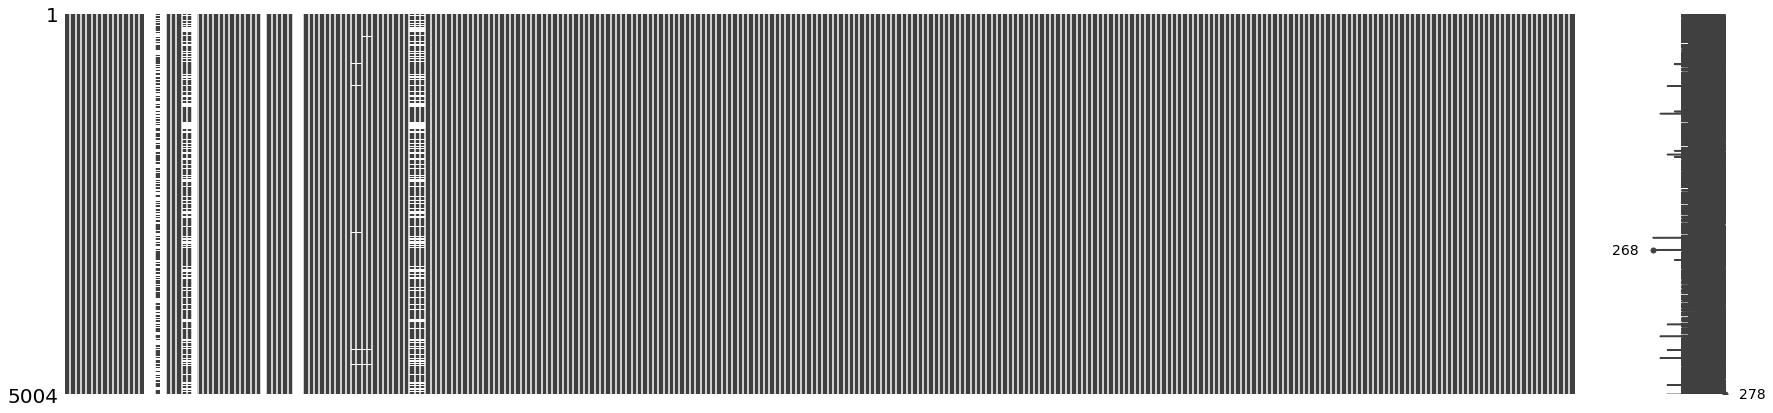

In [26]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_opta_shots_raw
msno.matrix(df_opta_shots_raw, figsize = (30, 7))

In [27]:
# Counts of missing values
null_value_stats = df_opta_shots_raw.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

endX                     5004
endY                     5004
blockedX                 2276
blockedY                 5004
relatedEventId           1292
relatedPlayerId          1292
cardType                 5004
weatherCode              5004
etScore                  5004
pkScore                  5004
homeFormationId            36
homeFormationName          36
awayFormationId            27
awayFormationName          27
relatedPlayerName        1292
relatedPlayerNumber      1292
relatedPlayerPosition    1292
dtype: int64

The visualisation shows us very quickly that there are missing values in several of the columns including `endX`, `endY`. For the purposes of an Expected Goals model, the dataset has values for all the attributes of interest and there is therefore no attributes of concern.

This concludes the data handling section, the next thing to do is engineer the raw dataset to be ready for modeling.

---

<a id='section4'></a>

## <a id='#section4'>4. Data Engineering</a>
Before any Feature Engineering or Data Visualisation, we first need to clean and wrangle the datasets to a form that meet our needs.

<a id='section4.1'></a>

### <a id='#section4.1'>4.1. Assign Raw DataFrame to Engineered DataFrame
From this point, all changes made to the dataset applied to the new engineered DataFrame, `df_opta_shots`.

In [50]:
# Assign Raw DataFrame to Engineered DataFrame
df_opta_shots = df_opta_shots_raw.copy()

# Display DataFrame
df_opta_shots.head() 

,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,relatedEventId,relatedPlayerId,cardType,isGoal,periodId,typeId,outcomeTypeId,periodName,typeName,outcomeTypeName,matchId,timeStamp,attendance,venueName,refereeName,weatherCode,startTime,matchDate,finalScore,htScore,ftScore,etScore,pkScore,homeGoals,awayGoals,statusCode,periodCode,homeTeamId,homeTeamName,awayTeamId,awayTeamName,fullFixture,homeFormationId,homeFormationName,awayFormationId,awayFormationName,name,number,position,isStarter,isManOfTheMatch,finalPlayerRating,finalTeamRating,relatedPlayerName,relatedPlayerNumber,relatedPlayerPosition,isPass,isOffsidePass,isTakeOn,isFoul,isOut,isCorner,isTackle,isInterception,isTurnover,isSave,isClaim,isClearance,isMissedShots,isShotOnPost,isSavedShot,isCard,isSubsitutionOff,isSubstitutionOn,isPlayerRetured,isPlayerReturns,isPlayerBecomesGoalkeeper,isGoalkeeperBecomesPlayer,isConditionChange,isOfficialChange,isStartDelay,isEndDelay,isEnd,isStart,isFormationSet,isPlayerChangedPosition,isPlayerChangedJerseyNumber,isCollectionEndEvent,isTempAttempt,isFormationChange,isPunch,isGoodSkill,isDeletedEvent,isAerial,isChallenge,isRescindedCard,isBallRecovery,isDispossessed,isError,isKeeperPickup,isCrossNotClaimed,isSmother,isOffsideProvoke,isShieldBallOpp,isFoulThrowIn,isPenaltyFaced,isKeeperSweeper,isChanceMissed,isBallTouch,isTempSave,isResume,isContentiousRefereeDecision,isPossessionData,is5050,isRefereeDropBall,isFailedToBlock,isInjuryTimeAnnouncement,isCoachSetup,isCaughtOffside,isOtherBallContact,isBlockedPass,isLongball,isCross,isHeadPass,isThroughBall,isFreeKickTaken,isCornerTaken,isPlayerCaughtOffside,isGoalDisallowed,isPenalty,isHandball,is6SecondsBiolation,isDangerousPlay,isLastLine,isHead,isSmallBoxCentre,isBoxCentre,isOutOfBoxCentre,35+,isRightFooted,isOtherBodyPart,isRegularPlay,isFastBreak,isSetPiece,isFromCorner,isFreeKick,isOwnGoal,isAssisted,isInvolved,isYellow,isSecondYellow,isRed,isRefereeAbuse,isArgument,isFight,isTimeWasting,isExcessiveCelebration,isCrowdInteraction,isOtherReason,isInjury,isTactical,isPlayerPosition,iaTemperature,isConditions,isFieldPitch,isLightings,isAttendanceFigure,isOfficialPosition,isOfficialId,isInjuredPlayerId,isEndCause,isRelatedEventId,isZoneQualifier,isEndType,isJerseyNumber,isSmallBoxRightQualifier,isLeftFooted,isBlocked,isDefBlock,isThrowIn,isKeeperThrow,isGoalKick,isDive,isOverrun,isSubOn,isSubOff,isSOG,isSOTInBox,isSOTOBox,isBlkdInBox,isBlkdOutBox,isOff,isOffTgtOBox,isOffTgtInBox,isPenTaken,isPenGoal,isShotDirFK,isGoalDirFK,isGoalInBx,isGoalOBx,isGoalOP,isGoalHead,isOffTgtHead,isSOTHead,isGoalLF,isGoalRF,isShotLF,isShotRF,isPsAtt,isPsScs,isAst,isBgChnc,is1v1,is1v1InBox,isScs1v1InBox,isSucflDuels,isSuccess1v1,isThrghBalls,isThrghBlCmp,isTouches,isDuelLs,isFailTackle,isSucflTkls,isInt,isClrnce,isHeadClear,isRecovery,isOffsides,isCrossPunch,isErrShot,isErrGoal,isKeeperCtch,isPensWon,isSaves,isSvCght,isSvClct,isSvDive,isSvFeet,isSvFTip,isSvHands,isSvInBox,isSvOutBox,isSvPrdDng,isSvPrdSaf,isSvReach,isSvStand,isSvStoop,is2ndYellow,isDisposs,isTchsA3,isTchsD3,isTchsM3,isPsFwd,isPsCmpA3,isPsCmpM3,isPsCmpD3,isPsAttA3,isPsAttM3,isPsAttD3,isAerialTotal,isAerialScs,isAerialFl,isAerials,isBgChncGoal,isCrosses,isCrossScs,isCrossFl,isCrossOpnPl,isCrossScsOpnPl,isCrossFlOpnPl,isKeyPasses,isDefBlocks,isShotsTotal
0,2.325163e+09,60.0,3.0,37.0,2889.0,74.0,46.0,3.0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 15, 'displayName': 'SavedShot'}","{'value': 1, 'displayName': 'Successful'}","{'type': {'value': 233, 'displayName': 'Opposi...","91, 9, 10, 2, 4, 12",True,80443.0,NaN,NaN,96.5,NaN,22.2,47.5,True,NaN,NaN,NaN,True,1.0,15.0,1.0,FirstHalf,SavedShot,Successful,1575799,2021-08-30 08:58:41,3309,MAPEI Stadium - Città del Tricolore,Juan Luca Sacchi,NaN,2021-08-29T17:30:00,2021-08-29,0 : 0,0 : 0,0 : 0,NaN,NaN,0,0,6,7,2889,Sassuolo,271,Sampdoria,2021-08-29: Sassuolo (0) vs. Samp

<a id='section4.2'></a>

### <a id='#section4.2'>4.2. Select Columns of Interest
The current dataset includes features for all possible Event Types and Qualifiers, as well as further derived features for commonly analysed matrics such as `isGoalInBox`, `isBlkdInBox`, `isSOTHead`, amongst others.
    
This Expected Goals model is a simple model at this stage, so will only use the minimum metrics required. The metrics that are of interest include:
*    Pitch X (`x`) and Y (`y`) coordinates
*    Goal Mouth Y (`goalMouthY`) and Z (`goalMouthZ`) coordinates
*    Body Part - foot (`isLeftFooted`, `isRightFooted`) / head (`isHead`) / other (`isOtherBodyPart`)
*    Goal (`isGoal` - the ML model target
    
Other metrics available in the data that
*    Play type - `isRegularPlay`, `isSetPiece`, `isFromCorner`, `isFreeKick`, `isPenalty`
*    Blocked (`isBlocked`)
*    Fast Break (`isFastBreak`)
*    Through Ball (`isThroughBall`)
*    Last Line (`isLastLine`)
*    Big Chance (`isBgChnc`)
*    Own Goal (`isOwnGoal`)
*    Goalkeeper Error (`isErrGoal`)

In [51]:
# Select Features of interest
feature_cols = ['x', 
                'y',
                'goalMouthY',
                'goalMouthZ',
                'isLeftFooted',
                'isRightFooted',
                'isHead',
                'isOtherBodyPart',
                'isRegularPlay',
                'isSetPiece',
                'isFromCorner',
                'isFreeKick',
                'isPenalty',
                'isBlocked',
                'isFastBreak',
                'isThroughBall',
                'isLastLine',
                'isBgChnc',
                'isOwnGoal',
                'isErrGoal'
               ]

# Define Target
target_col = ['isGoal']

# Select only Features and Target
df_opta_shots = df_opta_shots[feature_cols + target_col]

In [34]:
# Description of the DataFrame, df_opta_shots, showing some summary statistics for each numberical column in the DataFrame
df_opta_shots.describe()

,x,y,goalMouthY,goalMouthZ,isLeftFooted,isRightFooted,isHead,isOtherBodyPart,isRegularPlay,isSetPiece,isFromCorner,isFreeKick,isPenalty,isBlocked,isFastBreak,isThroughBall,isLastLine,isBgChnc,isOwnGoal,isErrGoal
count,5004.000000,5004.000000,5004.000000,5004.000000,5004.0,5004.0,5004.000000,5004.0,5004.000000,5004.000000,5004.0,5004.0,5004.0,5004.000000,5004.0,5004.0,5004.0,5004.0,5004.000000,5004.0
mean,84.396882,50.153677,50.273281,24.627658,0.0,0.0,0.174860,0.0,0.696443,0.058953,0.0,0.0,0.0,0.271982,0.0,0.0,0.0,0.0,0.005196,0.0
std,9.436383,12.401382,8.853467,23.630358,0.0,0.0,0.379885,0.0,0.459840,0.235560,0.0,0.0,0.0,0.445025,0.0,0.0,0.0,0.0,0.071902,0.0
min,0.000000,12.000000,0.300000,0.600000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
25%,79.000000,42.000000,47.200000,8.300000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
50%,86.000000,50.000000,50.100000,19.000000,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
75%,91.000000,59.000000,53.000000,25.900000,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0
max,99.000000,99.000000,100.000000,100.000000,0.0,0.0,1.000000,0.0,1.000000,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,1.000000,0.0


<a id='section4.3'></a>

### <a id='#section4.3'>4.3. Explore Data
This following section visualises all the shots on a football pitch using the `draw_pitch_mpl()` function, using code from [Peter McKeever](https://twitter.com/petermckeever)'s [How to Draw a Football Pitch](http://petermckeever.com/2020/10/how-to-draw-a-football-pitch/) blog post.

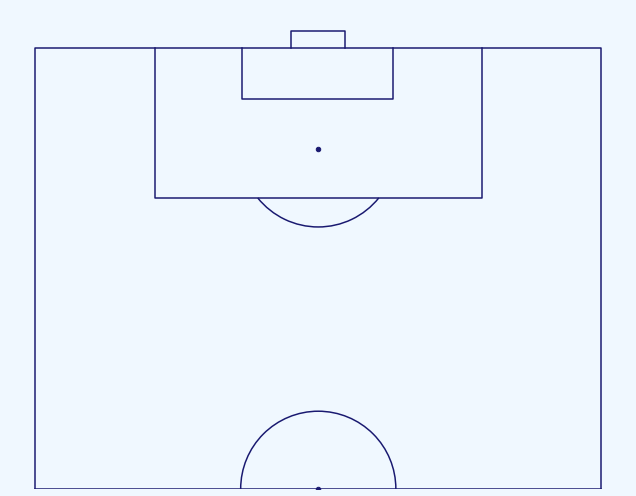

In [35]:
# Plotting Pitch

## Set background colour
background = 'aliceblue'

## Create figure 
fig, ax = plt.subplots(figsize=(11, 7))
fig.set_facecolor(background)

## Draw the pitch
draw_pitch_mpl(orientation='vertical',    # 'horizontal'
               aspect='half',             # 'fll'
               pitch_color=background,
               line_color='midnightblue',
               ax=ax
              )

## Show figure
plt.tight_layout()
plt.show()

The shots plotted on a pitch using the `draw_pitch_mpl()` function will look like the following:

In [37]:
pitch_length_x = 100
pitch_length_y = 100

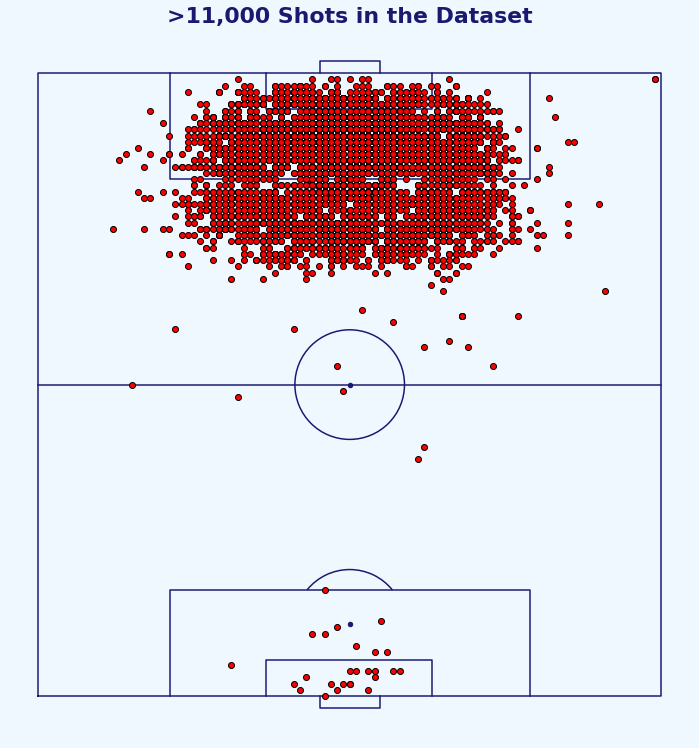

In [40]:
# Plotting Shots

## Define fonts
#title_font = 'Alegreya Sans'
#main_font = 'Open Sans'

## Set background colour
background = 'aliceblue'

## Create figure 
fig, ax = plt.subplots(figsize=(16.5, 10.5))
fig.set_facecolor(background)
#ax.patch.set_facecolor('w')

"""
## Set title
ax.set_title('Title',
             loc='left',
             fontweight='bold',
             fontsize=18,
             #fontfamily='title_font'
            )
"""

## Set Gridlines 
#ax.grid(lw=0.25, color='k', zorder=1)

## Draw the pitch
draw_pitch_mpl(x_min=0,
               x_max=pitch_length_x,
               y_min=0,
               y_max=pitch_length_y,
               orientation='vertical',
               aspect='fll', # 'half'
               pitch_color=background,
               line_color='midnightblue',
               ax=ax
              )

## Define X and Y values
y = df_opta_shots['x'].tolist()
x = df_opta_shots['y'].tolist()

zo = 12

## Create scatter plot
plt.scatter(x,
            y,
            marker='o',
            color='red',
            edgecolors='black',
           #linewidths=0.5,
           #s=400,
            zorder=zo
           )

"""
# Add point label
ax.text(x[19], y[19]+0.025,
        'Point label',
        ha='center',
        color='k',
        fontsize=14,
        fontweight='medium',
        zorder=3,
       #fontfamily=main_font
       )
"""

"""
## Set X and Y Limits
ax.set_ylim(0,1)
ax.set_xlim(0,1)
"""

## Set title
ax.set_title('>11,000 Shots in the Dataset',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )


## Save figure
if not os.path.exists(fig_dir_opta + '/opta_shots_v_full_pitch_std.png'):
    plt.savefig(fig_dir_opta + '/opta_shots_v_full_pitch_std.png', bbox_inches='tight', dpi=300)
else:
    pass

## Show figure
plt.tight_layout()
plt.show()

We can also visualise these shots interactively in the notebook using the `draw_pitch_plotly()` function, using code from [Kraus Clemens'](https://twitter.com/clekraus) [soccer_analytics](https://github.com/CleKraus/soccer_analytics) GitHub repo (see the Plotly code [[link](https://github.com/CleKraus/soccer_analytics/blob/master/helper/plotly.py)]).

##### Shots by `outcome`

In [42]:
# Create separate DataFrames for shots that resulted in goals and no goals
df_goals = df_opta_shots[(df_opta_shots['isGoal']==True)]
df_no_goals = df_opta_shots[(df_opta_shots['isGoal']==False)]

In [45]:
# Visualise shots

## Define fonts
title_font='Arial'
main_font='Arial'

## Set background colour
background = 'city-blue'    # aliceblue

## Define hover data

### 
#_ng_distance_to_centerM = df_no_goals['distance_to_centerM']
#_ng_angle = df_no_goals['angle']

### 
#np.random.seed(0)
#customdata = np.dstack((_ng_distance_to_centerM , _ng_angle))


## Draw the pitch
fig = draw_pitch_plotly(colour=background, size=1, len_field=100, wid_field=90)


## Add scatter plot points to existing figure

### No Goal
fig.add_trace(go.Scatter(x=df_no_goals['x'],
                         y=df_no_goals['y'],
                         mode='markers',
                         name='No Goal',
                        #customdata=np.dstack((_ng_distance_to_centerM, _ng_angle)),
                         hovertemplate=('<b>X-coordinate</b>: %{x:.2f}<br>'+\
                                        '<b>Y-coordinate</b>: %{y:.2f}<br>'
                                       #'<b>Distance to the Goal (M)</b>: %{customdata[0]:.3f}<br>'+\
                                       #'<b>Shot Angle</b>: %{customdata[1]:.3f}<br>'
                                       ),
                         marker=dict(size=4,
                                     color='red'
                                    )
                        )
             )

### Goals
fig.add_trace(go.Scatter(x=df_goals['x'],
                         y=df_goals['y'],
                         mode='markers',
                         name='Goal',
                         hovertemplate=('<b>X-coordinate</b>: %{x:.2f}<br>'+\
                                        '<b>Y-coordinate</b>: %{y:.2f}<br>'
                                       ),
                         marker=dict(size=4,
                                     color='green'
                                    )
                        )
             )


## Update figure layout
fig.update_layout(title={'text': '<11,000 Shots in the Dataset',
                         'y':0.95,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  legend_title='Outcome',
                  font_family=main_font,
                  font_color='black',
                  title_font_family=title_font,
                  title_font_color='midnightblue',
                  title_font_size=22,
                  legend_title_font_color='black',
                  legend={'traceorder':'reversed'},
                 #width=795,
                 #height=510,
                  hoverlabel=dict(bgcolor='white',
                                  font_size=13,
                                  font_family=main_font
                                )
                 )


## Save figure
if not os.path.exists(fig_dir_opta + '/opta_shots_v_full_pitch_std.png'):
    fig.savefig(fig_dir_opta + '/opta_shots_v_full_pitch_std.png', bbox_inches='tight', dpi=300)
else:
    pass


## Show figure
fig.show()

This visualisation shows that the coordinates were successfully converted and we can quickly see the goals scored and those that were not scored, including a few outliers. These are addressed later in the [Treating Outliers](#section7) section (section 7).

<a id='section4.4'></a>

### <a id='#section4.4'>4.4. Clean Attributes

In [ ]:
# PLACEHOLDER IN CASE NEED TO ADD ANYTHING

<a id='section4.5'></a>

### <a id='#section4.5'>4.5. Remove Own Goals</a>

In [47]:
len(df_opta_shots)

5004

In [52]:
# Filter out Own Goals from the dataset
df_opta_shots = df_opta_shots[df_opta_shots['isOwnGoal'] == 0]

In [53]:
len(df_opta_shots)

4978

## FROM THIS POINT, THE NOTEBOOK IS A WORK IN PROGRESS, BASED ON A NOTEBOOK FOR AN EXPECTED GOALS MODEL FOR A DIFFERENT DATASET: 
See (if you're interested): https://github.com/eddwebster/football_analytics/blob/master/notebooks/5_data_analysis_and_projects/xg_modeling/shots_dataset/chance_quality_modelling/1)%20Logistic%20Regression%20Expected%20Goals%20Model.ipynb

<a id='section4.6'></a>

### <a id='#section4.6'>4.6. Create Open Play (OP) Shots DataFrame</a>

First look at some overall statistics of the shots in the dataset.

In [63]:
df_opta_shots

,x,y,goalMouthY,goalMouthZ,isLeftFooted,isRightFooted,isHead,isOtherBodyPart,isRegularPlay,isSetPiece,isFromCorner,isFreeKick,isPenalty,isBlocked,isFastBreak,isThroughBall,isLastLine,isBgChnc,isOwnGoal,isErrGoal,isGoal
0,74.0,46.0,47.5,22.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
1,90.0,46.0,48.4,21.5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,True
2,86.0,57.0,50.3,8.9,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,True
3,78.0,33.0,66.4,9.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
4,76.0,62.0,40.8,41.7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999,87.0,65.0,48.4,55.6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,True
5000,87.0,47.0,63.0,22.2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,True
5001,90.0,41.0,53.1,19.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,True
5002,76.0,44.0,48.5,19.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,True


In [64]:
df_opta_shots['isPenalty'].unique() 

array([0])

In [61]:
### Count number of shots and goals in the dataset

## Assign variables
count_all_shots = len(df_opta_shots_raw)
count_nog_shots = len(df_opta_shots)
count_np_shots = len(df_opta_shots[(df_opta_shots[df_opta_shots['isPenalty'] == 0])])

ValueError: Boolean array expected for the condition, not float64

In [ ]:
count_np_shots = len(df_opta_shots[(df_opta_shots[df_opta_shots['isPenalty'] == 0])])
count_op_shots = len(df_opta_shots[(df_opta_shots[df_opta_shots['isRegularPlay'] == 1])])
count_all_goals = len(df_opta_shots_raw[(df_opta_shots_raw[df_opta_shots_raw['isGoal'] == True])])
count_nog_goals = len(df_opta_shots[(df_opta_shots[df_opta_shots['isGoal'] == True]) & df_opta_shots[df_opta_shots['isOwnGoal'] == 0]])
count_np_goals = len(df_opta_shots[(df_opta_shots['play_type'] != 'Penalty') & ((df_opta_shots['outcome'] == 'Goal') | (df_opta_shots['outcome'] == 'owngoal'))])
count_op_goals = len(df_opta_shots[(df_opta_shots['play_type'] == 'Open Play') & ((df_opta_shots['outcome'] == 'Goal') | (df_opta_shots['outcome'] == 'owngoal'))])

## Print statements
print(f'• The initial shots DataFrame, before any Data Engineering and filtering, contains {count_all_shots:,} shots and {count_all_goals:,} goals ({round(100*count_all_goals/count_shots,1)}%).')
print(f'• The shots DataFrame contains {count_np_shots:,} non-penalty shots and {count_np_goals:,} non-penalty goals ({round(100*count_np_goals/count_np_shots,1)}%).')
print(f'• The shots DataFrame contains {count_op_shots:,} Open Play shots and {count_op_goals:,} Open Play goals ({round(100*count_op_goals/count_op_shots,1)}%).')
print(f'• The Expected Goal when shooting is {round(100*count_goals/count_shots,1)}%.')
print(f'• A total of {count_op_shots-count_all_shots} shots abs(({round(100*(count_op_shots-count_all_shots)/count_all_shots,1)}%)) and {count_op_goals-count_all_goals} goals ({round(100*(count_op_goals-count_all_goals)/count_all_goals,1)}%) have been removed from the dataset.')

Next, we need to filter the DataFrame for Open Play shots.

This is because dead ball situations, most notably penalty shots, are in a state with completely different characterics to Open Play shots. For example, just over 70% of penalities result in a goal - quote from The Numbers Game.

In [ ]:
# Shot play types and their frequency
df_opta_shots.groupby(['play_type']).play_type.count()

We can see that 148 goals were scored from penalties, 503 from direct freekicks, 5 from direct corners, and then 10,226 from Open Play.

For the purpose of this model, we will isolate only Open Play shots.

In [ ]:
# Subset DataFrame for non-penalty shots
df_op_shots = df_opta_shots[(df_opta_shots['play_type'] == 'Open Play')].copy()

# Display DataFrame
df_op_shots.head() 

In [ ]:
# Shot play types of the Open Play DataFrame with frequency
df_op_shots.groupby(['play_type']).play_type.count()

In [ ]:
# Count number of shots and goals in the the Open Play dataset

## Assign variables
count_op_shots = len(df_op_shots)
count_op_goals = len(df_op_shots[(df_op_shots['outcome'] == 'Goal') | (df_op_shots['outcome'] == 'owngoal')])

## Print statement
print(f'The shots DataFrame contains {count_op_shots:,} shots and {count_op_goals:,} goals ({round(100*count_op_goals/count_op_shots,1)}%).')

---

<a id='section5'></a>

## <a id='#section5'>5. Model Selection</a>

The two considered models for the purpoase of creating the Expected Goals model are:
1.    Logistic Regression; and
2.    [XGBoost](https://xgboost.readthedocs.io/en/latest/) (a type of Gradient Boosted Trees algorithm).

This notebook goes into detail of training a model using **Logistic Regression**. A further model is then created using [XGBoost](https://xgboost.readthedocs.io/en/latest/) in a subsequent notebook [[link](https://github.com/eddwebster/mcfc_submission/blob/main/notebooks/chance_quality_modelling/2\)%20Gradient%20Boosted%20Chance%20Quality%20Model%20from%20Shots%20Data.ipynb)]. This notebook and model was created after the initial submission of this CFG Junior Data Scientist task.

The reasons why these two algorithms were chosen and in the order that they have been selected is explained later in this section and made evident throughout the subsequent sections of this notebook.

The future scope of this Expected Goals model could include the use of alternative Gradient Boosting algorithms includeing [lightGBM](https://lightgbm.readthedocs.io/en/latest/) and [CatBoost](https://catboost.ai/), however, on writing, only the Logistic Regression and XGBoost algorithms have been used, as achieving the absolute best performance is not the primary motvation of this exercise.

<a id='section5.1'></a>

### <a id='#section5.1'>5.1. Classification Algorithms</a>
*    Logistic regression is a type of **classification** algorithm.
*    In a classification task, the outputs of an algorithm fall into one of various pre-chosen categories. The classification model attempts to predict the output value when given several input variables, placing the example into the correct category.
*    In contrast, for a regression task, the output variable is a numerical value that exists on a continuous scale, or to put that another way the output of a regression task is an integer or a floating point value.

<a id='section5.2'></a>

### <a id='#section5.2'>5.2. Logistic Regression</a>
*    In statistics, the Logistic model (or logit model) is used to model the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick [[link](https://en.wikipedia.org/wiki/Logistic_function)].
*    Logistic regression is a statistical model that in its basic form, uses a logistic gunction to model a binrary dependent variable i.e. it is a classification algorithm, used when the value of the target variable is categorical in nature [[link](https://en.wikipedia.org/wiki/Logistic_regression)]
*    Logistic regression is most commonly used when the data in question has binary output, so when it belongs to one class or another, or is either a 0 or 1.
*    Unlike regression tasks, classification tasks have discrete categories.
*    Although the algorithm is called 'Logistic Regression', it is, in fact, a classification algorithm. This is just something to be remembered

<a id='section5.3'></a>

### <a id='#section5.3'>5.3. The Sigmoid Function</a>
*    A sigmoid function is a mathematical function having a characteristic 'S'-shaped curve or sigmoid curve when plotted on a graph [[link](https://en.wikipedia.org/wiki/Sigmoid_function)].
*    The Sigmoid function takes values between 0 and 1 and 'squishes' them towards the margins at the top and bottom, labeling them as 0 or 1.
*    The equation of the Sigmoid function is:

![title](../../../../img/sigmoid_function_equation.png)

where e is Euler's number, representing the exponential function or exponential constant, and it has a value of approximately 2.71828.

For an example dataset, the Sigmoid curve appears as the following.

![title](../../../../img/sigmoid_function_graph.png)

This gives a value y that is extremely close to 0 if xis a large negative value and close to 1 if x is a large positive value. After the input value has been squeezed towards 0 or 1, the input can be run through a typical linear function, but the inputs can now be put into distinct categories.

<a id='section5.4'></a>

### <a id='#section5.4'>5.4. Common Uses of Logistic Regression</a>
*    Logistic Regression should only be used when the target variables fall into discrete categories and that if there’s a range of continuous values the target value might be, Logistic Regression should not be used.
*    Examples of situations you might use logistic regression in include: 
     +    Predicting if an email is spam or not spam;
     +    Whether a tumor is malignant or benign;
     +    Whether a mushroom is poisonous or edible; and
     +    Predicting whether a shot results in a goal, or not.
*    Although Logistic Regression is best suited for instances of binary classification, it can be applied to multiclass classification problems, classification tasks with three or more classes. You accomplish this by applying a'one vs. all' strategy. Let’s say you have three different classes that instances in your dataset could fall into, and if you had these three classes you could treat them as three different binary classification problems. In this instance, you would train a classifier on just the examples belonging to Class A vs. all the examples belonging to all other classes. You would then do the same thing for Class B, and finally for Class C. After the classifiers have learned to distinguish their chosen class from other classes, you just run the three classifiers on the inputs and whichever classifier is most confident it has chosen the correct class for that example, that is what class you put the example in. This is not required to be covered in this notebook.

<a id='section5.5'></a>

### <a id='#section5.5'>5.5. XGBoost</a>
*    XGBoost stands for **Extreme Gradient Boosting**.
*    It is a performant machine learning library based on the paper [Greedy Function Approximation: A Gradient Boosting Machine by Friedman](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf).
*    It is an open source machine learning library providing a high-performance implementation of gradient boosted decision trees.
*    It is originally written in C++ and is comparatively faster than other ensemble classifiers.
*    It belongs to a family of boosting algorithms and uses the **gradient boosting (GBM)** framework at its core.
*    XGBoost implements a [**Gradient Boosting algorithm**](https://en.wikipedia.org/wiki/Gradient_boosting) based on decision trees.
*    The XGBoost algorithm has been very often been the algorithm of choice since its inception in 2014, often the go to algorithm in winning Kaggle competition submissions.
*    In this notebook, the full model pipeline is built using Logistic Regression. To find out more about Gradient Boosting algorithms and XGBoost, see the XGBoost notebook [[link](https://github.com/eddwebster/mcfc_submission/blob/main/notebooks/chance_quality_modelling/2\)%20Gradient%20Boosted%20Chance%20Quality%20Model%20from%20Shots%20Data.ipynb)] or the following links for more in-depth discussion on XGBoost.
     +    [XGBoost Official Documentation](https://xgboost.readthedocs.io/en/latest/)
     +    [XGBoost Wiki](https://en.wikipedia.org/wiki/XGBoost)

<a id='section5.6'></a>

### <a id='#section5.6'>5.6. Reason for Selection of Logistic Regression in Submitted (Initial) Notebook</a>
*    Due to time constraints, only one Expected Goals model was created using one algorithm;
*    Both Logistic Regression and [XGBoost](https://xgboost.readthedocs.io/en/latest/) have their pros and cons, which were used to assess the reason for selection the model submitted. These can be summarised as follows:

##### Pros of Logistic Regression
*    Very easy to implement. Easier to interpret than XGBoost - model can be interpreted to indicate feature importance;
*    Fast training speed - faster than XGBoost;
*    More stable model than XGBoost;
*    Logistic Regression is less inclined to overfit than Decision Trees and Gradient Boosting algorithms;
*    The model coefficients of Logistic Regression can be used to indicate the importance of the features; and
*    A well-tuned Logistic Regression model can perform nearly as well as a model created using Decision Trees or Gradient Boosting algorithms such as XGBoost.

##### Cons of Logistic Regression
*    Less accurate than XGBoost. Many Kaggle competitions are won using XGBoost, not Logistic Regression. However, XGBoost is not guaranteed to be better than Logistic Regression in every setting.

##### Pros of XGBoost
*    It's also easy to implement use and gets a good performance with little tuning;
*    Highly accurate: many Kaggle competitions are won using XGBoost;
*    It uses the power of parallel processing;
*    It is faster than Gradient Boosting;
*    It is highly flexible;
*    It supports regularisation;
*    It is designed to handle missing data with its in-build features (sparse-aware). In the case of this notebook, all missing values are treated and this is not an advantage that is required;
*    The user can run a cross-validation after each iteration; and
*    It works well in small to medium dataset.

##### Cons of XGBoost
*    More prone to over-fitting than Decision Trees and Gradient Boosting algorithms;
*    Less explainable than Logistic Regression; and
*    Takes some time to tune parameters.

For this task, having the best possible model performance was not the priority. The goal of this notebook is to have a functioning, interpretable model that can be applied for the two following tasks:
1.    To assess a separate dataset from game 2 of the Metrica Sports sample data; and
2.    To create a model that can be interpreted an explain to both Data Scientists and Football Practitioners – creating a model with the smallest Log Loss is not the only requirement, the results need to be explained in English to non-technical individuals.

For this reason, this notebook works with Logistic Regression, and then a further model created using [XGBoost](https://xgboost.readthedocs.io/en/latest/) is trained to both try and further improve performance and provide a comparison to the Logistic Regression model, to sense-check the work created in this notebook. This can be found at the following [[link](https://github.com/eddwebster/mcfc_submission/blob/main/notebooks/chance_quality_modelling/2\)%20Gradient%20Boosted%20Chance%20Quality%20Model%20from%20Shots%20Data.ipynb)]. 

---

<a id='section6'></a>

## <a id='#section6'>6. Initial Modeling</a>
First model created as a baseline for which interations of improvement are based.

##### Feature Selection
The initial model just uses the features first included in the dataset. Future iterations include engineered and one-hot encoded categorical features.

The two that are of most interest to start are: 

1. The position of the shot was taken on the pitch as `position_xM` and `position_yM` (converted in the Data Engineering section'; and
2. The body part the shot was taken with, i.e. left foot, right foot or head. This information is already encoded in `BodyPartCode` (converted from strings to codes in the Data Engineering section'.

In [54]:
# Features of the Open Play shots DataFrame
df_op_shots.columns

NameError: name 'df_op_shots' is not defined

In [ ]:
# Select Features of interest
feature_cols = ['position_xM', 
                'position_yM', 
                'BodyPartCode'
               ]

# Define Target
target_col = ['isGoal']

# Assign Feature and Target to separate DataFrames and Series
X = df_op_shots[feature_cols]
y = df_op_shots[target_col]

In [ ]:
# DataFrame of Features
X.head()

In [ ]:
# Series of Labels
y.head()

##### Split the dataset into a train set and a test set
Split the data into a training set which will be used to build the model, and a testing set that is not used to build the model, but which we use to evaluate the model's predictions.

The Expected Goals model is trained on 70% of the data and the remaining 30% is evaluate the model.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

##### Train Logistic Regression model

In [ ]:
reg_initial = LogisticRegression(random_state=42)
reg_initial.fit(X_train, np.array(y_train).ravel())

##### Predict on the Test set

In [ ]:
pred_probs = reg_initial.predict_proba(X_test)[:,1]
pred_vals = reg_initial.predict(X_test)

In [ ]:
# Compute Accuracy of initial model
print(f'Accuracy of initial model: {sk_metrics.accuracy_score(y_test, pred_vals)*100:.1f}%')

# Computer Log Loss of initial model
pred_probs = reg_initial.predict_proba(X_test)[:,1]
print(f'Log Loss of initial model: {sk_metrics.log_loss(y_test, pred_probs):.5f}')

# Compute the AUC of initial model
print(f'AUC of our initial model: {sk_metrics.roc_auc_score(y_test, pred_probs)*100:.2f}%')

In the [Metric definition](#section7) section (section 7), these metrics are discussed regarding those that are useful, those that are not, and how to comprehend them.

In [ ]:
# Logistic Model coefficients
for i, col in enumerate(X_train.columns):
    print(f"Coefficient of {col}: {reg_initial.coef_[0][i]:.3f}")

##### Next steps
The following section of this notebook iterate of this Logistic Regression model, to improve the model's performance. These steps are:
*    <b>Metric definition:</b> define appropriate metrics for a Logistic Regression modelto predict probabilities of goals scored and rule out inappropriate metrics ([section 7](#section7));
*    <b>Treating outliers:</b> find and treat outliers in the dataset to improve model ([section 8](#section8));
*    <b>Univariate analysis:</b> engineer the first set of features to be usable in our logistic regression approach ([section 9](#section9));
*    <b>Feature Engineering:</b> create additional features for dataset and evaluate as to whether their inclusion improves the model performance ([section 10](#section10));
*    <b>Multivariate analysis:</b> analysis the complete set of features and their correlations. ([section 11](#section11));
*    <b>Final model and evaluation:</b> productionise final model and assess for performance performance ([section 12](#section12)); and
*    <b>Feature interpretation:</b> Interpret model features ([section 13](#section13)).

---

<a id='section7'></a>

## <a id='#section7'>7. Evaluation Metric Definition</a>
This Expected Goals model is required to calculate the <b>probability</b> of a shot resulting in a goal (i.e. P[goal|shot,situation]) given a certain state e.g. position of the shot, left foot, number of defenders, etc. Therefore, the metric used needs to be appropriate for **measuring the probability of a binary classifier**.

The following sections define what a Loss Function is, the different type if classification problems, the metrics considered in the initial model, and a selection of the most suitable metrics along with the reasons as to why that is.

<a id='section7.1'></a>

### <a id='#section7.1'>7.1. What is a Loss Function?
*    The loss function tells how good your model is in predictions.
*    When training a model, to optimise the model's performance, we are looking to reduce the error between the predicted values and the actual values i.e. reducing the loss.
*    If the model predictions are closer to the actual values the loss will be the minimum and if the predictions are totally away from the original values the loss value will be the maximum.

<a id='section7.2'></a>

### <a id='#section7.2'>7.2. Evaluation Metrics for Classification
Commonly used metrics for classification avilable in the [scikit-learn](https://scikit-learn.org/stable/index.html) package can be seen in the table below. For more information on [scikit-learn](https://scikit-learn.org/stable/index.html) evaluation metrics, see the following [[link](https://scikit-learn.org/stable/modules/model_evaluation.html)]:

| Feature                    | Function                       | Comment                              |
|----------------------------|--------------------------------|--------------------------------------|
| `accuracy`                 | [`metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)     |   
| `balanced_accuracy`        | [`metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score)     |   |
| `top_k_accuracy`           | [`metrics.top_k_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.top_k_accuracy_score.html#sklearn.metrics.top_k_accuracy_score)     |     |
| `average_precision`        | [`metrics.average_precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score)     |     |
| `neg_brier_score`          | [`metrics.brier_score_loss`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html#sklearn.metrics.brier_score_loss).   |     |
| `f1`                       | [`metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)     | for binary targets     |
| `f1_micro`                 | [`metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)                      | micro-averaged     |
| `f1_macro`                 | [`metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)                      | macro-averaged     |
| `f1_weighted`              | [`metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)                      | weighted average     |
| `f1_samples`               | [`metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)                      | by multilabel sample     |
| `neg_log_loss`             | [`metrics.log_loss`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss)                      | requires `predict_proba` support     |
| `precision`                | [`metrics.precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)     | suffixes apply as with ‘f1’     |
| `recall`                   | [`metrics.recall_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)     | suffixes apply as with ‘f1’     |
| `jaccard`                  | [`metrics.jaccard_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html#sklearn.metrics.jaccard_score)     | suffixes apply as with ‘f1’     |
| `roc_auc`                  | [`metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)                      |     |
| `roc_auc_ovr`              | [`metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)                      |     |
| `roc_auc_ovo`              | [`metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)                      |     |
| `roc_auc_ovr_weighted`     | [`metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)                      |     |
| `roc_auc_ovo_weighted`     | [`metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)                      |     |

The metrics considered in this model are:
*    Accuracy;
*    Log Loss; and 
*    ROC AUC (aka AUC).

Each of these metrics is discussed in detail as to their suitability and non-suitability.

<a id='section7.3'></a>

### <a id='#section7.3'>7.3. Accuracy
Accuracy measures the share of right and wrong decisions and does not take into consideration at all the certainty of a decision, whether you are 51% sure or 99% sure. When having unbalanced data, i.e. on outcome happens way more often than the other, it is very simple to get a good accuracy. All you need to do is to just always predict the outcome that is more likely. For this reason, Accuracy is an inappropriate metric for this model.

In [ ]:
# Compute Accuracy of initial model
print(f'Accuracy of initial model: {sk_metrics.accuracy_score(y_test, pred_vals)*100:.1f}%')

In [ ]:
np.unique(pred_vals)

In [ ]:
# Shot outcomes types and their frequency
df_op_shots.groupby(['isGoal']).isGoal.count()

The current model predicts that all shots result in no goals. This results in a high accuracy, as the ratio of goals to no goals is 9,551 to 1,374 (14.39%). Despite this high accuracy, 'Accuracy' is not a good metric to evaluate model performance of a Logistic Regression model.

<a id='section7.4'></a>

### <a id='#section7.4'>7.4. Log Loss
*    Log Loss or Binary Cross Entropy is the most important classification metric based on probabilities and when predicting probabilities the metric you should always look at is the Log Loss [[link](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)].
*    The Log Loss compares each of the predicted probabilities to actual class output which can be either 0 or 1. It then calculates the score that penalises the probabilities based on the distance from the expected value. That means how close or far from the actual value. Formally defined, the Log Loss is the **negative average of the log of corrected predicted probabilities**. Mathematically, this is represented as:

![title](../../../../img/formula_negative_average.png)
    
*    The value of the negative average of corrected probabilities is the Log loss or Binary cross-entropy
*    Instead of calculating corrected probabilities, we can calculate the Log loss using the formula given below.

![title](../../../../img/formula_log_loss.png)    

where pi is the probability of class 1, and (1-pi) is the probability of class 0.
    
*    It's hard to interpret raw Log Loss values, but Log Loss is still a good metric for comparing models. For any given problem, a lower Log Loss value means better predictions.
*    Log Loss is a slight twist on something called the **Likelihood Function**. In fact, Log Loss is -1 * the log of the likelihood function.
*    The likelihood function answers the question "How likely did the model think the actually observed set of outcomes was."
*    When the observation belongs to class 1 the first part of the formula becomes active and the second part vanishes and vice versa in the case observation’s actual class are 0. This is how we calculate the Binary cross-entropy.
*    When creating predictions and multiplying each of the values together, with enough numbers, the result gets so small that computers can't keep track of it. So, as a clever computational trick is to instead keep track of the log of the Likelihood. This is in a range that's easy to keep track of. We multiply this by negative 1 to maintain a common convention that lower loss scores are better.

This model looks at the probability with which a goal is scored, or not scored and is therefore a **binary classification problem**. For this reason, Log Loss is the appropriate metric to assess this Expected Goals model and is the metric that this notebook will look to reduce when going through iterations of improvement.
    
The Log Loss for the initial model is the following:

In [ ]:
# Compute the Log Loss of initial model
pred_probs = reg_initial.predict_proba(X_test)[:,1]
print(f'Log Loss of initial model: {sk_metrics.log_loss(y_test, pred_probs):.5f}')

The model has a Log Loss of 0.33333. For comparison, let's compute a model that just always predicts 14.39%, i.e. the average expected goal over all shots taken (stated when data imported into model).

In [ ]:
print(f'Log Loss of the dummy model: {sk_metrics.log_loss(y_test, [0.143859282]*len(y_test)):.5f}')

The current Logistic Regression model is a bit better than just predicting the average with a Log Loss of 0.37125. To improve this model, we will compare use the current Log Loss of 0.33333 as a baseline for which to compare other models.

<a id='section7.5'></a>

### <a id='#section7.5'>7.5. ROC AUC
The ROC AUC of a model is the probability that the model ranks a random positive example (i.e. a successful shot) more highly than a random negative example (i.e. unsuccessful shot).

The problem with measuring the ROC AUC of a Expected Goals model is that it only looks at ranking of the positive vs. the negative examples and not about the probabilities that are assigned to the examples. We, however, are interested in knowing the probability of a shot being successful. This is not captured by the ROC AUC.

In [ ]:
# Compute the AUC of initial model
print(f'ROC AUCof our initial model: {sk_metrics.roc_auc_score(y_test, pred_probs)*100:.2f}%')

The ROC AUC of the initial model says that when randomly selecting a successful shot and an unsuccessful shot, there is a 72.3% chance that our model gives the successful shot a higher probability than the unsuccessful shot.

To prove that ROC AUC in not useful, this can be demonstrated by oversestimated the probabilities of the ball going in.

In [ ]:
print(f'Currently predicted success when shooting: {np.mean(pred_probs)*100:.2f}%')

# Overestimate the probabilities
pred_probs_over = pred_probs * 5
print(f'Overestimated predicted success when shooting: {np.mean(pred_probs_over)*100:.2f}%')

Now we predict that 62% of all shots are successful. Something that is completely ridiculous. But guess what happens when we look at the two metrics *log loss* and *AUC*

In [ ]:
print(f'Log loss w/o overestimation: {sk_metrics.log_loss(y_test, pred_probs):.3f}')
print(f'Log loss with overestimation: {sk_metrics.log_loss(y_test, pred_probs_over):.3f}')
print(f'AUC w/o overestimation: {sk_metrics.roc_auc_score(y_test, pred_probs)*100:.2f}%')
print(f'AUC with overestimation: {sk_metrics.roc_auc_score(y_test, pred_probs_over)*100:.2f}%')

We can see that the Log Loss skyrocketed as expected whilst the the AUC remained exactly the same. This is because the AUC only measures the ranking between the shots, but does not at all measure if the probabilities make any sense. AUC is therefore not a reliable metric when evaluation a Expected Goals model.

The AUC however can be useful to communicate results to non data scientists. In this analysis, we will focus oin reducing the Log Loss during model development, however, using the AUC, we can explain how good the model is with the answer "*It has a 71% chance of detecting the successful shot from the unsuccessful one*" rather than "*It has a log loss of 0.345*".

---

<a id='section8'></a>

## <a id='#section8'>8. Treating Outliers</a>

Outliers in an Expected Goals model can be described as two types of data points:
1.    Data points that are wrong, i.e. shots that never happened; and
2.    Data points that are correct, i.e. shot happened in reality, but you do not want the model to learn from.

The first point is easy to understand - a data for the shot is incorrectly collected. It therefore needs to be removed.

For the second point, an example could be the last minute of the game and the team that is currently losing has a corner. They therefore decide to take out the goalkeeper as an extra man to try and nick a goal. However, the corner isn't successful, the other team counter attacks and shoots from over 50 meters into the empty goal. This shot took place, but we do not want the model to learn that there is a chance to score from this area as our current data doesn't account for the goalkeeper being out of their goal. If tracking data was available and we knew the goal was empty, maybe yes. If we don't have this data, however, it's best to exclude it.

In [ ]:
# Xabi Alonso's 70 yard goal against Luton in the FA Cup
YouTubeVideo('4OTQwuAc4HU')

<a id='section8.1'></a>

### <a id='#section8.1'>8.1. Shot Position</a>
The the following cells, the visualisations look at the goals and shots made.

##### Create 2D Histograms for shots and goals used to generate Heat Maps

In [ ]:
# Two dimensional histogram
H_Shot = np.histogram2d(df_op_shots['x'], df_op_shots['y'], bins=50, range=[[0, pitch_length_x], [0, pitch_length_y]])
df_op_goals = df_op_shots[df_op_shots['isGoal'] == 1]
H_Goal = np.histogram2d(df_op_goals['x'], df_op_goals['y'], bins=50, range=[[0, pitch_length_x], [0, pitch_length_y]])

Create custom colour map [[link](https://kbkb-wx-python.blogspot.com/2015/12/python-transparent-colormap.html)]

In [ ]:
# Choose colormap
cmap=plt.cm.Reds

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)

##### Visualise Shots

In [ ]:
# Visualise shots

## Define fonts
title_font='Arial'
main_font='Arial'

## Set background colour
background = 'city-blue'    # aliceblue

## Define hover data

### 
#_ng_distance_to_centerM = df_no_goals['distance_to_centerM']
#_ng_angle = df_no_goals['angle']

### 
#np.random.seed(0)
#customdata = np.dstack((_ng_distance_to_centerM , _ng_angle))


## Draw the pitch
fig = draw_pitch_plotly(colour=background, size=1, len_field=106, wid_field=68)


## Add heat map histogram to existing figure
fig.add_trace(go.Histogram2d(x=df_op_shots['x'],
                             y=df_op_shots['y'],
                             colorscale='YlGnBu',
                            #zmax=100,
                             nbinsx=50,
                             nbinsy=50,
                             zauto=False
                            #mode='markers',
                            #name='No Goal',
                            #customdata=np.dstack((_ng_distance_to_centerM, _ng_angle)),
                           # hovertemplate=('<b>X-coordinate</b>: %{x:.2f}<br>'+\
                           #                 '<b>Y-coordinate</b>: %{y:.2f}<br>'
                           #                #'<b>Distance to the Goal (M)</b>: %{customdata[0]:.3f}<br>'+\
                           #                #'<b>Shot Angle</b>: %{customdata[1]:.3f}<br>'
                           #                ),
                           #  marker=dict(size=4,
                           #              color='red'
                           #             )
                            )
             )

### Goals


## Update figure layout
fig.update_layout(title={'text': 'Number of Shots',
                         'y':0.95,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  legend_title='Outcome',
                  font_family=main_font,
                  font_color='black',
                  title_font_family=title_font,
                  title_font_color='midnightblue',
                  title_font_size=22,
                  legend_title_font_color='black',
                  legend={'traceorder':'reversed'},
                 #width=795,
                 #height=510,
                  hoverlabel=dict(bgcolor='white',
                                  font_size=13,
                                  font_family=main_font
                                )
                 )


## Save figure
if not os.path.exists(fig_dir_opta + '/op_shots_v_full_shots.png'):
    fig.savefig(fig_dir_opta + '/op_shots_v_full_shots.png', bbox_inches='tight', dpi=300)
else:
    pass


## Show figure
fig.show()

In [ ]:
import matplotlib.patheffects as path_effects
import themepy
from PIL import Image
import requests

In [ ]:
# Visualise Shots

## Set background colour
background = 'aliceblue' #"white"

## Create figure 
fig, ax = plt.subplots(figsize=(16.5, 10.5))
fig.set_facecolor(background)

## Draw the pitch
draw_pitch_mpl(x_min=0,
              x_max=pitch_length_x,
              y_min=0,
              y_max=pitch_length_y,
              orientation='vertical', # "horizontal"
              aspect="fll",
              pitch_color=background,
              line_color="midnightblue",
              ax=ax
             )

## Heat map
pos=ax.imshow(H_Shot[0],
              extent=[-1, pitch_length_y, pitch_length_x, -1],
              aspect='auto',
              cmap=my_cmap
             )

## Colour bar
fig.colorbar(pos, ax=ax)

## Set title
ax.set_title('Number of Shots',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )

## Save figure
if not os.path.exists(fig_dir_opta + '/op_shots_v_full_shots.png'):
    plt.savefig(fig_dir_opta + '/op_shots_v_full_shots.png', bbox_inches='tight', dpi=300)
else:
    pass

## Show figure
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

The visualisation looks as expected. Most of the shots where taken either inside or slightly outside the box. Within the box, there appears to be a slight bias to the goalkeeper's left, but it is generally even.

Next we'll visualise where the goals were scored from.

##### Visualise Goals

In [ ]:
# Visualise Goals

## Set background colour
background = 'aliceblue' #"white"

## Create figure 
fig, ax = plt.subplots(figsize=(16.5, 10.5))
fig.set_facecolor(background)

## Draw the pitch
draw_pitch_mpl(x_min=0,
              x_max=pitch_length_x,
              y_min=0,
              y_max=pitch_length_y,
              orientation="vertical", # "horizontal"
              aspect="fll",
              pitch_color=background,
              line_color="midnightblue",
              ax=ax
             )

## Heat map
pos=ax.imshow(H_Goal[0],
              extent=[-1, pitch_length_y, pitch_length_x, -1],
              aspect='auto',
              cmap=my_cmap
             )

## Colour bar
fig.colorbar(pos, ax=ax)

## Set title
ax.set_title('Number of Goals',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )

## Save figure
if not os.path.exists(fig_dir_opta + '/op_shots_v_full_goals.png'):
    plt.savefig(fig_dir_opta + '/op_shots_v_full_goals.png', bbox_inches='tight', dpi=300)
else:
    pass

## Show figure
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Again, the visualisation looks as expected. Most of the goals scored were within the 6 or 18-yard box. Again, there appears to be a slight bias to the goalkeeper's left, but it is generally even.

Next we'll investigate the probability from scoring per zone i.e. the number of goals divided by the number of shots.

##### Frequency of Scoring
Dividing the number of goals by the number of shots.

In [ ]:
# Visualise the probability of scoring from different points

## Set background colour
background = 'aliceblue' #"white"

## Create figure 
fig, ax = plt.subplots(figsize=(16.5, 10.5))
fig.set_facecolor(background)

## Draw the pitch
draw_pitch_mpl(x_min=0,
              x_max=pitch_length_x,
              y_min=0,
              y_max=pitch_length_y,
              orientation="vertical", # "horizontal"
              aspect="fll",
              pitch_color=background,
              line_color="midnightblue",
              ax=ax
             )

## Heat map
pos=ax.imshow(H_Goal[0]/H_Shot[0],
              extent=[-1, pitch_length_y, pitch_length_x, -1],
              aspect='auto',
              cmap=my_cmap,
             #vmin=0,
             #vmax=0.5
             )

## Colour bar
fig.colorbar(pos, ax=ax)

## Set title
ax.set_title('Proportion of Shots Resulting in a\nGoal Before Outlier Removal',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=16,
            )


## Save figure
if not os.path.exists(fig_dir_opta + '/op_shots_v_full_proportion_goals_from_shots_before_outlier_removal.png'):
    plt.savefig(fig_dir_opta + '/op_shots_v_full_proportion_goals_from_shots_before_outlier_removal.png', bbox_inches='tight', dpi=300)
else:
    pass

## Show figure
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

There are data points far away from the goal that almost certainly wrong, the other might indeed have happened in a match and are therefore right, just like the Xabi Alonso goal against Luton where the goalkeeper was out of position, causing Xabi to shoot from a position that he otherwise would not shoot from. For example, it appears that a goal was scored from the edge of the of the attacking team's box. There is also a goal from the halfway line.

Reasons for this could be:
*    The data in correctly entered,
*    Coordinate system flipped for the particular shot (unlikely).

The data is required to be smooth so that the model doesn't think there's a 100% chance of scoring when shooting from the edge of the goalkeepers box.

There are three options to deal with these outliers:
1.    Delete the outliers;
2.    Use our experience and tell the model that the probability to score from this position is realistically 0. This means we change the target but leave the features as is; and
3.    Assume that the shot happened closer to the goal, but we still assume that it went in. This means that we change the features but leave the target.

In our situation, the second strategy would make the most sense.

There are sophisticated ways to filter out these shots when a full set of Event data is available. For example, with full event data, we could determine the percentage likelihood of shooting from a position by looking at all actions on a pitch, and seeing how many times a player shoots relative to other actions. If the player 99 times out of 100 passes the ball instead of shooting for said position, we can set the chance that the player scorores to zero. With this logic, we can assume that all shots happening in any of the cells with < 1% shooting probability did not result in a goal.

The following code creates three, important features that are crucial to the Logistic Regression modeling and we will use to filter out imporbable shots. These include:
*    The distance of the shot from the goal (x-axis);
*    The distance of the shot from the center of the pitch (y-axis); and 
*    The angle of the shot to the goal.

These can all be determined using Pythagoras' theorem and basic trigonometry. For more information, David Sumpter's lecture [How to Build An Expected Goals Model 1: Data and Model](https://www.youtube.com/watch?v=bpjLyFyLlXs) for Friends of Tracking @ the 17 minute mark.

In [ ]:
# Create new features - distance_to_goalM, 'distance_to_centerM', and 'angle'
df_op_shots['distance_to_goalM'] = np.sqrt((((pitch_length_x/2) - df_op_shots['position_xM'])**2) + ((df_op_shots['position_yM'])**2))
df_op_shots['distance_to_centerM'] = np.abs(df_op_shots['position_yM'])
df_op_shots['angle'] = np.absolute(np.degrees(np.arctan((df_op_shots['position_yM']) / ((pitch_length_x/2) - df_op_shots['position_xM']))))

In [ ]:
df_op_shots[(df_op_shots['isGoal'] == 1) & (df_op_shots['distance_to_goalM'] > 18) & (df_op_shots['angle'] > 45)].sort_values(by='position_yM', ascending=False).head(50)

In [ ]:
df_op_shots[(df_op_shots['isGoal'] == 1) & (df_op_shots['distance_to_goalM'] > 18)].sort_values(by='distance_to_goalM', ascending=False).head(50)

In [ ]:
# Shots_before_outlier_treatment = len(df_op_shots)
goals_before_outlier_treatment = np.sum(df_op_shots['isGoal'] == 1)

In [ ]:
df_op_shots['isGoal'] = np.where(df_op_shots['distance_to_goalM'] > 35, 0, df_op_shots['isGoal'])
df_op_shots['isGoal'] = np.where(((df_op_shots['distance_to_goalM'] > 20) & (df_op_shots['angle'] > 35)), 0, df_op_shots['isGoal'])

In [ ]:
#shots_after_outlier_treatment = len(df_op_shots)
goals_after_outlier_treatment = np.sum(df_op_shots['isGoal'] == 1)

In [ ]:
#print(f'Shots before outlier treatment: {shots_before_outlier_treatment:,}')
#print(f'Shots after outlier treatment: {shots_after_outlier_treatment:,} ({(1-(shots_after_outlier_treatment/opta_shots_before_outlier_treatment))*100:.3f}% shots removed)')
print(f'Goals before outlier treatment: {goals_before_outlier_treatment:,}')
print(f'Goals after outlier treatment: {goals_after_outlier_treatment:,} ({(1-(goals_after_outlier_treatment/goals_before_outlier_treatment))*100:.3f}% goals changed).')

By replacing the value of whether a goals was scored or not to no goal for all shots taken from greater than 35m (38.27 yards) or from 20m (21.87 yards) where the angle to the goal is also greater than 35 degrees, 33 shots are replaced in the Open Play dataset (2.71% of all goals).

Let now replot the proportion of shots resulting in a goal, with these outliers removed.

In [ ]:
# Visualise the probability of scoring from different points after outlier removal

## Two dimensional histogram
H_Shot = np.histogram2d(df_op_shots['x'], df_op_shots['y'], bins=50, range=[[0, pitch_length_x], [0, pitch_length_y]])
df_op_goals = df_op_shots[df_op_shots['isGoal'] == 1]
H_Goal = np.histogram2d(df_op_goals['x'], df_op_goals['y'], bins=50, range=[[0, pitch_length_x], [0, pitch_length_y]])

## Set background colour
background = 'aliceblue' #"white"

## Create figure 
fig, ax = plt.subplots(figsize=(16.5, 10.5))
fig.set_facecolor(background)

## Draw the pitch
draw_pitch_mpl(x_min=0,
              x_max=pitch_length_x,
              y_min=0,
              y_max=pitch_length_y,
              orientation="vertical", # "horizontal"
              aspect="fll",
              pitch_color=background,
              line_color="midnightblue",
              ax=ax
             )

## Heat map
pos=ax.imshow(H_Goal[0]/H_Shot[0],
              extent=[-1, pitch_length_y, pitch_length_x, -1],
              aspect='auto',
              cmap=my_cmap,
             #vmin=0,
             #vmax=0.5
             )

## Colour bar
fig.colorbar(pos, ax=ax)

## Set title
ax.set_title('Proportion of Shots Resulting in a\nGoal After Outlier Removal',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=16,
            )

## Save figure
if not os.path.exists(fig_dir_opta + '/op_shots_v_full_proportion_goals_from_shots_after_outlier_removal.png'):
    plt.savefig(fig_dir_opta + '/op_shots_v_full_proportion_goals_from_shots_after_outlier_removal.png', bbox_inches='tight', dpi=300)
else:
    pass

## Show figure
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
# Visualise the probability of scoring from different points after outlier removal

## Two dimensional histogram
H_Shot = np.histogram2d(df_op_shots['x'], df_op_shots['y'], bins=50, range=[[0, pitch_length_x], [0, pitch_length_y]])
df_op_goals = df_op_shots[df_op_shots['isGoal'] == 1]
H_Goal = np.histogram2d(df_op_goals['x'], df_op_goals['y'], bins=50, range=[[0, pitch_length_x], [0, pitch_length_y]])

## Set background colour
background = 'aliceblue' #"white"

## Create figure 
fig, ax = plt.subplots(figsize=(16.5, 10.5))
fig.set_facecolor(background)

## Draw the pitch
draw_pitch_mpl(x_min=0,
              x_max=pitch_length_x,
              y_min=0,
              y_max=pitch_length_y,
              orientation="vertical", # "horizontal"
              aspect="half",
              pitch_color=background,
              line_color="midnightblue",
              ax=ax
             )

## Heat map
pos=ax.imshow(H_Goal[0]/H_Shot[0],
              extent=[-1, pitch_length_y, pitch_length_x, -1],
              aspect='auto',
              cmap=my_cmap,
             #vmin=0,
             #vmax=0.5
             )

## Colour bar
fig.colorbar(pos, ax=ax)

## Set title
ax.set_title('Proportion of Shots Resulting in a Goal',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )

## Save figure
if not os.path.exists(fig_dir_opta + '/op_shots_v_half_proportion_goals_from_shots_after_outlier_removal.png'):
    plt.savefig(fig_dir_opta + '/op_shots_v_half_proportion_goals_from_shots_after_outlier_removal.png', bbox_inches='tight', dpi=300)
else:
    pass

## Show figure
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

The data now looks better. The goals from inside the attacking team's area and some acute goals scored outside the box at tight angles have been removed. Even though this was quite an arbitrary method of removing outliers, as this is not a complete dataset and a well known problem, I believe this is an adequate method in this circumstance.

The output now looks a lot like the general Expected Goals diagram that features in [David Sumpter's](https://twitter.com/Soccermatics?) (@Soccermatics) book Soccermatics, in which goals in the circle around the 6-yard box have roughly a 30% of scoring, 15% in the circle outside between the 6 and 12-yard box, and 7% towards the edge and just outside the box. This diagram also shows that the angle the shot has is important, which shots closer to the goal but from an acute angle having less chance of scoring than shots in with high visibility of the goal from the edge of the box.

![title](../../../../img/expected_goals_diagram.png)

For more information, see David Sumpter's talk: 'Expected Goals to a football player' below:

In [ ]:
# How to explain Expected Goals to a football player by David Sumpter (@Soccermatics)
YouTubeVideo('Xc6IG9-Dt18')

<a id='section8.2'></a>

### <a id='#section8.2'>8.2. Body Part</a>

In [ ]:
# Print statements about the dataset

## Assign variables
number_of_shots_all = len(df_op_shots)

## Print statement
print(f'All shots: {number_of_shots_all:,}.')

## Body Part types and their frequency
df_op_shots.groupby(['BodyPart']).BodyPart.count()

70 goals are scored with an 'Other' body part. As this body part cannot be identified, this will affect how this model works with the Metrica Sports data, where the body part is either 'foot' or 'head'. For this reason, these 70 shots will be removed from the dataset, but this will take place after the univariate analysis in the next section, where this is touched upon again.

<a id='section8.3'></a>

### <a id='#section8.3'>8.3. Number of Intervening Opponents</a>

In [ ]:
# Print statements about the dataset

## Assign variables
number_of_shots_all = len(df_op_shots)

## Print statement
print(f'All shots: {number_of_shots_all:,}.')

## Body Part types and their frequency
df_op_shots.groupby(['Number_Intervening_Opponents']).Number_Intervening_Opponents.count()

The values look correct, there are between 0 to 11 intervening opponents, which makes logic sense. No further action required.

<a id='section8.4'></a>

### <a id='#section8.4'>8.4. Impact on Log Loss</a>
Before we start with the next section, let's quickly check what impact the outlier treatment had on our log loss. As we only changed 0.06% of the data points, we would only expect a very little impact. Nevertheless, we should recompute it to have a good baseline for our actual model development.

First, we need to recalculate our training and test set (by the way, if you don't know why we split into test and train, you should definitely look it up - this is one of the key concepts of machine learning and there is tons of material on this online). Notice, that in contrast to the shitty example above, we do not only keep the feature columns and target column separately, but we store everything (including non-feature information) in a new data frame. We will see below why in my opinion this makes a lot of sense...

In [ ]:
df_train, df_test, _, _ = train_test_split(df_op_shots, df_op_shots['isGoal'], test_size=0.30, random_state=42)
df_train.head()

Let's save the raw training and test data sets so that we can use them later on

In [ ]:
df_train_raw = df_train.copy()
df_test_raw = df_test.copy()

We re-train the logistic regression and check the log loss on the test set

In [ ]:
features = ['position_xM', 
            'position_yM', 
            'BodyPartCode'
           ]

# training of the logistic regression on the train set
reg_outlier = LogisticRegression(random_state=42)
reg_outlier.fit(df_train[features], np.array(df_train['isGoal']).ravel())

# prediction on the test set
pred_probs = reg_outlier.predict_proba(df_test[features])[:,1]
print(f"Log loss after outlier removal: {sk_metrics.log_loss(df_test['isGoal'], pred_probs):.5f}")
print(f"AUC after outlier removal: {sk_metrics.roc_auc_score(df_test['isGoal'], pred_probs)*100:.2f}%")

Good, the log loss indeed only changed very slightly from 0.33182 to 0.32910, i.e. it was reduced by 0.8%). Given that only 0.27% of the data points were changed from goal to no goal, this seems quite resonable.

---

<a id='section9'></a>

## <a id='#section9'>9. Univariate Analysis</a>
When training a Logistic Regression algorithm, it is crucial that the probabilities are monotone in the continuous and discrete variables.

In this section, we are going to conduct a univariate analysis, to go through the features that have already been worked on and focus on the following:
1.    Meaningfulness of the features
2.    Monotonicity of continuous and discrete features
3.    One-hot (dummy) encoding of categorical features

The continuous and discrete features for which the monoticity is to be analysed are:
*    `distance`;
*    `position_yM_center`;
*    `angle`;
*    `Number_Intervening_Opponents`; and
*    `Number_Intervening_Teammates`.

The categorical features to dummy encoded are:
*    `BodyPart`; and
*    `Interference_on_Shooter`.

<a id='section9.1'></a>

### <a id='#section9.1'>9.1. `distance`</a>

When looking at the position the shot was taken along the x-axis, we could use the standardised x coordinate of the position where the shot was taken, i.e. `position_xM`. However, now we have calculated the distance in the previous section when looking at outliers in the data to remove shots that were scored from much further than expected. Using the distance to the goal has other advantages for use in Logistic Regression, including:
*    Easier to check results;
*    Easier for use to create new features (see Feature Engineering section); and
*    Easier to explain to non-Data Scientists.

Next steps is to check the monotonicity of the continuous `distance` feature. 

In [ ]:
# Create DataFrame to determine probability of scoring from bucketed distances - to convert this to function

## Define DataFrame
df = df_train

## Define bins
bins= [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,110]
df['distance_to_goalM_binned'] = pd.cut(df['distance_to_goalM'], bins)

## Create ID attribute
df['idx'] = range(1, len(df) + 1)

## Group and Aggregate data
df_grouped = (df.groupby('distance_to_goalM_binned')
                .agg({'idx': 'count',
                      'isGoal': 'sum'
                     }
                    )
                .reset_index()
                .rename(columns={'idx': 'shots',
                                 'isGoal': 'goals'
                                }
                       )
                .sort_values(by='distance_to_goalM_binned', ascending=True)
             )

## Clean binned attribute
df_grouped['distance_to_goalM_binned'] = df_grouped['distance_to_goalM_binned'].astype(str).str.replace('(', '').str.replace(']', '').str.replace(', ', '-')

## Create 'ratio_Goals_shots' attribute
df_grouped['ratio_goals_shots'] = df_grouped['goals'] / df_grouped['shots']

## Assign final DataFrame to specific DataFrame
df_distance = df_grouped

## Display DataFrame
df_distance.head(20)

In [ ]:
# Visualise the probability of scoring from different points

## Assign data to be used
df = df_distance
x_axis_bar = df['distance_to_goalM_binned']
y_axis_bar = df['shots']
x_axis_line = df['distance_to_goalM_binned']
y_axis_line = df['ratio_goals_shots']

## Set background colour
background = 'aliceblue'

## Create figure 
fig, ax = plt.subplots(figsize=(15, 8))
fig.set_facecolor(background)

## Set Gridlines 
ax.grid(linewidth=0.25, color='k', zorder=1)

## Create Bar Chart
ax.bar(x_axis_bar,
       y_axis_bar,
       edgecolor='midnightblue',
       color='steelblue'
      )


## Set subplot face colour
ax.patch.set_facecolor(background)

## Twin object for two different y-axis on the sample plot
ax2 = ax.twinx()

## Create Line Chart
ax2.plot(x_axis_line,
         y_axis_line,
         color='orange',
         linewidth='3',
         marker='o',
         markersize='10',
         label='Goals to Shots Ratio'
        )

## Axis
plt.xlim(('0-2', '60-110'))
plt.ylim((0))

## Set title
ax.set_title('Distance to the Goal Line in Meters',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )

## Set Gridlines 
ax.grid(linewidth=0.25, color='k', zorder=1)

## X and Y Labels
ax.set_xlabel('Distance (Bucketed)', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)
ax.set_ylabel('No. Shots', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)
ax2.set_ylabel('Probability to Score', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)

## Show Legend
#plt.legend()

## Save figure
if not os.path.exists(fig_dir_opta + '/op_shots_monoticity_distance.png'):
    plt.savefig(fig_dir_opta + '/op_shots_monoticity_distance.png', bbox_inches='tight', dpi=300)
else:
    pass

## Show figure
plt.tight_layout()
plt.show()

The visualisation shows that as expected, the further a shot is away from the goal line, the less likely the shot taker is to score. Right on the line, the goal has an 80% chance of being scored, which drops teeply to 60% from 2-4m and 35-37.5% from 4-6m out, putting to question when pundits often say for a string "he's got to score from there!". `distance` is therefore very monotonic and no further changes are required to this feature for use in the Logistic Regression model.

<a id='section9.2'></a>

### <a id='#section9.2'>9.2. `position_yM`</a>

####  `position_yM`
Let's start by plotting the univariate variable graph of the y-coordinate of the shots. 

In [ ]:
# Create DataFrame to determine probability of scoring from bucketed distances - to convert this to function

## Define DataFrame
df = df_train

## Define bins
bins = [-34,-32,-30,-28,-26,-24,-22,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34]
df['position_yM_binned'] = pd.cut(df['position_yM'], bins)

## Create ID attribute
df['idx'] = range(1, len(df) + 1)

## Group and Aggregate data
df_grouped = (df.groupby('position_yM_binned')
                .agg({'idx': 'count',
                      'isGoal': 'sum'
                     }
                    )
                .reset_index()
                .rename(columns={'idx': 'shots',
                                 'isGoal': 'goals'
                                }
                       )
                .sort_values(by='position_yM_binned', ascending=True)
             )

## Clean binned attribute
df_grouped['position_yM_binned'] = df_grouped['position_yM_binned'].astype(str).str.replace('(', '').str.replace(']', '').str.replace(', ', '-')

## Create 'ratio_Goals_shots' attribute
df_grouped['ratio_goals_shots'] = df_grouped['goals'] / df_grouped['shots']

## Assign final DataFrame to specific DataFrame
df_position_yM = df_grouped

## Display DataFrame
df_position_yM

In [ ]:
# Visualise the probability of scoring from different points

## Assign data to be used
df = df_position_yM
x_axis_bar = df['position_yM_binned']
y_axis_bar = df['shots']
x_axis_line = df['position_yM_binned']
y_axis_line = df['ratio_goals_shots']

## Set background colour
background = 'aliceblue'

## Create figure 
fig, ax = plt.subplots(figsize=(15, 8))
fig.set_facecolor(background)

## Set Gridlines 
ax.grid(linewidth=0.25, color='k', zorder=1)

## Create Bar Chart
ax.bar(x_axis_bar,
       y_axis_bar,
       edgecolor='midnightblue',
       color='steelblue'
      )


## Set subplot face colour
ax.patch.set_facecolor(background)

## Twin object for two different y-axis on the sample plot
ax2 = ax.twinx()

## Create Line Chart
ax2.plot(x_axis_line,
         y_axis_line,
         color='orange',
         linewidth='3',
         marker='o',
         markersize='10',
         label='Goals to Shots Ratio'
        )

## Axis
plt.xlim(('-34--32', '66-68'))
plt.ylim((0))

## Set title
ax.set_title('Y Coordinate on the Pitch in Meters',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )

## Set Gridlines 
ax.grid(linewidth=0.25, color='k', zorder=1)

## X and Y Labels
ax.set_xlabel('Position yM (Bucketed)', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)
ax.set_ylabel('No. Shots', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)
ax2.set_ylabel('Probability to Score', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)

## Show Legend
#plt.legend()

## Save figure
if not os.path.exists(fig_dir_opta + '/op_shots_monoticity_postion_yM.png'):
    plt.savefig(fig_dir_opta + '/op_shots_monoticity_postion_yM.png', bbox_inches='tight', dpi=300)
else:
    pass

## Show figure
plt.tight_layout()
plt.show()

The standardised `position_yM` feature has a normal distribution and is not monotone, with the shots with the highest probability to score lying at -4-2m and -2-0m, i.e. the center of the field.

Therefore a better attribute would be measuring the distance the player is from the center of the field along the y-axis, which was determined in the previous section, `distnace_to_centerM`.

####  `distance_to_centerM`
The code to convert the `position_yM` feature to a new feature, `distance_to_centerM`, is as follows:

In [ ]:
df_train['distance_to_centerM'] = np.abs(df_train['position_yM'])

In [ ]:
# Create DataFrame to determine probability of scoring from bucketed distances

## Define DataFrame
df = df_train

## Define bins
bins = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,68]
df['distance_to_centerM_binned'] = pd.cut(df['distance_to_centerM'], bins)

## Create ID attribute
df['idx'] = range(1, len(df) + 1)

## Group and Aggregate data
df_grouped = (df.groupby('distance_to_centerM_binned')
                .agg({'idx': 'count',
                      'isGoal': 'sum'
                     }
                    )
                .reset_index()
                .rename(columns={'idx': 'shots',
                                 'isGoal': 'goals'
                                }
                       )
                .sort_values(by='distance_to_centerM_binned', ascending=True)
             )

## Clean binned attribute
df_grouped['distance_to_centerM_binned'] = df_grouped['distance_to_centerM_binned'].astype(str).str.replace('(', '').str.replace(']', '').str.replace(', ', '-')

## Create 'ratio_Goals_shots' attribute
df_grouped['ratio_goals_shots'] = df_grouped['goals'] / df_grouped['shots']

## Assign final DataFrame to specific DataFrame
df_distance_to_centerM = df_grouped

## Display DataFrame
df_distance_to_centerM

In [ ]:
# Visualise the probability of scoring from different points

## Assign data to be used
df = df_distance_to_centerM
x_axis_bar = df['distance_to_centerM_binned']
y_axis_bar = df['shots']
x_axis_line = df['distance_to_centerM_binned']
y_axis_line = df['ratio_goals_shots']

## Set background colour
background = 'aliceblue'

## Create figure 
fig, ax = plt.subplots(figsize=(15, 8))
fig.set_facecolor(background)

## Set Gridlines 
ax.grid(linewidth=0.25, color='k', zorder=1)

## Create Bar Chart
ax.bar(x_axis_bar,
       y_axis_bar,
       edgecolor='midnightblue',
       color='steelblue'
      )


## Set subplot face colour
ax.patch.set_facecolor(background)

## Twin object for two different y-axis on the sample plot
ax2 = ax.twinx()

## Create Line Chart
ax2.plot(x_axis_line,
         y_axis_line,
         color='orange',
         linewidth='3',
         marker='o',
         markersize='10',
         label='Goals to Shots Ratio'
        )

## Axis
plt.xlim(('0-2', '66-68'))
plt.ylim((0))

## Set title
ax.set_title('Distance to the Center of the Pitch in Meters',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )

## Set Gridlines 
ax.grid(linewidth=0.25, color='k', zorder=1)

## X and Y Labels
ax.set_xlabel('Distance to Center of the Pitch (M) (Bucketed)', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)
ax.set_ylabel('Shots', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)
ax2.set_ylabel('Probability to Score', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)

## Show Legend
#plt.legend()

## Save figure
if not os.path.exists(fig_dir_opta + '/op_shots_monoticity_distance_center_pitchM.png'):
    plt.savefig(fig_dir_opta + '/op_shots_monoticity_distance_center_pitchM.png', bbox_inches='tight', dpi=300)
else:
    pass

## Show figure
plt.tight_layout()
plt.show()

The visualisation shows that this feature is monotone, the further a shot is from the center of the field, the less likely the shot taker is to score. `distance_to_centerM` is therefore very monotonic and no further changes are required.

<a id='section9.3'></a>

### <a id='#section9.3'>9.3. `angle`</a>

In [ ]:
# Create DataFrame to determine probability of scoring from bucketed distances - to convert this to function

## Define DataFrame
df = df_train

## Define bins
bins = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]
df['angle_binned'] = pd.cut(df['angle'], bins)

## Create ID attribute
df['idx'] = range(1, len(df) + 1)

## Group and Aggregate data
df_grouped = (df.groupby('angle_binned')
                .agg({'idx': 'count',
                      'isGoal': 'sum'
                     }
                    )
                .reset_index()
                .rename(columns={'idx': 'shots',
                                 'isGoal': 'goals'
                                }
                       )
                .sort_values(by='angle_binned', ascending=True)
             )

## Clean binned attribute
df_grouped['angle_binned'] = df_grouped['angle_binned'].astype(str).str.replace('(', '').str.replace(']', '').str.replace(', ', '-')

## Create 'ratio_Goals_shots' attribute
df_grouped['ratio_goals_shots'] = df_grouped['goals'] / df_grouped['shots']

## Assign final DataFrame to specific DataFrame
df_angle = df_grouped

## Display DataFrame
df_angle

In [ ]:
# Visualise the probability of scoring from different angles

## Assign data to be used
df = df_angle
x_axis_bar = df['angle_binned']
y_axis_bar = df['shots']
x_axis_line = df['angle_binned']
y_axis_line = df['ratio_goals_shots']

## Set background colour
background = 'aliceblue'

## Create figure 
fig, ax = plt.subplots(figsize=(15, 8))
fig.set_facecolor(background)

## Set Gridlines 
ax.grid(linewidth=0.25, color='k', zorder=1)

## Create Bar Chart
ax.bar(x_axis_bar,
       y_axis_bar,
       edgecolor='midnightblue',
       color='steelblue'
      )


## Set subplot face colour
ax.patch.set_facecolor(background)

## Twin object for two different y-axis on the sample plot
ax2 = ax.twinx()

## Create Line Chart
ax2.plot(x_axis_line,
         y_axis_line,
         color='orange',
         linewidth='3',
         marker='o',
         markersize='10',
         label='Goals to Shots Ratio'
        )

## Axis
plt.xlim(('0-5', '85-90'))
plt.ylim((0))

## Set title
ax.set_title('Angle of the Shot',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )

## Set Gridlines 
ax.grid(linewidth=0.25, color='k', zorder=1)

## X and Y Labels
ax.set_xlabel('Angle of the Shot (Bucketed)', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)
ax.set_ylabel('Shots', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)
ax2.set_ylabel('Probability to Score', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)

## Show Legend
#plt.legend()

## Save figure
if not os.path.exists(fig_dir_opta + '/op_shots_monoticity_angle.png'):
    plt.savefig(fig_dir_opta + '/op_shots_monoticity_angle.png', bbox_inches='tight', dpi=300)
else:
    pass

## Show figure
plt.tight_layout()
plt.show()

We can see in the above chart, it is relatively monotone to around 25-30 and 30-35 degrees, at which points it increases/decreases in a random fashion. Let's just clip the values at 35 to have a strong monotone curve.

<a id='section9.4'></a>

### <a id='#section9.4'>9.4. `Body Part`</a>
The next variable to analyse is the body part with which the shot was taken. 

Let's first look at how many shots are taken and subsequently, goals scored with each body part, to determine the ratio of goals to shots.

In [ ]:
# Body Part types used for shots  and their frequency

## Group and Aggregate data
df_body_part = (df_op_shots.groupby('BodyPart')
                           .agg({'match_minute': 'count',
                                 'isGoal': 'sum'
                                }
                               )
                           .reset_index()
                           .rename(columns={'match_minute': 'shots',
                                            'isGoal': 'goals'
                                           }
                                  )
                           .sort_values(by='BodyPart', ascending=True)
                )

## Create 'ratio_Goals_shots' attribute
df_body_part['ratio_goals_shots'] = df_body_part['goals'] / df_body_part['shots']

## Display DataFrame
df_body_part

From the data there is left foot, right foot, header, and other.

Firstly, when looking at each foot, the laterality of the player, whether they shoot with their left or right foot should have no bearing on the probability to score - take David Beckham's right foot and Roberto Carlos' left foot.

However, in our data, it appears that a player has nearly a 2% greater chance if they score with their left foot, and the chance of them scoring with their right foot is less than that when using their head. This is unexpected.

As we have no Feature that explicitely mentions the player in question's preferred foot, we are unable to determine features such as whether the goal was scored with their strongest foot. It's also possible to determine this with a full set of event data, analysing how many actions were done per foot in a match, per player, and assigning the most used foot as the preferred foot. Unfortunately this data isn't available to us, so instead, we will just differentiate between foot or head/other.

However, whether the shot was scored with their head or other body part should have an effect.

According to The Numbers Game, a shot with either foot is twice as likely to be scored than a header from the same position, within the 18 yard box. Headers should therefore be isolated.

What is unusual about the data, is that the ratio of goals to shots for the 'Other' body part is much higher that foot or header. As 'other' is an unknown quantity, these shots will be removed from the test and train datasets.

In [ ]:
print(f'Train shots before treatment: {len(df_train):,}')
print(f'Test shots before treatment: {len(df_test):,}')

In [ ]:
df_train = df_train[df_train['BodyPart'] != 'Other']
df_test = df_test[df_test['BodyPart'] != 'Other']

In [ ]:
print(f'Train shots after treatment: {len(df_train):,}')
print(f'Test shots after treatment: {len(df_test):,}')

In [ ]:
# Define dictionary of whether shot was taken with a foot or not
dict_isFoot = {'Left': 1,
               'Right': 1,
               'Head': 0,
               'Other': 0
              }

# Map isFoot assignment to DataFrame
df_train['isFoot'] = df_train['BodyPart'].map(dict_isFoot)

## Display DataFrame
df_train.head()

In [ ]:
# Define dictionary of whether shot was taken with the head or not
dict_isHead = {'Left': 0,
               'Right': 0,
               'Head': 1,
               'Other': 0
              }

# Map isFoot assignment to DataFrame
df_train['isHead'] = df_train['BodyPart'].map(dict_isHead)

## Display DataFrame
df_train.head()

In [ ]:
df_train.columns

In [ ]:
# Body Part types used for shots  and their frequency

## Group and Aggregate data
df_body_part = (df_train.groupby('BodyPart')
                        .agg({'idx': 'count',
                              'isGoal': 'sum'
                             }
                            )
                        .reset_index()
                        .rename(columns={'idx': 'shots',
                                         'isGoal': 'goals'
                                        }
                               )
                        .sort_values(by='BodyPart', ascending=True)
                )

## Create 'ratio_Goals_shots' attribute
df_body_part['ratio_goals_shots'] = df_body_part['goals'] / df_body_part['shots']

## Display DataFrame
df_body_part

In [ ]:
# Create DataFrame to determine probability of scoring from feet or head

## Define DataFrame
df = df_train

## Create ID attribute
df['idx'] = range(1, len(df) + 1)

## Group and Aggregate data
df_grouped = (df.groupby('isFoot')
                .agg({'idx': 'count',
                      'isGoal': 'sum'
                     }
                    )
                .reset_index()
                .rename(columns={'idx': 'shots',
                                 'isGoal': 'goals'
                                }
                       )
                .sort_values(by='isFoot', ascending=True)
             )

## Create 'ratio_Goals_shots' attribute
df_grouped['ratio_goals_shots'] = df_grouped['goals'] / df_grouped['shots']

## Assign final DataFrame to specific DataFrame
df_isFoot = df_grouped

## Display DataFrame
df_isFoot

In [ ]:
# Visualise the probability of scoring from different angles

## Assign data to be used
df = df_isFoot
x_axis_bar = df['isFoot']
y_axis_bar = df['shots']
x_axis_line = df['isFoot']
y_axis_line = df['ratio_goals_shots']

## Set background colour
background = 'aliceblue'

## Create figure 
fig, ax = plt.subplots(figsize=(15, 8))
fig.set_facecolor(background)

## Set Gridlines 
ax.grid(linewidth=0.25, color='k', zorder=1)

## Create Bar Chart
ax.bar(x_axis_bar,
       y_axis_bar,
       
       edgecolor='midnightblue',
       color='steelblue'
      )

## Custom x-axis labels
x_labels = ['Head', 'Foot']
ax.set_xticklabels(x_labels)

## Set subplot face colour
ax.patch.set_facecolor(background)

## Twin object for two different y-axis on the sample plot
ax2 = ax.twinx()

## Create Line Chart
ax2.plot(x_axis_line,
         y_axis_line,
         color='orange',
         linewidth='3',
         marker='o',
         markersize='10',
         label='Goals to Shots Ratio'
        )

## Axis
#plt.xlim(('0-5', '85-90'))
plt.ylim((0))

## Set title
ax.set_title('Body Part',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )

## Set Gridlines 
ax.grid(linewidth=0.25, color='k', zorder=1)

## X and Y Labels
ax.set_xlabel('Body Part', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)
ax.set_ylabel('Shots', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)
ax2.set_ylabel('Probability to Score', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)

## Show Legend
#plt.legend()

## Save figure
if not os.path.exists(fig_dir_opta + '/op_shots_monoticity_isFoot.png'):
    plt.savefig(fig_dir_opta + '/op_shots_monoticity_isFoot.png', bbox_inches='tight', dpi=300)
else:
    pass

## Show figure
plt.tight_layout()
plt.show()

As the data is giving unexpected values as to whether a shot is scored with a head or foot, and showing that the shot has more chance to be score when taken with a head, which is known to not be true. The body part feature in its current state most likely needs to be disgarded from the Logistic Regression algorithm, but this will be discussed later in the analysis.

<a id='section9.5'></a>

### <a id='#section9.5'>9.5. `Interference_on_Shooter`</a>

In [ ]:
# Interference on Shooter types used for shots and their frequency

## Group and Aggregate data
df_interference_on_shooter  = (df_op_shots.groupby('Interference_on_Shooter')
                                          .agg({'match_minute': 'count',
                                                'isGoal': 'sum'
                                               }
                                              )
                                          .reset_index()
                                          .rename(columns={'match_minute': 'shots',
                                                           'isGoal': 'goals'
                                                          }
                                                 )
                                          .sort_values(by='Interference_on_Shooter', ascending=True)
                    )

## Create 'ratio_Goals_shots' attribute
df_interference_on_shooter['ratio_goals_shots'] = df_interference_on_shooter['goals'] / df_interference_on_shooter['shots']

## Display DataFrame
df_interference_on_shooter

Generally, the data is as expected, the higher the interference on the shoot, the less goals are scored from the shots taken.

What is unusual about the data, is that the ratio of goals to shots with the 'Unknown' Interference on the Shooter all resulted in a goal. As 'Unknown' is an unknown quantity that cannot be compared between this Shots dataset and the Metrica Sprots data, these 43 will be removed from the test and train datasets.

In [ ]:
print(f'Train shots before treatment: {len(df_train):,}')
print(f'Test shots before treatment: {len(df_test):,}')

In [ ]:
df_train = df_train[df_train['Interference_on_Shooter'] != 'Unknown']
df_test = df_test[df_test['Interference_on_Shooter'] != 'Unknown']

In [ ]:
print(f'Train shots after treatment: {len(df_train):,}')
print(f'Test shots after treatment: {len(df_test):,}')

In [ ]:
# Create DataFrame to determine probability of scoring from bucketed distances - to convert this to function

## Define DataFrame
df = df_train

## Create ID attribute
df['idx'] = range(1, len(df) + 1)

## Group and Aggregate data
df_grouped = (df.groupby('Interference_on_Shooter')
                  .agg({'idx': 'count',
                        'isGoal': 'sum'
                       }
                      )
                  .reset_index()
                  .rename(columns={'idx': 'shots',
                                   'isGoal': 'goals'
                                  }
                         )
             )

## Create 'ratio_Goals_shots' attribute
df_grouped['ratio_goals_shots'] = df_grouped['goals'] / df_grouped['shots']

## Sort values
df_grouped = df_grouped.sort_values(by='ratio_goals_shots', ascending=False)

## Assign final DataFrame to specific DataFrame
df_interference_on_shooter = df_grouped

## Display DataFrame
df_interference_on_shooter

In [ ]:
# Visualise the probability of scoring from different angles

## Assign data to be used
df = df_interference_on_shooter
x_axis_bar = df['Interference_on_Shooter']
y_axis_bar = df['shots']
x_axis_line = df['Interference_on_Shooter']
y_axis_line = df['ratio_goals_shots']

## Set background colour
background = 'aliceblue'

## Create figure 
fig, ax = plt.subplots(figsize=(15, 8))
fig.set_facecolor(background)

## Set Gridlines 
ax.grid(linewidth=0.25, color='k', zorder=1)

## Create Bar Chart
ax.bar(x_axis_bar,
       y_axis_bar,     
       edgecolor='midnightblue',
       color='steelblue'
      )

## Custom x-axis labels
#x_labels = ['High', 'Medim']
#ax.set_xticklabels(x_labels)

## Set subplot face colour
ax.patch.set_facecolor(background)

## Twin object for two different y-axis on the sample plot
ax2 = ax.twinx()

## Create Line Chart
ax2.plot(x_axis_line,
         y_axis_line,
         color='orange',
         linewidth='3',
         marker='o',
         markersize='10',
         label='Goals to Shots Ratio'
        )

## Axis
#plt.xlim(('0-5', '85-90'))
plt.ylim((0))

## Set title
ax.set_title('Interference on Shooter',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )

## Set Gridlines 
ax.grid(linewidth=0.25, color='k', zorder=1)

## X and Y Labels
ax.set_xlabel('Interference on Shooter', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)
ax.set_ylabel('Shots', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)
ax2.set_ylabel('Probability to Score', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)

## Show Legend
#plt.legend()

## Save figure
if not os.path.exists(fig_dir_opta + '/op_shots_monoticity_interference_on_shooter.png'):
    plt.savefig(fig_dir_opta + '/op_shots_monoticity_interference_on_shooter.png', bbox_inches='tight', dpi=300)
else:
    pass

## Show figure
plt.tight_layout()
plt.show()

`Interference_on_Shooter` is in fact monotoic, the lower the level of interference on the shooter, the higher the probability that they are to score from the shot.

There is a 13.5% chance of a shot being scored under Low interference, dropping to 11.0% with Medium interference, and 6.20% with High interference.

Next stage is to use the features that are monotonic in the latest model and see if there is improve performance.

<a id='section9.6'></a>

### <a id='#section9.6'>9.6. Model Performance</a>
First start by quickly writing a small function that does all of the transformation steps defined above to both the training and test sets.

In [ ]:
def transformation_univariate(df):
    """
    Function performs all transformation steps defined in the section *Univariate analysis - Part A*
    """
    
    df = df.copy()
    
    # Drop 'BodyPart' == 'Unknown'
    df = df[df['BodyPart'] != 'Other']
    
    # Drop 'Interference_on_Shooter' == 'Unknown'
    df = df[df['Interference_on_Shooter'] != 'Unknown']
    
    # Compute the distance to the center - distance_to_centerM
    df['distance_to_centerM'] = np.abs(df['position_yM'])
    
    # Computer whether the shot is taken with the foot or head
    df['isFoot'] = df['BodyPart'].map(dict_isFoot)
    df['isHead'] = df['BodyPart'].map(dict_isHead)

    # One-hot encode the Interference on the Shooter
    
    ## One-hot encoding
    df_dummy_interference_on_shooter = pd.get_dummies(df['Interference_on_Shooter'])
    
    # Attach separate columns back onto the dataset
    df = pd.concat([df, df_dummy_interference_on_shooter], axis=1)
    
    return df

Transform the raw training and test datasets

In [ ]:
df_train_trans = transformation_univariate(df_train_raw)
df_test_trans = transformation_univariate(df_test_raw)

Nice, so let's re-train the model and see if the Log Loss has been reduced and also let's see if the AUC increased.

In [ ]:
features = ['distance_to_goalM',
            'distance_to_centerM',
            'angle',
            'Number_Intervening_Opponents',
            'Number_Intervening_Teammates',
            'isFoot',   # potential remove this one as deemed non-monotic
            'isHead',   # potential remove this one as deemed non-monotic
            'High',     # 'Interference_on_Shooter'
            'Medium',   # 'Interference_on_Shooter'
            'Low'       # 'Interference_on_Shooter'
           ]

# training of the logistic regression on the train set
reg_uni_a = LogisticRegression(random_state=42)
reg_uni_a.fit(df_train_trans[features], np.array(df_train_trans['isGoal']).ravel())

# prediction on the test set
pred_probs = reg_uni_a.predict_proba(df_test_trans[features])[:,1]
print(f"Log loss on test set after univariate analysis part A: {sk_metrics.log_loss(df_test_trans['isGoal'], pred_probs):.5f}")
print(f"AUC on test set after univariate analysis part A: {sk_metrics.roc_auc_score(df_test_trans['isGoal'], pred_probs)*100:.2f}%")

The Log Loss was reduced from 0.3291 to 0.2851; this is a decrease increase by ~12.1%.

As previous mentioned in the Metric section, AUC is not the ultimate measure, but it's good to see the value increase to 81.24%.

---

<a id='section10'></a>

## <a id='#section10'>10. Feature Engineering</a>
At this current point in the analysis, with the data available and through conducting both outlier removal and univariate analysis, the following features are now available in the dataset:
*    `position_xM`;
*    `position_yM`;
*    `distance_to_goalM`;
*    `distance_to_centerM`;
*    `angle`;
*    `isFoot` (not currently used in Logistic Regression modelling as the relationship was non-monotonic);
*    `isHead` (not used in Logistic Regression modelling);
*    `Low` (Interference_on_Shooter);
*    `Medium` (Interference_on_Shooter); and
*    `High` (Interference_on_Shooter);

As well as the label, `isGoal`.

From the analysis in the previous section, I now deem that there are currently no more features that can be engineered from the current dataset. However, I'll briefly include some information about the types of features that I would like include, if a full Event dataset was to be made available. There features include:
*    `isStrongFoot`;
*    `isCounterAttack`;
*    `isSmartPass`;
*    `isShotBefore`;
*    `isFromCross`;
*    `isFromCorner`; and
*    `isFromDirectFK`.

<a id='section10.1'></a>

### <a id='#section10.1'>10.1. Features to Add</a>

In [ ]:
df_train_feats = df_train_trans
df_test_feats = df_test_trans 

#### `attacking_side_of_field`

In [ ]:
def add_feature_attacking_side_of_field(df):
    df['attacking_side_of_field'] = np.where((df['position_xM'] <= (pitch_length_x / 2)), 1, 0)
    return df

In [ ]:
df_train_feats = add_feature_attacking_side_of_field(df_train_feats)
df_test_feats = add_feature_attacking_side_of_field(df_test_feats)

As all goals are scored in the defending team's half, I will not include this feature in the Logistic Regression model.

#### `is_front_of_goal`

In [ ]:
df_train_feats['is_front_of_goal'] = np.where((df_train_feats['distance_to_goalM'] <= 5) & (df_train_feats['angle'] <= 5), 1, 0)
df_test_feats['is_front_of_goal'] = np.where((df_test_feats['distance_to_goalM'] <= 5) & (df_test_feats['angle'] <= 5), 1, 0)

In [ ]:
# Body Part types used for shots  and their frequency

## Group and Aggregate data
df_in_front_goal = (df_train_feats.groupby('is_front_of_goal')
                                  .agg({'match_minute': 'count',
                                        'isGoal': 'sum'
                                       }
                                      )
                                  .reset_index()
                                  .rename(columns={'match_minute': 'shots',
                                                   'isGoal': 'goals'
                                                  }
                                         )
                                  .sort_values(by='is_front_of_goal', ascending=True)
                   )

## Create 'ratio_Goals_shots' attribute
df_in_front_goal['ratio_goals_shots'] = df_in_front_goal['goals'] / df_in_front_goal['shots']

## Display DataFrame
df_in_front_goal

As the number of goals to shots is not near 100%, I will not include this feature in the Logistic Regression model.

#### `header_distance_to_goal`
The feature `header_distance_to_goal` is an example of create new features out of existing ones by combining two or more features - `isHead` and `distance_to_goalM`. 

In [ ]:
df_train_feats['isHead'] = df_train_feats['BodyPart'].map(dict_isHead)
df_test_feats['isHead'] = df_test_feats['BodyPart'].map(dict_isHead)

df_train_feats['header_distance_to_goalM'] = df_train_feats['isHead'] * df_train_feats['distance_to_goalM']
df_test_feats['header_distance_to_goalM'] = df_test_feats['isHead'] * df_test_feats['distance_to_goalM']

In [ ]:
# Create DataFrame to determine probability of scoring from bucketed distances

## Define DataFrame
df = df_train_feats

## Define bins
bins = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,68]
df['header_distance_to_goalM_binned'] = pd.cut(df['header_distance_to_goalM'], bins)

## Create ID attribute
df['idx'] = range(1, len(df) + 1)

## Group and Aggregate data
df_grouped = (df.groupby('header_distance_to_goalM_binned')
                .agg({'idx': 'count',
                      'isGoal': 'sum'
                     }
                    )
                .reset_index()
                .rename(columns={'idx': 'shots',
                                 'isGoal': 'goals'
                                }
                       )
                .sort_values(by='header_distance_to_goalM_binned', ascending=True)
             )

## Clean binned attribute
df_grouped['header_distance_to_goalM_binned'] = df_grouped['header_distance_to_goalM_binned'].astype(str).str.replace('(', '').str.replace(']', '').str.replace(', ', '-')

## Create 'ratio_Goals_shots' attribute
df_grouped['ratio_goals_shots'] = df_grouped['goals'] / df_grouped['shots']

## Assign final DataFrame to specific DataFrame
df_header_distance_to_goalM = df_grouped

## Display DataFrame
df_header_distance_to_goalM

In [ ]:
# Visualise the probability of scoring from different points

## Assign data to be used
df = df_header_distance_to_goalM
x_axis_bar = df['header_distance_to_goalM_binned']
y_axis_bar = df['shots']
x_axis_line = df['header_distance_to_goalM_binned']
y_axis_line = df['ratio_goals_shots']

## Set background colour
background = 'aliceblue'

## Create figure 
fig, ax = plt.subplots(figsize=(15, 8))
fig.set_facecolor(background)

## Set Gridlines 
ax.grid(linewidth=0.25, color='k', zorder=1)

## Create Bar Chart
ax.bar(x_axis_bar,
       y_axis_bar,
       edgecolor='midnightblue',
       color='steelblue'
      )


## Set subplot face colour
ax.patch.set_facecolor(background)

## Twin object for two different y-axis on the sample plot
ax2 = ax.twinx()

## Create Line Chart
ax2.plot(x_axis_line,
         y_axis_line,
         color='orange',
         linewidth='3',
         marker='o',
         markersize='10',
         label='Goals to Shots Ratio'
        )

## Axis
plt.xlim(('0-2', '66-68'))
plt.ylim((0))

## Set title
ax.set_title('Header Distance to the Goal in Meters',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )

## Set Gridlines 
ax.grid(linewidth=0.25, color='k', zorder=1)

## X and Y Labels
ax.set_xlabel('Header Distance to the Goal (M) (Bucketed)', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)
ax.set_ylabel('Shots', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)
ax2.set_ylabel('Probability to Score', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)

## Show Legend
#plt.legend()

## Save figure
if not os.path.exists(fig_dir_opta + '/op_shots_monoticity_header_distance_to_goalM.png'):
    plt.savefig(fig_dir_opta + '/op_shots_monoticity_header_distance_to_goalM.png', bbox_inches='tight', dpi=300)
else:
    pass

## Show figure
plt.tight_layout()
plt.show()

The probability of scoring decreases as the heading distance decreases. This observed monotonic behaviour of the feature make it good for use in the Logistic Regression model.

<a id='section10.2'></a>

### <a id='#section10.2'>10.2. 'Wishlist' Features</a>
The data provided is not a full set of Event data, that includes all on-the-ball actions on the pitch, only the shots. For this reason, we are not able to add all the features that can be found in some of the more sophisticated Expeceted Goals models. However, below I have listed some of the features I would add, if such data was available.

#### Strong and Weak Foot
The dataset provided does not include a feature that explicitly mentions the player in question's preferred foot, therefore, we are unable to determine features such as whether the goal was scored with their strongest foot.

This knowledge of preferred foot can be gathered from player bio data, or, it is also possible to determine this with a full set of Event data, analysing how many actions were done per foot in a match, per player, and assigning the most used foot as the preferred foot. From the data, we can then compare that player's preferred foot to the foot with which each shot was taken and determine whether it was taken with their strongest foot, using a Boolean `isStrongFoot` attribute, and also a `isWeakFoot` attribute.

Unfortunately, as the full set of Event data was not provided for this task, this is not an attribute that can be included on this occasion.

#### Counter Attack
Potential to try and create a an `isCounterAttack` attribute with Event and/or Tracking data, using the position on the pitch from which a ball was won and the number of opposing defenders behind the ball, relative to the attack team. This is data that can be found in [StatsBomb](https://statsbomb.com/)'s latest 360 release [[link](https://statsbomb.com/2021/02/statsbomb-360-and-evolve/)], or deriven from Tracking data. This also ties into existing metrics such as [Impect](https://www.impect.com/en/about-us)'s 'Packing' metric [[link](https://www.youtube.com/watch?v=fk8yAQU9U1E&ab_channel=IMPECT)].

Unfortunately, as the full set of Event data was not provided for this task and the only data we have is `Number_Intervening_Opponents`, `Number_Intervening_Teammates`, and the x-position of the shot, this is not an attribute that can be included on this occasion.

#### Smart Pass
How do we classify a Smart Pass? A Smart Pass can be identified as a pass that breaks through opposition lines or cuts a number of players out of play, such as how the [Impect](https://www.impect.com/en/about-us)'s 'Packing' metric [[link](https://www.youtube.com/watch?v=fk8yAQU9U1E&ab_channel=IMPECT)] calculates moments in play.

#### Shot Before
Knowing whether there was a shot taken before a shot of interest can determine whether the goalkeeper is out of position and making a reflex save, with the subsequent shot being in a state different to that of a normal shot in that position.

This feature can be derived by looking at the event before the shot, and seeing if the event type is a shot along with the number of second before that the shot took place.

Unforunately, this is not possible with the current data due to the lack of availablity for a match ID attribute. The time is available.

#### From Corner
This feature can be derived by looking at the event before the shot, and seeing if the event type is a corner.

#### From Cross
This feature can be derived by looking at the event before the shot, and seeing if the event type is from a cross.

---

<a id='section11'></a>

## <a id='#section11'>11. Multivariate Analysis</a>
Currently only analysed each feature one at a time, only cared about one variable at a time but did not really look at all the features together. This is what we want to do in this section.

Multivariate analysis is all about finding highly correlated features and thinking about how to deal with them. This needs to be done for two reasons:
1.    Highly correlated features might lead to overfitting and actually worsen your results; and
2.    Highly correlated features can very easily mess with the feature interpretation and importance

First, let's get started by calculating the correlations between the features and create a correlation matrix.

In [ ]:
def add_feature_engineering_features(df):
    df['header_distance_to_goalM'] = df['isHead'] * df['distance_to_goalM']
    df['header_distance_to_goalM'] = df['isHead'] * df['distance_to_goalM']
    return df

df_train_trans = add_feature_engineering_features(df_train_trans)
df_test_trans = add_feature_engineering_features(df_test_trans)

In [ ]:
## Define features
features = ['distance_to_goalM',
            'distance_to_centerM',
            'angle',
            'Number_Intervening_Opponents',
            'Number_Intervening_Teammates',
            'isFoot',   # non-monotic
            'isHead',   # non-monotic
            'High',
            'Medium',
            'Low',
            'header_distance_to_goalM'
           ]


df_corr = df_train_trans[features].corr()

## Display DataFrame
df_corr 

Let's plot as a heatmap.

In [ ]:
## Assign data to be used
df = df_corr 

## Create figure 
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background)

## Seaborn heat map
sns.heatmap(df , 
            xticklabels=df.columns,
            yticklabels=df.columns,
            cmap='Greens',
            vmin=0,
            vmax=0.5
           )

The Heat Map matrix is easier to process than the correlation matrix. The points to look at are the dark green points points in the heatmap, which represent the combinations with high correlation. Generally, correlations greater than 0.5, should be addressed.

The features with a correlation >= 50% are:
*    `angle` and `distance_to_centerM`;
*    `isHead` and `header_distance_to_goalM`; and
*    `Number_Intervening_Opponents` and `Number_Intervening_Teammates`.

This is not suprising as `angle` and `distance_to_centerM` are features that are derived directly from the x and y position of the player relative to the goal.

`Number_Intervening_Opponents` and `Number_Intervening_Teammates` are features that were provided in the raw dataset, and will therefore be left untouched.

Other features with relatively high correlations are:
*    `distance_to_goalM` and `distance_to_centerM`; and
*    `Number_Intervening_Opponents` and `distance`.

When dummy encoding a categorical column, you should always delete one of the created columns. A good rule of thumb is to go with the column of the value that is most common, as this will have the biggest correlation to the other columns. In our dataset, we need to remove the `Infererence_on_the_Shooter` is equal to Medium.

Let's see how this matrix looks with these features removed from the matrix.

In [ ]:
## Define features
features = ['distance_to_goalM',
           #'distance_to_centerM',    # commented out as elected to go with 'angle' instead
            'angle',
            'Number_Intervening_Opponents',
            'Number_Intervening_Teammates',
            'isFoot',
           #'isHead',    # commented out as elected to go with 'header_distance_to_goalM' instead
            'High',
           #'Medium',    # commented out as this is one of three dummy-encoded categorical columns and the one that is most occuring
            'Low',
            'header_distance_to_goalM'
           ]

df_corr_revised = df_train_trans[features].corr()

## Display DataFrame
df_corr_revised 

In [ ]:
## Assign data to be used
df = df_corr_revised 

## Create figure 
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background)

## Heat map
sns.heatmap(df , 
            xticklabels=df.columns,
            yticklabels=df.columns,
            cmap='Greens',
            vmin=0,
            vmax=0.5
           )

All correlations except for `Number_Intervening_Opponents` and `Number_Intervening_Teammates` are now below 0.5, so we are done with the eliminating correlated features. Now to check that now there is less features, is there a performance drop.

In [ ]:
# 
features = ['distance_to_goalM',
           #'distance_to_centerM',    # commented out as elected to go with 'angle' instead
            'angle',
            'Number_Intervening_Opponents',
            'Number_Intervening_Teammates',
            'isFoot',
           #'isHead',    # commented out as elected to go with 'header_distance_to_goalM' instead
            'High',
           #'Medium',    # commented out as this is one of three dummy-encoded categorical columns and the one that is most occuring
            'Low',
            'header_distance_to_goalM'
           ]

# training of the logistic regression on the train set
reg_multi = LogisticRegression(random_state=42)
reg_multi.fit(df_train_trans[features], np.array(df_train['isGoal']).ravel())

# prediction on the test set
pred_probs = reg_multi.predict_proba(df_test_trans[features])[:,1]
print(f"Log loss on test set after interaction term: {sk_metrics.log_loss(df_test_trans['isGoal'], pred_probs):.5f}")
print(f"AUC on test set after after interaction term: {sk_metrics.roc_auc_score(df_test_trans['isGoal'], pred_probs)*100:.2f}%")

Columns were deleted but both the Log Loss was reduced and the AUC increased.

---

<a id='section12'></a>

## <a id='#section12'>12. Final Model and Evaluation</a>

##### Standard scaling
The final step of the model is to tweak it slightly so that we can interpret the influence of the variables in an easier way

The step that we need to do, is to make different variables "live" on the same scale. We can achieve that by normalizing for mean and standard deviation. You see, what we currently have is that
- `distance_to_goalM` can be any value between 0 and 106;
- `angle` can be an value between 0 and 90;
- `Number_Intervening_Opponents` can be any value between 0 and 11;
- `Number_Intervening_Teammates` can be any value between 0 and 11;
- `isFoot` can be any value between 0 and 1;
- `High` can be any value between 0 and 1; and
- `Low` can be any value between 0 and 1.

This makes it very hard to compare different variables and also for the model to optimise. We are therefore making sure that all of the features take values on a comparable scale. 

<b>Important: All scaling needs to be done only looking at the training dataset!</b>

In [ ]:
def transformation_features(df):
    """
    Function performs all transformation steps defined in the section *Univariate analysis - Part A*
    """
    
    df = df.copy()
    
    # Drop 'BodyPart' == 'Unknown'
    df = df[df['BodyPart'] != 'Other']
    
    # Drop 'Interference_on_Shooter' == 'Unknown'
    df = df[df['Interference_on_Shooter'] != 'Unknown']
    
    # Compute the distance to the center - distance_to_centerM
    df['distance_to_centerM'] = np.abs(df['position_yM'])
    
    # Compute whether the shot is taken with the foot or head
    df['isFoot'] = df['BodyPart'].map(dict_isFoot)
    df['isHead'] = df['BodyPart'].map(dict_isHead)
    
    # Compute header distance to goal
    df['header_distance_to_goalM'] = df['isHead'] * df['distance_to_goalM']

    # One-hot encode the Interference on the Shooter
    
    ## One-hot encoding
    df_dummy_interference_on_shooter = pd.get_dummies(df['Interference_on_Shooter'])
    
    # Attach separate columns back onto the dataset
    df = pd.concat([df, df_dummy_interference_on_shooter], axis=1)
    
    return df

In [ ]:
# copy the features in a new data frame
feat_train = df_train.copy()
feat_test = df_test.copy()

# 
feat_train = transformation_features(feat_train)
feat_test = transformation_features(feat_test)

# Same features as before
features = ['distance_to_goalM',
            'angle',
            'Number_Intervening_Opponents',
            'Number_Intervening_Teammates',
            'isFoot',
            'High',
            'Low',
            'header_distance_to_goalM']

# copy the features in a new DataFrame
feat_train = feat_train[features]
feat_test = feat_test[features]

feature_measures = dict()

# normalize the features - make sure you take the mean and standard deviation both from the training dataset! 
for feat in features:
    
    mean_feat = feat_train[feat].mean()
    std_feat = feat_train[feat].std()
    
    # save the mean and standard deviation for later usage
    feature_measures[feat] = {"mean": mean_feat, "std": std_feat}
    
    feat_train[feat] = (feat_train[feat] - mean_feat) / std_feat
    feat_test[feat] = (feat_test[feat] - mean_feat) / std_feat

# training of the logistic regression on the train set
reg_final = LogisticRegression(random_state=42)
reg_final.fit(feat_train, np.array(df_train['isGoal']).ravel())

# Prediction on the test set
pred_probs = reg_final.predict_proba(feat_test)[:,1]
print(f"Log loss on test set: {sk_metrics.log_loss(df_test['isGoal'], pred_probs):.5f}")
print(f"AUC on test set: {sk_metrics.roc_auc_score(df_test['isGoal'], pred_probs)*100:.2f}%")

# Save the predictions in the training and test set
df_train["prediction"] = reg_final.predict_proba(feat_train)[:,1]
df_train["overprediction"] = df_train["prediction"] - df_train['isGoal']

df_test["prediction"] = pred_probs
df_test["overprediction"] = df_test["prediction"] - df_test['isGoal']

The Log Loss is the same as before.

#### Save final model
Save final model to be exported and applied to the Metrica Sports data.

In [ ]:
# Save the model
pickle.dump(reg_final, open(os.path.join(models_dir_shots, 'final_chance_quality_model_lr.sav'), 'wb'))

#### Save final dataset
Export the final dataset to be used for further analysis and modeling, including XGBoost algorithms.

In [ ]:
# Define function to transform the sample dataset into the 
def transformation_metrica_test_train(df):
    """
    Function performs all transformation steps applied during this analysis to the DataFrame selected
    """
    
    df = df.copy()
    
    # Drop 'BodyPart' == 'Unknown'
    df = df[df['BodyPart'] != 'Other']
    
    # Drop 'Interference_on_Shooter' == 'Unknown'
    df = df[df['Interference_on_Shooter'] != 'Unknown']
    
    # Compute the distance to the center - distance_to_centerM
    df['distance_to_centerM'] = np.abs(df['position_yM'])
    
    # Computer whether the shot is taken with the foot or head
    df['isFoot'] = df['BodyPart'].map(dict_isFoot)
    df['isHead'] = df['BodyPart'].map(dict_isHead)

    # Compute header distance to goal
    df['header_distance_to_goalM'] = df['isHead'] * df['distance_to_goalM']
    
    # One-hot encode the Interference on the Shooter
    
    ## One-hot encoding
    df_dummy_interference_on_shooter = pd.get_dummies(df['Interference_on_Shooter'])
    
    # Attach separate columns back onto the dataset
    df = pd.concat([df, df_dummy_interference_on_shooter], axis=1)
    
    return df

In [ ]:
# Apply the 
df_train_exp = transformation_metrica_test_train(df_train_raw)
df_test_exp = transformation_metrica_test_train(df_test_raw)

In [ ]:
df_train_exp.shape

In [ ]:
df_test_exp.shape

In [ ]:
# Concate the 
df_complete = pd.concat([df_train_exp, df_test_exp])

In [ ]:
df_complete.shape

In [ ]:
# Export the final datasets, including the separate train and test sets
df_train_exp.to_csv(os.path.join(data_dir_shots, 'engineered', 'train_shots_engineered.csv'), index=None, header=True)
df_test_exp.to_csv(os.path.join(data_dir_shots, 'engineered', 'test_shots_engineered.csv'), index=None, header=True)
df_complete.to_csv(os.path.join(data_dir_shots, 'engineered', 'complete_shots_engineered.csv'), index=None, header=True)

#### Calibration plot
The reason why this model was created in the first place was to create a Expected Goals model that calculates the probability of a shot resulting in a goal (i.e. P[goal|shot,situation]) Using this, we can attach a probability to score a goal to each shot.

To optimise the model, the notebook focuses on minimising the Log Loss, but the important thing now is to see if the model predicts the probabilities correctly? This can be done by looking at calibration plots. The idea behind these plots is the following: You put all of your prediction probabilities in buckets. Let's say bucket 1 are all predictions of 0% - 5%, bucket 2 are all predictions 5% - 10% etc. Then you go ahead and compute for each of the buckets the *observed* scoring likelihood. If the observed likelihood is between those boundaries (i.e. between 0% and 5% for bucket 1) your model is well-calibrated and you are ready to be used.

<b>Important:</b> You should <b>always</b> look at calibration plots when predicting probabilities. While this is most likely no big problem for Logistic Regression, very weird things can happen for almost all other classification models! The nasty part is this: While all models have a *predict_proba* function, for most of the models it does <b>not</b> necessarily return the probability. You can read more about this [here](https://scikit-learn.org/stable/modules/calibration.html).

In [ ]:
# Create DataFrame to determine probability of scoring from bucketed distances - to convert this to function

## Define DataFrame
df = df_train

## Define bins
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
df['prediction_binned'] = pd.cut(df['prediction']*100, bins)

## Create ID attribute
df['idx'] = range(1, len(df) + 1)

## Group and Aggregate data
df_grouped = (df.groupby('prediction_binned')
                .agg({'idx': 'count',
                      'isGoal': 'sum'
                     }
                    )
                .reset_index()
                .rename(columns={'idx': 'shots',
                                 'isGoal': 'goals'
                                }
                       )
                .sort_values(by='prediction_binned', ascending=True)
             )

## Clean binned attribute
df_grouped['prediction_binned'] = df_grouped['prediction_binned'].astype(str).str.replace('(', '').str.replace(']', '').str.replace(', ', '-')

## Create 'ratio_Goals_shots' attribute
df_grouped['ratio_goals_shots'] = df_grouped['goals'] / df_grouped['shots']

## Assign final DataFrame to specific DataFrame
df_prediction = df_grouped

## Display DataFrame
df_prediction

In [ ]:
# Visualise the probability of scoring from different angles

## Assign data to be used
df = df_prediction
x_axis_bar = df['prediction_binned']
y_axis_bar = df['shots']
x_axis_line = df['prediction_binned']
y_axis_line = df['ratio_goals_shots']

## Set background colour
background = 'aliceblue'

## Create figure 
fig, ax = plt.subplots(figsize=(15, 8))
fig.set_facecolor(background)

## Set Gridlines 
ax.grid(linewidth=0.25, color='k', zorder=1)

## Create Bar Chart
ax.bar(x_axis_bar,
       y_axis_bar,
       edgecolor='midnightblue',
       color='steelblue'
      )


## Set subplot face colour
ax.patch.set_facecolor(background)

## Twin object for two different y-axis on the sample plot
ax2 = ax.twinx()

## Create Line Chart
ax2.plot(x_axis_line,
         y_axis_line,
         color='orange',
         linewidth='3',
         marker='o',
         markersize='10',
         label='Goals to Shots Ratio'
        )

## Axis
plt.xlim(('0-5', '75-80'))
plt.ylim((0))

## Set title
ax.set_title('Calibration Plot',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )

## Set Gridlines 
ax.grid(linewidth=0.25, color='k', zorder=1)

## X and Y Labels
ax.set_xlabel('Prediction (Bucketed)', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)
ax.set_ylabel('Shots', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)
ax2.set_ylabel('Probability to Score', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)

## Show Legend
#plt.legend()

## Save figure
if not os.path.exists(fig_dir_opta + '/op_shots_monoticity_prediction.png'):
    plt.savefig(fig_dir_opta + '/op_shots_monoticity_prediction.png', bbox_inches='tight', dpi=300)
else:
    pass

## Show figure
plt.tight_layout()
plt.show()

The plot looks slightly strange for a very high prediction e.g. the probability when predicting a value between 75% and 80% is "only" 71.4% in reality. However, when looking at the blue bars, we notice that we basically do not have any observations there. So let's focus on the more common ones and maybe be a little bit more specific there.

In [ ]:
# Create DataFrame to determine probability of scoring from bucketed distances - to convert this to function

## Define DataFrame
df = df_train

## Define bins
bins = [0,5,10,15,20,25,30,35,40]
df['prediction_binned'] = pd.cut(df['prediction']*100, bins)

## Create ID attribute
df['idx'] = range(1, len(df) + 1)

## Group and Aggregate data
df_grouped = (df.groupby('prediction_binned')
                .agg({'idx': 'count',
                      'isGoal': 'sum'
                     }
                    )
                .reset_index()
                .rename(columns={'idx': 'shots',
                                 'isGoal': 'goals'
                                }
                       )
                .sort_values(by='prediction_binned', ascending=True)
             )

## Clean binned attribute
df_grouped['prediction_binned'] = df_grouped['prediction_binned'].astype(str).str.replace('(', '').str.replace(']', '').str.replace(', ', '-')

## Create 'ratio_Goals_shots' attribute
df_grouped['ratio_goals_shots'] = df_grouped['goals'] / df_grouped['shots']

## Assign final DataFrame to specific DataFrame
df_prediction_revised = df_grouped

## Display DataFrame
df_prediction_revised

In [ ]:
# Visualise the probability of scoring from different angles

## Assign data to be used
df = df_prediction_revised
x_axis_bar = df['prediction_binned']
y_axis_bar = df['shots']
x_axis_line = df['prediction_binned']
y_axis_line = df['ratio_goals_shots']

## Set background colour
background = 'aliceblue'

## Create figure 
fig, ax = plt.subplots(figsize=(15, 8))
fig.set_facecolor(background)

## Set Gridlines 
ax.grid(linewidth=0.25, color='k', zorder=1)

## Create Bar Chart
ax.bar(x_axis_bar,
       y_axis_bar,
       edgecolor='midnightblue',
       color='steelblue'
      )


## Set subplot face colour
ax.patch.set_facecolor(background)

## Twin object for two different y-axis on the sample plot
ax2 = ax.twinx()

## Create Line Chart
ax2.plot(x_axis_line,
         y_axis_line,
         color='orange',
         linewidth='3',
         marker='o',
         markersize='10',
         label='Goals to Shots Ratio'
        )

## Axis
plt.xlim(('0-5', '35-40'))
plt.ylim((0))

## Set title
ax.set_title('Calibration Plot',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )

## Set Gridlines 
ax.grid(linewidth=0.25, color='k', zorder=1)

## X and Y Labels
ax.set_xlabel('Prediction (Bucketed)', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)
ax.set_ylabel('Shots', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)
ax2.set_ylabel('Probability to Score', color='midnightblue', fontfamily='DejaVu Sans', fontsize=16)

## Show Legend
#plt.legend()

## Save figure
if not os.path.exists(fig_dir_opta + '/op_shots_monoticity_prediction_0-40.png'):
    plt.savefig(fig_dir_opta + '/op_shots_monoticity_prediction_0-40.png', bbox_inches='tight', dpi=300)
else:
    pass

## Show figure
plt.tight_layout()
plt.show()

The Calibration Plot says a couple of things about the model:
1.    It is very well calibrated. Every point is within the bucket it should be; and
2.    The range of predictions is quite a broad range, which is good to see. There are shots with probabilities < 4% and there are quite a few of them with probability > 40%

---

<a id='section13'></a>

## <a id='#section13'>13. Feature Interpretation</a>
Analysing the features is a very important step in the process of model development for at least two reasons:
1.    It allows you to communicate why the model predicted what it predicted;
2.    It is often a cause to trigger change in the actual doing (assume our model identifies that there is a very severe disadvantage when shooting with the weak foot; this might trigger to slightly adjust the training and add more elements of shooting with the weak foot); and
3.    It helps you to sense-check the model results and identify potential bugs.

This section is again split into smaller parts in which we answer different questions

#### Does a variable have a positive or a negative effect on the likelihood to score?
This question is fortunately somehow simple to answer. All you need to do is to look at the signs of the coefficients of our final model. So let's print all of them quickly:

In [ ]:
features = ['distance_to_goalM',
           #'distance_to_centerM',
            'angle',
            'Number_Intervening_Opponents',
            'Number_Intervening_Teammates',
            'isFoot',
           #'isHead',
            'High',
           #'Medium',
            'Low',
            'header_distance_to_goalM'
           ]

print("Coefficients")
print("############")
for i, coef in enumerate(reg_final.coef_[0]):
    print(f"{features[i]}: {coef:.3f}")

Even though the magnitude of the number might be of some interest as well, let's for now only focus on the sign, i.e. is the coefficient positive or negative: A negative coefficient means that the bigger the value in the feature, the more unlikely the player becomes to score when shooting *given that all other features stay the same*. A positive coefficient, in contrast, says that the bigger the value in the feature, the more likely the player is to score. 

Let's look at `distance_to_goalM`: There we have a negative number, indicating that the bigger the distance to the goal line, the more unlikely it is for a shot to find its way into the net. Makes sense, doesn't it? So does that mean that every shot taken from 15 meters has a lower probability than a shot taken from 12 meters? No, it doesn't, that's what we mean with *given all other features stay the same*. What the negative coefficient says, is, that if I have two shots with the same features, but one from 15 meters and the other from 12 meters, then the one taken from 12 meters had a higher chance to score. That is something you should always keep in mind.

We can now go through some of features and have a look at whether the sign of the coefficient does intuitively make sense:

*    `distance_to_goalM`: as expected, the further the shooter is from the goal, the less likely the chance to score;
*    `distance_to_centerM`: as expected, the further the shooter is from the center of the field, the less likely the chance to score;
*    `angle`: as expected, the further we are from the center of the field the less likely the chance to score;
*    `Number_Intervening_Opponents`: the greater the number of opponent, the less likely the chance to score. This is unexpected;
*    `Number_Intervening_Teammates`: as expected, the greater the number of intervening teammates, the less likely the chance to score;
*    `isFoot`: the use of the foot to shoot reduces the chance to score. This goes against intuition, but is not unexpected as this was observed in the Feature Engineering section;
*    `isHead`: the use of the head to shoot increasesthe chance to score. This goes against intuition, but is not unexpected as this was observed in the Feature Engineering section;
*    `High` (interference): as expected, when the interference on the player is High (multiple defenders in close proximity and interfering with the shot), the less likely the shooter is to score.
*    `Medium` (interference): as expected, when the interference on the player is Medium (a single defender was in close proximity to the shot-taker), the less likely the shooter is to score.
*    `Low` (interference): as expected, when the interference on the player is Low (no or minimal interference), the more likely the shooter is to score.
*    `header_distance_to_goalM`: as expected, the further the shooter is from the goal, the less likely the chance to score. This is already noted in the `distance_to_goalM` features. Again, think of this variable as a multiplier in case of a header. While it is in general bad to be far from the goal, it is especially bad when taking a header.

From this analysis, we now understand all the features and whether they have a positive or negative effect on scoring. 

#### What are the most important features?
Loosely speaking, you can get the importance of a feature by looking at the magnitude of the coefficient. So let's quickly print them again, but now focus on the (absolute) magnitude rather than the sign. Notice: This is only valid after we have done the scaling of the variables!

In [ ]:
features = ['distance_to_goalM',
           #'distance_to_centerM',
            'angle',
            'Number_Intervening_Opponents',
            'Number_Intervening_Teammates',
            'isFoot',
           #'isHead',
            'High',
           #'Medium',
            'Low',
            'header_distance_to_goalM'
           ]

print('Coefficients')
print('-'*40)
for i, coef in enumerate(reg_final.coef_[0]):
    print(f'{features[i]}: {coef:.3f}')

The biggest (absolute) coefficient belongs to `distance_to_goalM` and `header_distance_to_goalM`, indicating that the distance to the goal line is the most important feature. This inituatively makes sense. The next one is `Number_Intervening_Opponents`, which again, we expect that if there is a lot of opponents between the shooter and the goal, this will have a big affect on the shot. Next is the `high` interference, when multiple defenders are in close proximity and interfering with the shot, the less likely the shooter is to score. The next is `angle` and `distance_to_centerM'` of the shot.

The take home messages from this analysis are:
1. Position on the field is extremely important when shooting;
2. The distance to the goal line is super important, and even more so when taking a header; and
3. The further you are from the center of the field, the more unlikely to score.

These take home messages are more important than presenting a list of coefficients to coaches and football. It's important to take what can be seen in the data and translate it into digestable language.

---

<a id='section14'></a>

## <a id='#section14'>14. Assessment of the Performance of the Teams in Separate Dataset</a>

<a id='section14.1'></a>

### <a id='#section14.1'>14.1 Cumulative xG Race Charts 
To determine which team deserved to win the game based solely on the quality of chances that each team created, a good way to interpret and visualise this data, is using an <b>xG Race Chart</b>, i.e. an accumlative sum of xG plotted as a line chart over time.

#### Probability of Scoring Race Chart
The code to create the xG Race charts was based on that by [McKay Johns](https://twitter.com/mckayjohns) in his YouTube tutorial: [How To Create xG Flow Charts in Python](https://www.youtube.com/watch?v=bvoOOYMQkac). He has made the code available in his GitHub [[link](https://github.com/mckayjohns/Viz-Templates)].

In [ ]:
# Create Probability of Scoring Race Chart

## Assign DataFrame
df = df_metrica_xg

## Create four lists to plot the different xG values - home, away, xG, and minutes. We start these with zero so our charts will start at 0
a_xG = [0]
h_xG = [0]
a_min = [0]
h_min = [0]

## Define team names from the DataFrame
hteam = 'Home'
ateam = 'Away'

## For loop to append the xG and minute for both the Home and Away teams
for x in range(len(df['prob_goal'])):
    if df['team'][x]==ateam:
        a_xG.append(df['prob_goal'][x])
        a_min.append(df['match_minute'][x])
    if df['team'][x]==hteam:
        h_xG.append(df['prob_goal'][x])
        h_min.append(df['match_minute'][x])
        
## Function used to make the xG values be cumulative rather than single shot values. Foes through the list and adds the numbers together
def nums_cumulative_sum(nums_list):
    return [sum(nums_list[:i+1]) for i in range(len(nums_list))]

## Apply defned nums_cumulative_sum function to the home and away xG lists
a_cumulative = nums_cumulative_sum(a_xG)
h_cumulative = nums_cumulative_sum(h_xG)

## Find the total xG. Create a new variable from the last item in the cumulative list
alast = round(a_cumulative[-1],2)
hlast = round(h_cumulative[-1],2)

## Set background colour
background = 'aliceblue'

## Create figure 
fig, ax = plt.subplots(figsize=(15, 6))
fig.set_facecolor(background)
ax.patch.set_facecolor(background)

# Set up our base layer
mpl.rcParams['xtick.color'] = 'midnightblue'
mpl.rcParams['ytick.color'] = 'midnightblue'

## Create xG Race Chart
plt.xticks([0, 15, 30, 45, 60, 75, 90])
plt.xlabel('Minute', fontfamily='DejaVu Sans', color='midnightblue', fontsize=16)
plt.ylabel('xG', fontfamily='DejaVu Sans', color='midnightblue', fontsize=16)

# Plot the step graphs
ax.step(x=a_min, y=a_cumulative, color='blue', label=ateam, linewidth=5, where='post')
ax.step(x=h_min, y=h_cumulative, color='red', label=ateam, linewidth=5, where='post')

## Set Gridlines 
ax.grid(linewidth=0.25, color='midnightblue', axis='y', zorder=1)
spines = ['top','bottom','left','right']
for x in spines:
    if x in spines:
        ax.spines[x].set_visible(False)

## Set title
ax.set_title('Probability of Scoring Race Chart',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )

## Show Legend
#plt.legend()

## Save figure
if not os.path.exists(fig_dir_opta + '/metrica_shots_race_chart_probability_of_scoring.png'):
    plt.savefig(fig_dir_opta + '/metrica_shots_race_chart_probability_of_scoring.png', bbox_inches='tight', dpi=300)
else:
    pass

## Show figure
plt.tight_layout()
plt.show()

From this first plot, we can see that cumulative xG over the course of the match for each team is almost identical, which is not surprising as from the a glance at the data and upon viewing on the shooting chances videos created in matplotlib, the game appeared to be a very tight one.

However, one thing that has not been considered at this stage is the penalty scored by the away team. Penalties are not accounted for in the current Expected Goals model that has been derived in this notebook, and therefore this chance should be looked into.

#### Amended xG Race Chart including values for penalty
As was discussed in the Data Engineering section, the shots in this model were filtered for only Open Play shots.

To deal with this, any penalty shots in the Metrica Sports data, will be assigned the value of 0.76 [[link](https://fbref.com/en/expected-goals-model-explained/)]. As per FBref:
> Each penalty kick is worth 0.76 xG since all penalty kicks share the same characteristics. Comparing a player's goals from penalty kicks to their penalty kick xG can indicate a player's penalty kicking ability. Likewise, we can do the same for goalkeepers in these situations.

If this is good enough for StatsBomb and FBref, it is good enough for this model.

Shot 18 (the 2nd goal scored by the Away team) is a penalty. The current model predicts this chance as having a an xG value of 0.326, more than twice that of reknowned xG models.

In [ ]:
# Shot 18 - penalty to the away team
Video('../../../../../video/fig/metrica-sports/tracking_shot_115009_1671.mp4', width=770, height=530)

The following code creates a new attribute `xG`, derived from the `prob_goal` attribute, however, where the shot is a penalty, a value of 0.76 is applied.

In [ ]:
df_metrica_xg.head()

In [ ]:
df_metrica_xg['xG'] = df_metrica_xg['prob_goal']
df_metrica_xg['xG'] = np.where(df_metrica_xg['isPenalty'] == 1, 0.76, df_metrica_xg['xG'])

In [ ]:
# Create xG Race Chart with revised xG for penalties

## Assign DataFrame
df = df_metrica_xg

## Create four lists to plot the different xG values - home, away, xG, and minutes. We start these with zero so our charts will start at 0
a_xG = [0]
h_xG = [0]
a_min = [0]
h_min = [0]

## Define team names from the DataFrame
hteam = 'Home'
ateam = 'Away'

## For loop to append the xG and minute for both the Home and Away teams
for x in range(len(df['xG'])):
    if df['team'][x]==ateam:
        a_xG.append(df['xG'][x])
        a_min.append(df['match_minute'][x])
    if df['team'][x]==hteam:
        h_xG.append(df['xG'][x])
        h_min.append(df['match_minute'][x])
        
## Function we use to make the xG values be cumulative rather than single shot values. Foes through the list and adds the numbers together
def nums_cumulative_sum(nums_list):
    return [sum(nums_list[:i+1]) for i in range(len(nums_list))]

## Apply defned nums_cumulative_sum function to the home and away xG lists
a_cumulative = nums_cumulative_sum(a_xG)
h_cumulative = nums_cumulative_sum(h_xG)

## Find the total xG. Create a new variable from the last item in the cumulative list
alast = round(a_cumulative[-1],2)
hlast = round(h_cumulative[-1],2)

## Set background colour
background = 'aliceblue'

## Create figure 
fig, ax = plt.subplots(figsize=(15, 6))
fig.set_facecolor(background)
ax.patch.set_facecolor(background)

# Set up our base layer
mpl.rcParams['xtick.color'] = 'midnightblue'
mpl.rcParams['ytick.color'] = 'midnightblue'

## Create xG Race Chart
plt.xticks([0, 15, 30, 45, 60, 75, 90])
plt.xlabel('Minute', fontfamily='DejaVu Sans', color='midnightblue', fontsize=16)
plt.ylabel('xG', fontfamily='DejaVu Sans', color='midnightblue', fontsize=16)

# Plot the step graphs
ax.step(x=a_min, y=a_cumulative, color='blue', label=ateam, linewidth=5, where='post')
ax.step(x=h_min, y=h_cumulative, color='red', label=ateam, linewidth=5, where='post')

## Set Gridlines 
ax.grid(linewidth=0.25, color='midnightblue', axis='y', zorder=1)
spines = ['top','bottom','left','right']
for x in spines:
    if x in spines:
        ax.spines[x].set_visible(False)

## Set title
ax.set_title('xG Race Chart',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )

## Show Legend
#plt.legend()

## Save figure
if not os.path.exists(fig_dir_opta + '/metrica_shots_race_chart_xg.png'):
    plt.savefig(fig_dir_opta + '/metrica_shots_race_chart_xg.png', bbox_inches='tight', dpi=300)
else:
    pass

## Show figure
plt.tight_layout()
plt.show()

In the revised visualisation, there is now a much clearer difference between the teams, with the Away team (blue) now predicted as more likely to win the game.

#### Export Dataset

In [ ]:
# Export the final dataset
#df_metrica_xg.to_csv(os.path.join(data_dir_metrica, 'engineered', 'game_2_shots_with_xg.csv'), index=None, header=True)

<a id='section14.2'></a>

### <a id='#section14.2'>14.2 Visualise Metrica Shots with Predicted xG Values

In [ ]:
df_metrica_xg

In [ ]:
# Data Engineering

## Create reverse columns of standardised xM' and 'yM' columns (used later for visualisation purposes only)
df_metrica_xg['position_xM_r'] = -df_metrica_xg['position_xM']
df_metrica_xg['position_yM_r'] = -df_metrica_xg['position_yM']

## Create standardised columns where the start is 0 (used for visualisations but not for ML)
df_metrica_xg['x'] = df_metrica_xg['position_xM'] + (pitch_length_x/2)
df_metrica_xg['y'] = df_metrica_xg['position_yM'] + (pitch_length_y/2)

## Create reverse columns for standardised columns (used later for visualisation purposes only)
df_metrica_xg['x_r'] = df_metrica_xg['x'] + (pitch_length_x/2)
df_metrica_xg['y_r'] = df_metrica_xg['y'] + (pitch_length_y/2)

In [ ]:
# Plotting Shots

## Define fonts
#title_font = 'Alegreya Sans'
#main_font = 'Open Sans'

## Set background colour
background = 'aliceblue'

## Create figure 
fig, ax = plt.subplots(figsize=(16.5, 10.5))
fig.set_facecolor(background)
#ax.patch.set_facecolor('w')

## Draw the pitch
draw_pitch_mpl(x_min=0,
               x_max=pitch_length_x,
               y_min=0,
               y_max=pitch_length_y,
               orientation='vertical',
               aspect='half',
               pitch_color=background,
               line_color='midnightblue',
               ax=ax
              )

## Define X and Y values
y = df_metrica_xg['x'].tolist()
x = df_metrica_xg['y'].tolist()
z = df_metrica_xg['xG'].round(2).tolist()
z1 = [500 * i for i in z]    # This is to scale the 'xG' values for plotting

## Define z order
zo = 12

## Add small legend in the bottom corner
mSize = [0.05, 0.10, 0.2, 0.4, 0.6, 1]
mSizeS = [500 * i for i in mSize]
mx = [5.5, 7, 9, 11, 13.5, 16.5]
my = [60, 60, 60, 60, 60, 60]
plt.text(11,
         55,
         'xG',
         color='midnightblue',
         ha='center',
         va='center',
         zorder=zo,
         fontsize=16
        )

plt.plot([5.5,17],
         [57,57],
         color='midnightblue',
         lw=2,
         zorder=zo
        )

i=0
for i in range(len(mx)):
    plt.text(mx[i], my[i], mSize[i], fontsize=mSize[i]*18, color='midnightblue', zorder=zo, ha='center', va='center')

## Create scatter plot
plt.scatter(x,
            y,
            s=z1,
            marker='o',
            color='red',
            edgecolors='black',
           #linewidths=0.5,
           #s=400,
            zorder=zo
           )

## 
for i, txt in enumerate(z):
    ax.annotate(txt, (x[i], y[i]))

## Set title
ax.set_title('Shot Positions for Game 2 of Metrica Sports Sample Data',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )

"""
## Save figure
if not os.path.exists(fig_dir_opta + '/opta_shots_v_full_pitch_std.png'):
    plt.savefig(fig_dir_opta + '/opta_shots_v_full_pitch_std.png', bbox_inches='tight', dpi=300)
else:
    pass
"""

## Show figure
plt.tight_layout()
plt.show()

<a id='section14.3'></a>

### <a id='#section14.3'>14.3 Further Analysis

In [ ]:
df_metrica_xg.sort_values(by='xG', ascending=False).head(5)

The five best chances in the game in terms of xG are the following:
*    Shot 18 - penalty to the away team with xG of 0.760 (goal)
*    Shot 16 - shot by home team with xG of 0.450 (saved)
*    Shot 7 - shot by away team with xG of 0.379 (goal)
*    Shot 9 - shot by away team with xG of 0.232 (missed)
*    Shot 13 - shot by home team with xG of 0.251 (goal)

Two of the goals scored were not in the top five chances in terms of xG
*    Shot 2 - shot by the home team with xG of 0.235
*    Shot 20 - shot by the home team with xG of 0.054

The following sections looks through these chances one-by-one, to inform the decision as to which team had the better chances.

##### Shot 16
Shot by home team with xG of 0.450 (saved)

In [ ]:
# Shot 16 - shot by home team with xG of 0.450 (saved)
Video('../../../../../video/fig/metrica-sports/tracking_shot_98880_1479.mp4', width=770, height=530)

##### Shot 7
Shot by away team with xG of 0.379 (goal)

In [ ]:
# Shot 7 - shot by away team with xG of 0.379 (goal)
Video('../../../../../video/fig/metrica-sports/tracking_shot_53049_823.mp4', width=770, height=530)

#####  Shot 9 
Shot by away team with xG of 0.232 (missed)

In [ ]:
# Shot 9 - shot by away team with xG of 0.232 (missed)
Video('../../../../../video/fig/metrica-sports/tracking_shot_63362_962.mp4', width=770, height=530)

#####  Shot 13
Shot by home team with xG of 0.251 (goal)

In [ ]:
# Shot 13 - shot by home team with xG of 0.251 (goal)
Video('../../../../../video/fig/metrica-sports/tracking_shot_73983_1118.mp4', width=770, height=530)

#####  Shot 2
Shot by the home team with xG of 0.235 (goal)

In [ ]:
# Shot 2 - shot by the home team with xG of 0.235 (goal)
Video('../../../../../video/fig/metrica-sports/tracking_shot_12202_198.mp4', width=770, height=530)

#####  Shot 20
Shot by the home team with xG of 0.054 (goal)

In [ ]:
# Shot 20 - shot by the home team with xG of 0.054 (goal)
Video('../../../../../video/fig/metrica-sports/tracking_shot_111758_1666.mp4', width=770, height=530)

The winning goal scored by the Home team in the 80th minute has an xG value of just 0.054. This goal went on to be the deciding goal in the game, which is most likely the deciding factor as to why the Home team won the game, despite having less accumulated xG than the Away team, who arguable are more deserving to win the game, when considering only the quality of chances that each team created using the Expected Goals model.

---

<a id='section15'></a>

## <a id='#section15'>15. Summary</a>
To summarise, this notebook builds a simple Expected Goals model from shots data, through the calculation of the Expected Goals (xG) value for each shot that happened during a game of football.

The steps to create this model can be summarised as the following:
1.    Set up the notebook for an environment in which to apply well know Machine Learning algorithms to a dataset of shots data using key libraries such as scikit-learn.
2.    Explained the challenge to create a Expected Goals model and defined the key proxy in which to determine this - <b>Expected Goals</b>.
3.    Imported the provided CSV data file imported as a pandas DataFrame and conducted a basic Exploratory Data Analysis.
4.    Basic Data Engineering of the dataset to get the dataset in a form ready for modelling, including: converting the pitch length and widths to the standard pitch size, cleaning attributes, and filtering the shots DataFrame for only Open Play (OP) shots.
5.    Selected Logistic Regression as the algorithm of choice for the initial, submitted model. A subsequent notebook using XGBoost was created after the initial submission, for improved performance.
6.    Created an initial model using the data and features that were immediately available from the starting data, before any feature engineering, to determine a baseline figure for the model. This data was split into a training and a test set, which were kept separate during the entire modelling process and the test data was never incorporated into the training data.
7.    Understood the underlying bias of the dataset
8.    Defined the appropriate metric for which to measure model performance - <b>Log Loss</b>, and why Accuracy and ROC AUC are less appropriate for the the task of predicting probabilities.
9.    Treated outliers including removing goals scored from highly improbable areas in the attacking team’s own half and from acute  angles outside the box.
10.    Univariate analysis to analyse the monotonicity of the discrete and continuous features used in the model and to dummy encode categorical features.
11.     Feature Engineering to create features that the existing dataset does not capture and also to discuss a ‘wishlist’ of features that could be created with a full Event dataset;
12.     Multivariate analysis to deal with highly correlated features through correlation plots. Features that were highly correlated were removed from the final model.
13.    Create a final model and evaluated it through calibration plots. The model was also saved externally with the option to use it in separate notebooks.
14.    Conducted Feature Interpretation to determine which features are the most important ones i.e. which features lower the target and which decrease it and making sure to question that these make sense with intuition.
15.    Applied the Expected Goals model to game 2 of the sample Metrica Sports shots data, created in the Metrica Sports notebook.
16.    Assessment of the teams performance in the Metrica Sports data to determine who deserved to win the game, based solely on the quality of chances that each team created - the <b>Away</b> (blue) team.

Steps 3-14 are an iterative process, that are worked on during the notebook.g the entire modelling process and the test data was never incorportated into the training data.

---

<a id='section16'></a>

## <a id='#section16'>16. Next Steps</a>
In terms of creating an improve Expected Goals model, this notebook only works with an initial Logistic Regression model. However, the performance of the model (reduction of the Log Loss) can most likely be improved using Gradient Boost libraries such as [XGBoost](https://xgboost.readthedocs.io/en/latest/), [lightGBM](https://lightgbm.readthedocs.io/en/latest/), or [CatBoost](https://catboost.ai/), which I would like to explore in the upcoming days and weeks post the submission of this notebook.

---

<a id='section17'></a>

## <a id='#section17'>17. References and Further Reading</a>
Please see my [`football_analytics`](https://github.com/eddwebster/football_analytics) repository for my attempt to create as concise a list of possible of publicly available resources published by the football analytics community.

The follow resources in this bibliography are those that were specifically used to inform and create my submission for the CFG Junior Data Scientist Data Challenge, specifically focusing on Expected Goals and Tracking data. I have also included links to other topics related to the role such as the application of Reinforcement Learning in football. Credits to all those cited below.

This list of is also available in the project GitHub repo [[link](https://github.com/eddwebster/mcfc_submission)].

### Football Analytics

#### Tutorials
*    Friends of Tracking YouTube channel [[link](https://www.youtube.com/channel/UCUBFJYcag8j2rm_9HkrrA7w)] and Mathematical Modelling of Football course by Uppsala University [[link](https://uppsala.instructure.com/courses/28112)]. The GitHub repo with all code featured can be found at the following [[link](https://github.com/Friends-of-Tracking-Data-FoTD)]. Lectures of note include:
     +    David Sumpter's Expected Goals webinars for #FoT - [How to Build An Expected Goals Model 1: Data and Model](https://www.youtube.com/watch?v=bpjLyFyLlXs), [How to Build An Expected Goals Model 2: Statistical fitting](https://www.youtube.com/watch?v=wHOgINJ5g54), and [The Ultimate Guide to Expected Goals](https://www.youtube.com/watch?v=310_eW0hUqQ). See the following for code [3xGModel](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/3xGModel.py), [4LinearRegression](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/4LinearRegression.py), [5xGModelFit.py](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/5xGModelFit.py), and [6MeasuresOfFit](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/6MeasuresOfFit.py);
     +    Peter McKeever's ['Good practice in data visualisation'](https://www.youtube.com/watch?v=md0pdsWtq_o) webinar for Friends of Tracking. See the following for code [[link](https://github.com/petermckeeverPerform/friends-of-tracking-viz-lecture)];
*    [Soccer Analytics Handbook](https://github.com/devinpleuler/analytics-handbook) by [Devin Pleuler](https://twitter.com/devinpleuler). See tutorial notebooks (also available in Google Colab) that notably include: [3. Logistic Regression](https://github.com/devinpleuler/analytics-handbook/blob/master/notebooks/logistic_regression.ipynb), and [7. Data Visualization](https://github.com/devinpleuler/analytics-handbook/blob/master/notebooks/data_visualization.ipynb):
*    [FC Python](https://twitter.com/fc_python) tutorials [[link](https://fcpython.com/)];
*    DataViz, Python, and matplotlib tutorials by Peter McKeever [[link](http://petermckeever.com/)] - I think his website is currently in redevelopment, with many of the old tutorials not currently available (28/02/2021). Check out his revamped [How to Draw a Football Pitch](http://petermckeever.com/2020/10/how-to-draw-a-football-pitch/) tutorial;
*    [McKay Johns YouTube channel](https://www.youtube.com/channel/UCmqincDKps3syxvD4hbODSg);
*    [Tech how-to: build your own Expected Goals model](https://www.scisports.com/tech-how-to-build-your-own-expected-goals-model/) by [Jan Van Haaren](https://twitter.com/JanVanHaaren) and [SciSports](https://twitter.com/SciSportsNL).
*    [Fitting your own football xG model](https://www.datofutbol.cl/xg-model/) by [Dato Fútbol](https://twitter.com/DatoFutbol_cl) (Ismael Gómez Schmidt). See GitHub repo [[link](https://github.com/Dato-Futbol/xg-model)];
*    [Python for Fantasy Football series](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction/) by [Fantasy Futopia](https://twitter.com/FantasyFutopia) ([Thomas Whelan](https://twitter.com/tom_whelan)).  See the following posts:
     +    [Introduction to Machine Learning](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction-to-machine-learning/)
     +    [Addressing Class Imbalance in Machine Learning](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-in-machine-learning/)
     +    [Addressing Class Imbalance Part 2](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-part-2/)
     +    [Understanding Random Forests](http://www.fantasyfutopia.com/python-for-fantasy-football-understanding-random-forests/)
     +    [Feature Engineering for Machine Learning](http://www.fantasyfutopia.com/python-for-fantasy-football-feature-engineering-for-machine-learning/)
*    [Building an Expected Goals Model in Python](https://web.archive.org/web/20200301071559/http://petermckeever.com/2019/01/building-an-expected-goals-model-in-python/) by [Peter McKeever](https://twitter.com/petermckeever) (using WayBackMachine);
*    [An xG Model for Everyone in 20 minutes (ish)](https://differentgame.wordpress.com/2017/04/29/an-xg-model-for-everyone-in-20-minutes-ish/ ) by [Football Fact Man](https://twitter.com/footballfactman) (Paul Riley).
*    [How to Draw a Football Pitch](http://petermckeever.com/2020/10/how-to-draw-a-football-pitch/) by Peter McKeever
*    [How To Create xG Flow Charts in Python](https://www.youtube.com/watch?v=bvoOOYMQkac) by [McKay Johns](https://twitter.com/mckayjohns). For code, see [[link](https://github.com/mckayjohns/Viz-Templates)]

#### Libaries and GitHub Repos
*    [`Friends-of-Tracking-Data-FoTD`](https://github.com/Friends-of-Tracking-Data-FoTD);
*    [`SoccermaticsForPython`](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython) - repo by David Sumpter dedicated for people getting started with Python using the concepts derived from the book Soccermatics;
*    [`LaurieOnTracking`](https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking) by [Laurie Shaw](https://twitter.com/EightyFivePoint) - Python code for working with Metrica tracking data; and
*    [`Expected Goals Thesis`](https://github.com/andrewRowlinson/expected-goals-thesis) by [Andrew Rowlinson](https://twitter.com/numberstorm). See both his thesis [[link](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/FOOTBALL%20SHOT%20QUALITY%20-%20Visualizing%20the%20Quality%20of%20Football%20Soccer%20Goals.pdf)] and the following notebooks:
     +    [Explore Data Quality Overlap](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/00-explore-data-quality-overlap.ipynb);
     +    [Expected Goals Model](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/01-expected-goals-model.ipynb);
     +    [Expected Goals Calculate xG and Shap](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/02-expected-goals-calculate-xg-and-shap.ipynb);
     +    [Visualise Models](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/03-visualize-models.ipynb);
     +    [kernel Density Probability Scoring](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/04-kernel-density-probability-scoring.ipynb);
     +    [Simulate Match Results from xG](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/05-simulate-match-results-from-xg.ipynb);
     +    [Freeze Frame Examples](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/06-freeze_frame-example.ipynb);
     +    [Red Zone Heatmap](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/07-red-zone-heatmap.ipynb);
     +    [Shots Follow Poisson Distribution](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/08-shots_follow_poisson_distribution.ipynb); and
     +    [Angle Features](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/09_figure3_angle_features.ipynb).
*    [`expected_goals_deep_dive`](https://github.com/andrewsimplebet/expected_goals_deep_dive) by [Andrew Puopolo](https://twitter.com/andrew_puopolo). See the following notebooks:
     +    [Setting Our Data Up](https://github.com/andrewsimplebet/expected_goals_deep_dive/blob/master/0.%20Setting%20Our%20Data%20Up.ipynb)
     +    [Random Forest Cross Validation And Hyperparameter Tuning](https://github.com/andrewsimplebet/expected_goals_deep_dive/blob/master/1.%20Random%20Forest%20Cross%20Validation%20And%20Hyperparameter%20Tuning.ipynb)
     +    [Comparing Logistic Regression and Random Forest For Expected Goals](https://github.com/andrewsimplebet/expected_goals_deep_dive/blob/master/2.%20Basic%20Logistic%20Regression%20and%20Comparison%20To%20Random%20Forests.ipynb)
     +    [Calibrating Expected Goals Models](https://github.com/andrewsimplebet/expected_goals_deep_dive/blob/master/3.%20Calibrating%20Expected%20Goals%20Models.ipynb)
     +    [Sanity Checking Our Expected Goals Model and Final Thoughts](https://github.com/andrewsimplebet/expected_goals_deep_dive/blob/master/4.%20Sanity%20Checking%20Our%20Expected%20Goals%20Models%20And%20Final%20Thoughts.ipynb)
*    [`soccer_analytics`](https://github.com/CleKraus/soccer_analytics) by [Kraus Clemens](https://twitter.com/CleKraus). See the following notebooks:
     +    [Expected goal model with logistic regression](https://github.com/CleKraus/soccer_analytics/blob/master/notebooks/expected_goal_model_lr.ipynb)
     +    [Challenges using gradient boosters](https://github.com/CleKraus/soccer_analytics/blob/master/notebooks/challenges_with_gradient_boosters.ipynb)
*    [`xg-model`](https://github.com/Dato-Futbol/xg-model)] by [Dato Fútbol](https://twitter.com/DatoFutbol_cl) (Ismael Gómez Schmidt)
*    [`soccer-xg`](https://pypi.org/project/soccer-xg/) by [Jesse Davis](https://twitter.com/jessejdavis1) and [Pieter Robberechts](https://twitter.com/p_robberechts) - a Python package for training and analyzing expected goals (xG) models in soccer (not used this this assignment but referenced here); and
*    [`Google Research Football`](https://github.com/google-research/football). See the Kaggle Competition alongside Manchester City [[link](https://www.kaggle.com/c/google-football) (ended October 2020).

#### Written Pieces

##### Papers
*    [Football Shot Quality: Visualising the Quality of Soccer/Football Shots](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/FOOTBALL%20SHOT%20QUALITY%20-%20Visualizing%20the%20Quality%20of%20Football%20Soccer%20Goals.pdf) by [Andrew Rowlinson](https://twitter.com/numberstorm). See his GitHub repo for code [[link](https://github.com/andrewRowlinson/expected-goals-thesis)]; and
*    [“Quality vs Quantity”: Improved Shot Prediction in Soccer using Strategic Features from Spatiotemporal Data](https://s3-us-west-1.amazonaws.com/disneyresearch/wp-content/uploads/20150308192147/Quality-vs-Quantity%E2%80%9D-Improved-Shot-Prediction-in-Soccer-using-Strategic-Features-from-Spatiotemporal-Data-Paper.pdf) (2015) by Patrick Lucey, Alina Bialkowski, Mathew Monfort, Peter Carr, and Iain Matthews; and

##### Blogs
*    [Sam Green](https://twitter.com/aSamGreen)'s [xG model](https://www.optasportspro.com/news-analysis/assessing-the-performance-of-premier-league-goalscorers/);
*    [Michael Caley](https://twitter.com/MC_of_A)'s [xG model](https://cartilagefreecaptain.sbnation.com/2014/9/11/6131661/premier-league-projections-2014#methoderology);
*    [Using Data to Analyse Team Formations](https://eightyfivepoints.blogspot.com/2019/11/using-data-to-analyse-team-formations.html) by [Laurie Shaw](https://twitter.com/EightyFivePoint);
*    [Structure in football: putting formations into context](https://eightyfivepoints.blogspot.com/2020/12/structure-in-football-putting.html) by [Laurie Shaw](https://twitter.com/EightyFivePoint);
*    [xG explained](https://fbref.com/en/expected-goals-model-explained/) by [FBref](https://twitter.com/fbref);
*    [What are expected Goals?](https://www.americansocceranalysis.com/explanation) by [American Soccer Analysis](https://twitter.com/AnalysisEvolved);
*    [How StatsBomb Data Helps Measure Counter-Pressing](https://statsbomb.com/2018/05/how-statsbomb-data-helps-measure-counter-pressing/) - used to determine 5-yard radius
*    [David Sumpter](https://twitter.com/Soccermatics)'s Expected Goals pieces:
     +    [Should you write about real goals or expected goals? A guide for journalists](https://soccermatics.medium.com/should-you-write-about-real-goals-or-expected-goals-a-guide-for-journalists-2cf0c7ec6bb6);
     +    [Football’s magical equation?](https://soccermatics.medium.com/footballs-magical-equation-bfe212ce7d4a)
     +    [The Geometry of Shooting](https://soccermatics.medium.com/the-geometry-of-shooting-ae7a67fdf760).
*    [Michael Caley](https://twitter.com/MC_of_A)'s Expected Goals pieces:
     +    [Shot Matrix I: Shot Location and Expected Goals](https://cartilagefreecaptain.sbnation.com/2013/11/13/5098186/shot-matrix-i-shot-location-and-expected-goals)
     +    [Let's talk about expected goals](https://cartilagefreecaptain.sbnation.com/2015/4/10/8381071/football-statistics-expected-goals-michael-caley-deadspin)
*    [Jesse Davis](https://twitter.com/jessejdavis1) and [Pieter Robberechts](https://twitter.com/p_robberechts)' Expected Goals pieces for KU Leuven;
     +    [How Data Avilability Affects the Ability to learn Good xG Models](https://dtai.cs.kuleuven.be/sports/blog/how-data-availability-affects-the-ability-to-learn-good-xg-models)
     +    [Illustrating the Interplay between Features and Models in xG](https://dtai.cs.kuleuven.be/sports/blog/illustrating-the-interplay-between-features-and-models-in-xg)
     +    [How Data Quality Affects xG](https://dtai.cs.kuleuven.be/sports/blog/how-data-quality-affects-xg)
*    [Will Gürpinar-Morgan](https://twitter.com/WillTGM)'s Expected Goals pieces:
     +    [Unexpected goals](https://2plus2equals11.com/2015/12/31/unexpected-goals/) on [2+2=11](https://2plus2equals11.com/);
     +    [Great Expectations](https://2plus2equals11.com/2015/05/31/great-expectations/) on [2+2=11](https://2plus2equals11.com/);
     +    [On single match expected goal totals](https://2plus2equals11.com/2015/12/16/on-single-match-expected-goal-totals/) on [2+2=11](https://2plus2equals11.com/);
     +    [How StatsBomb Data Helps Measure Counter-Pressing](https://statsbomb.com/2018/05/how-statsbomb-data-helps-measure-counter-pressing/) for StatsBomb
*    [Martin Eastwoood](https://twitter.com/penaltyblog) (Pena.lt/y)'s Expected Goals pieces [[link](https://pena.lt/y/category/expected-goals.html)];
     +    [Expected Goals For All.](https://pena.lt/y/2014/02/12/expected-goals-for-all)
     +    [Actual Goals Versus Expected Goals](https://pena.lt/y/2014/02/15/actual-goals-versus-expected-goals);
     +    [Expected Goals Updated](https://pena.lt/y/2014/03/01/expected-goals-updated);
     +    [Expected Goals: The Y Axis](https://pena.lt/y/2014/04/16/expected-goals-the-y-xis);
     +    [Expected Goals And Exponential Decay](https://pena.lt/y/2014/04/22/expected-goals-and-exponential-decay);
     +    [Expected Goals: Foot Shots Versus Headers](https://pena.lt/y/2014/08/28/expected-goals-foot-shots-versus-headers);
     +    [Expected Goals And Support Vector Machines](https://pena.lt/y/2015/07/13/expected-goals-svm);
     +    [Expected Goals and Uncertainty](https://pena.lt/y/2016/04/29/expected-goals-and-uncertainty); and
     +    [Sharing xG Using Multi-touch Attribution Modelling](https://pena.lt/y/2019/11/23/multitouch-attributed-xg).
*    [Garry Gelade](https://twitter.com/GarryGelade)'s Expected Goals pieces:
     +    [Expected Goals and Unexpected Goals](https://web.archive.org/web/20200724125157/http://business-analytic.co.uk/blog/expected-goals-and-unexpected-goals/) (using WayBackMachine);
     +    [Assessing Expected Goals Models. Part 1: Shots](https://web.archive.org/web/20200724125157/http://business-analytic.co.uk/blog/evaluating-expected-goals-models/) (using WayBackMachine);
     +    [Assessing Expected Goals Models. Part 2: Anatomy of a Big Chance](https://web.archive.org/web/20200724125157/http://business-analytic.co.uk/blog/assessing-expected-goals-models-part-2-anatomy-of-a-big-chance/) (using WayBackMachine);
*    [Introducing xGChain and xGBuildup](https://statsbomb.com/2018/08/introducing-xgchain-and-xgbuildup/) by [Thom Lawrence](https://twitter.com/lemonwatcher);
*    [Quantifying finishing skill](https://statsbomb.com/2017/07/quantifying-finishing-skill/) by [Marek Kwiatkowski](https://twitter.com/statlurker);
*    [The Dual Life of Expected Goals (Part 1)](https://statsbomb.com/2018/05/the-dual-life-of-expected-goals-part-1/) by [Mike L. Goodman](https://twitter.com/TheM_L_G);
*    [A close look at my new Expected Goals Model](https://web.archive.org/web/20200320193539/http://11tegen11.net/2015/08/14/a-close-look-at-my-new-expected-goals-model/) by by [11tegen](https://twitter.com/11tegen11) ([Sander IJtsma](https://twitter.com/IJtsma)] (using WayBackMachine);
*    [An analysis of different expected goals models](https://www.pinnacle.com/en/betting-articles/Soccer/expected-goals-model-analysis/MEP2N9VMG5CTW99D) by [Benjamin Cronin](https://twitter.com/PinnacleBen);
*    [Expected Goals 3.0 Methodology](https://www.americansocceranalysis.com/home/2015/4/14/expected-goals-methodology) by [Matthias Kullowatz](https://twitter.com/mattyanselmo);
*    [Explaining and Training Shot Quality](https://statsbomb.com/2016/04/explaining-and-training-shot-quality/) by [Ted Knutson](https://twitter.com/mixedknuts);
*    [A simple Expected Goals model](https://cricketsavant.wordpress.com/2017/01/21/a-simple-expected-goals-model/) by Cricket Savant;
*    [How we calculate Expected Goals (xG)](https://www.fantasyfootballfix.com/blog-index/how-we-calculate-expected-goals-xg/) by Fantasy Football Fix; and
*    [Una mirada al Soccer Analytics usando R — Parte III](https://medium.com/datos-y-ciencia/una-mirada-al-soccer-analytics-usando-r-parte-iii-3bdff9cd3752) by [Dato Fútbol](https://twitter.com/DatoFutbol_cl) (Ismael Gómez Schmidt).
*    [StatsBomb](https://statsbomb.com/)'s latest 360 release [[link](https://statsbomb.com/2021/02/statsbomb-360-and-evolve/)]
*    [Impect](https://www.impect.com/en/about-us)'s 'Packing' metric [[link](https://www.youtube.com/watch?v=fk8yAQU9U1E&ab_channel=IMPECT)].

#### Videos
For a YouTube playlist of videos collated around the topics of Expected Goals, see [[link](https://www.youtube.com/playlist?list=PL38nJNjpNpH_VPRZJrkaPZOJfyuIaZHUY)]. For a Tracking data in Football specific playlist, see [[link](https://www.youtube.com/playlist?list=PL38nJNjpNpH-UX0YVNu7oN5gAWQc2hq8F)].

##### Webinars and Lectures
*    Laurie Shaw's Metrica Sports Tracking data series for [Friends of Tracking](https://www.youtube.com/channel/UCUBFJYcag8j2rm_9HkrrA7w) (see the following for code [[link](https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking)]):
     +    [Introduction](https://www.youtube.com/watch?v=8TrleFklEsE);
     +    [Measuring Physical Performance](https://www.youtube.com/watch?v=VX3T-4lB2o0);
     +    [Pitch Control modelling](https://www.youtube.com/watch?v=5X1cSehLg6s); and
     +    [Valuing Actions](https://www.youtube.com/watch?v=KXSLKwADXKI).
*    [Demystifying Tracking data Sportlogiq webinar](https://www.youtube.com/watch?v=miEWHSTYvX4) by Sam Gregory and Devin Pleuler;
*    [Will Spearman's masterclass in Pitch Control](https://www.youtube.com/watch?v=X9PrwPyolyU&list=PL38nJNjpNpH-l59NupDBW7oG7CmWBgp7Y) for Friends of Tracking;
*    [How Tracking Data is Used in Football and What are the Future Challenges](https://www.youtube.com/watch?v=kHTq9cwdkGA) with Javier Fernández, Sudarshan 'Suds' Gopaladesikan, Laurie Shaw, Will Spearman and David Sumpter for Friends of Tracking.
*    [Introduction to tracking data in football](https://www.youtube.com/watch?v=fYqEnoOV9Po) by David Sumpter for Friends of Tracking;
*    [Learning to Watch Football: Self-Supervised Representations](https://vimeo.com/398489039/80d8dcfb58) for Tracking Data by Karun Singh. See accompanying blog post [[link](https://karun.in/blog/ssr-tracking-data.html)];
*    David Sumpter's Expected Goals webinars for [Friends of Tracking](https://www.youtube.com/channel/UCUBFJYcag8j2rm_9HkrrA7w) (see the following for code [3xGModel](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/3xGModel.py), [4LinearRegression](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/4LinearRegression.py), [5xGModelFit.py](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/5xGModelFit.py), and [6MeasuresOfFit](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/6MeasuresOfFit.py)):
     +    [How to Build An Expected Goals Model 1: Data and Model](https://www.youtube.com/watch?v=bpjLyFyLlXs);
     +    [How to Build An Expected Goals Model 2: Statistical fitting](https://www.youtube.com/watch?v=wHOgINJ5g54); and
     +    [The Ultimate Guide to Expected Goals](https://www.youtube.com/watch?v=310_eW0hUqQ).
*    ['Good practice in data visualisation'](https://www.youtube.com/watch?v=md0pdsWtq_o) webinar by Peter McKeever for Friends Of Tracking. See the following for code [[link](https://github.com/petermckeeverPerform/friends-of-tracking-viz-lecture)];
*    [The Ultimate Guide to Expected Goals](https://www.youtube.com/watch?v=310_eW0hUqQ) David Sumpter for Friends of Tracking;
*    [How to explain Expected Goals to a football player](https://www.youtube.com/watch?v=Xc6IG9-Dt18) by David Sumpter;
*    [What is xG?](https://www.youtube.com/watch?v=zSaeaFcm1SY) by [Tifo Football](https://www.youtube.com/channel/UCGYYNGmyhZ_kwBF_lqqXdAQ);
*    [Opta Expected Goals](https://www.youtube.com/watch?v=w7zPZsLGK18) by [The Analyst](https://www.youtube.com/user/optasports) (formally Opta);
*    [What are Expected Goals?](https://www.youtube.com/watch?v=Xc6IG9-Dt18) by [David Sumpter](https://twitter.com/Soccermatics) and Axel Pershagen;
*    [Anatomy of a Goal](https://www.youtube.com/watch?v=YJuHC7xXsGA) by [Numberphile](https://twitter.com/numberphile) [Brady Haran](https://twitter.com/BradyHaran));
*    [Sam Green OptaPro Interview](https://www.youtube.com/watch?v=gHIY-MgDh_o);
*    [How Did These Goals Go In? - We Explain How Goal Probability Works](https://www.youtube.com/watch?v=_vGhocyvKhA) by the Bundesliga;
*    [Soccer Analytics: Expected Goals](https://www.youtube.com/watch?v=3rsDCxszCD0) by [Dan Altman](https://twitter.com/NYAsports); and
*    [Anatomy of an Expected Goal](https://www.youtube.com/watch?v=mgHIx0LSrqM) by [11tegen](https://twitter.com/11tegen11) ([Sander IJtsma](https://twitter.com/IJtsma));
*    [Anatomy of a Goal (with Sam Green)](https://www.youtube.com/watch?v=YJuHC7xXsGA) by Numberphile: 
*    ["Is Our Model Learning What We Think It Is?" Estimating the xG Impact of Actions in Football](https://www.youtube.com/watch?v=i7Ra4Qv4_m4) by [Tom Decroos](https://twitter.com/TomDecroos) from the 2019 StatsBomb Innovation in Football Conference;
*    [Statsbomb Data Launch - Beyond Naive xG](https://www.youtube.com/watch?v=_AYY9XlWEB0) by [Ted Knutson](https://twitter.com/mixedknuts);

##### Miscellaneous
*    [Jeff Stelling xG rant](https://facebook.com/SoccerAM/videos/1740454985978128/); and
*    [Craig Burley xG rant](https://www.youtube.com/watch?v=JBWKGij9Y5A).

##### YouTube Channels
*    [Friends of Tracking](https://www.youtube.com/channel/UCUBFJYcag8j2rm_9HkrrA7w) with [David Sumpter](https://twitter.com/Soccermatics), [Javier Fernández](https://twitter.com/JaviOnData), [Laurie Shaw](https://twitter.com/EightyFivePoint), [Sudarshan 'Suds' Gopaladesikan](https://twitter.com/suds_g), [Pascal Bauer](https://twitter.com/pascal_bauer), and [Fran Peralta](https://twitter.com/PeraltaFran23);
*    [McKay Johns](https://www.youtube.com/channel/UCmqincDKps3syxvD4hbODSg);
*    [Mark Glickman](https://www.youtube.com/channel/UC-gtC2WYRAr_4eYRIUb4ovg) – for NESSIS talks, uploaded to his personal channel. Old talks are available on his [Metacafe channel](https://www.metacafe.com/channels/Mark%20Glickman/). See the official website [[link](http://www.nessis.org/)];
*    [42 Analytics](https://www.youtube.com/user/42analytics) – for SSAC conferences;
*    [StatsBomb](https://www.youtube.com/channel/UCmZ2ArreL9muPvH49Gaw0Bw);
*    [Opta](https://www.youtube.com/user/optasports) - including Opta Pro Forum talks; and
*    [Tifo Football](https://www.youtube.com/channel/UCGYYNGmyhZ_kwBF_lqqXdAQ).

#### Podcasts 
List of notable episodes:
*    [The Football Fanalytics Podcast](https://open.spotify.com/show/6JwWRPMaHfGicFBtl7nI3V?si=IwQ00tyTRPaBcW-0XLwS4w&nd=1)
     +   [#1: What Did You Expect?](https://open.spotify.com/episode/3CkvTYcsLmNmD5BCIZhpvi?si=NaeVt2zOStm9EJ56n4EozQ)
*    [Tifo Podcast](https://open.spotify.com/show/06QIGhqK31Qw1UvfHzRIDA?si=eJzpmtMeSPWUDP9fQ-5pqA):
     +    The Future of Stats: xG, xA - [Spotify](https://open.spotify.com/episode/7fPpKZSt2o9SSNynayROwd

#### Tweets
*    The benefits of including fake data in an Expected Goals model by David Sumpter [[link](https://twitter.com/Soccermatics/status/1260598182624575490)].


### Data Science

#### Mathematics
*    [Find if a point lies inside a Circle](https://www.geeksforgeeks.org/find-if-a-point-lies-inside-or-on-circle/) by Utkarsh Trivedi
*    [How to know if a point is inside a circle?](https://math.stackexchange.com/questions/198764/how-to-know-if-a-point-is-inside-a-circle)
*    [Check whether a given point lies inside a triangle or not](https://www.geeksforgeeks.org/check-whether-a-given-point-lies-inside-a-triangle-or-not/)

#### Logistic Regression
*    [scikit-learn Logistic Regression official docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
*    [Logistic Regression wiki](https://en.wikipedia.org/wiki/Logistic_regression#:~:text=Logistic%20regression%20is%20a%20statistical,a%20form%20of%20binary%20regression)
*    [Logistic Regression](https://www.youtube.com/watch?v=yIYKR4sgzI8) by StatQuest (Josh Starmer)
*    [Logistic Regression for Machine Learning](https://machinelearningmastery.com/logistic-regression-for-machine-learning/) by Jason Brownlee
*    [Logistic Regression Tutorial for Machine Learning](https://machinelearningmastery.com/logistic-regression-tutorial-for-machine-learning/) by Jason Brownlee

#### XGBoost
*    [Greedy Function Approximation: A Gradient Boosting Machine](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf) by Jerome H. Friedman
*    [XGBoost: A Scalable Tree Boosting System](https://arxiv.org/abs/1603.02754) by Tianqi Chen and Carlos Guestrin (the authors of XGBoost);
*    [XGBoost GitHub repo](https://github.com/dmlc/xgboost);
*    [Awesome XGBoost repo](https://github.com/dmlc/xgboost/tree/master/demo);
*    [XGBoost official documentation](https://xgboost.readthedocs.io/en/latest/index.html). See the tutorials [[link](https://xgboost.readthedocs.io/en/latest/tutorials/index.html)]:
     +    [Parameter Tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html)
     +    [General Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters)
*    [Gradient Boosting wiki](https://en.wikipedia.org/wiki/Gradient_boosting);
*    [A Gentle Introduction to XGBoost for Applied Machine Learning](https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/) by Jason Brownlee
*    [How to Develop Your First XGBoost Model in Python](https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/) by Jason Brownlee
*    [How to Configure XGBoost for Imbalanced Classification](https://machinelearningmastery.com/xgboost-for-imbalanced-classification/) by Jason Brownlee
*    [How to Visualize Gradient Boosting Decision Trees With XGBoost in Python](https://machinelearningmastery.com/visualize-gradient-boosting-decision-trees-xgboost-python/) by Jason Brownlee
*    [Story and Lessons Behind the Evolution of XGBoost](https://sites.google.com/site/nttrungmtwiki/home/it/data-science---python/xgboost/story-and-lessons-behind-the-evolution-of-xgboost) - brief history and backstory to the creation of XGBoost by Tianqi Chen;
*    [XGBoost A Scalable Tree Boosting System](https://www.youtube.com/watch?v=Vly8xGnNiWs) - talk by Tianqi Chen at the LA Machine Learning Meetup Group on 02/06/2016;
*    [Kaggle Winning Solution Xgboost Algorithm](https://www.youtube.com/watch?v=ufHo8vbk6g4) - talk by Tong He (author of the R XGBoost package) at the NYC Data Science Academy. Mo
*    [Gradient Boosting Machine Learning](https://www.youtube.com/watch?v=wPqtzj5VZus) - talk by Professor Trevor Hastie
*    [XGBoost](https://www.kaggle.com/alexisbcook/xgboost) lesson, part of the [Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning) course by [Kaggle](https://www.kaggle.com/)
*    [Hyperparameter Optimization for Xgboost](https://www.youtube.com/watch?v=9HomdnM12o4) by Krish Naik
*    [XGBoost in Python from Start to Finish](https://www.youtube.com/watch?v=GrJP9FLV3FE) by StatQuest (Josh Starmer)
*    [XGBoost + k-fold CV + Feature Importance](https://www.kaggle.com/prashant111/xgboost-k-fold-cv-feature-importance) by Prashant Banerjee
*    [A Guide on XGBoost hyperparameters tuning](https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning) by Prashant Banerjee
*    [Bayesian Optimization using Hyperopt](https://www.kaggle.com/prashant111/bayesian-optimization-using-hyperopt) by Prashant Banerjee
*    [Hyperparameter Grid Search with XGBoost](https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost)
*    [Hyperopt the XGBoost model](https://www.kaggle.com/yassinealouini/hyperopt-the-xgboost-model) by Yassine Alouini
*    [Using XGBoost in Python](https://www.datacamp.com/community/tutorials/xgboost-in-python) by Manish Pathak
*    [Getting started with XGBoost](https://blog.cambridgespark.com/getting-started-with-xgboost) by Kevin Lemagnen
*    [A Beginner’s guide to XGBoost](https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7) by George Seif
*    [Boosting your Machine Learning Models Using XGBoost](https://heartbeat.fritz.ai/boosting-your-machine-learning-models-using-xgboost-d2cabb3e948f) by Derrick Mwiti
*    [XGBoost Algorithm: Long May She Reign!](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d) by Vishal Morde
*    [Gradient Boosting and XGBoost](https://medium.com/@gabrieltseng/gradient-boosting-and-xgboost-c306c1bcfaf5) by Gabriel Tseng
*    [Gradient Boosting from scratch](https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d) by Prince Grover
*    [HyperParameter Tuning — Hyperopt Bayesian Optimization for (Xgboost and Neural network)](https://medium.com/analytics-vidhya/hyperparameter-tuning-hyperopt-bayesian-optimization-for-xgboost-and-neural-network-8aedf278a1c9) by Tinu Rohith D
*    [Complete Guide to Parameter Tuning in XGBoost with codes in Python](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) by Aarshay Jain

#### Visualisation
*    [How to Make a Plot with Two Different Y-axis in Python with Matplotlib](https://cmdlinetips.com/2019/10/how-to-make-a-plot-with-two-different-y-axis-in-python-with-matplotlib/)
*    https://stackoverflow.com/questions/39409866/correlation-heatmap
*    [Control color in seaborn heatmaps](https://www.python-graph-gallery.com/92-control-color-in-seaborn-heatmaps)

---

***Visit my website [eddwebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)